In [1]:
import pandas as pd
from nl_causal.ts_models import _2SLS, _2SIR
from nl_causal.linear_reg import L0_IC
import numpy as np
from sklearn.preprocessing import normalize
from sim_data import sim
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import power_transform, quantile_transform
import random
from os import listdir
from os.path import isfile, join, isdir
import statsmodels.api as sm
from sklearn.feature_selection import VarianceThreshold
from os import path

In [2]:
mypath = 'path_to_data'
gene_folders = [name for name in listdir(mypath) if isdir(join(mypath, name))]

In [3]:
np.random.seed(0)
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
df = {'gene': [], 'p-value': [], 'beta': [], 'method': []}

In [4]:
for folder_tmp in gene_folders:
    if 'July20_2SIR' not in folder_tmp:
        continue
    gene_code = folder_tmp.replace('July20_2SIR', '')
    print('\n##### Causal inference of %s #####' %gene_code)
    ## load data
    dir_name = mypath+'/'+folder_tmp
    sum_stat = pd.read_csv(dir_name+"/sum_stat.csv", sep=' ', index_col=0)
    gene_exp = -pd.read_csv(dir_name+"/gene_exp.csv", sep=' ', index_col=0)
    snp = pd.read_csv(dir_name+"/snp.csv", sep=' ', index_col=0)
    ## exclude the gene with nan in the dataset
    if sum_stat.isnull().sum().sum() + snp.isnull().sum().sum() + gene_exp.isnull().sum().sum() > 0:
        continue
    if not all(sum_stat.index == snp.columns):
        print('The cols in sum_stat are not corresponding to snps, we rename the sum_stat!')
        sum_stat.index = snp.columns

    ## n1 and n2 is pre-given
    n1, n2, p = len(gene_exp), 54162, snp.shape[1]
    LD_Z1, cov_ZX1 = np.dot(snp.values.T, snp.values), np.dot(snp.values.T, gene_exp.values.flatten())
    LD_Z2, cov_ZY2 = LD_Z1/n1*n2, sum_stat.values.flatten()*n2

    ## 2SLS
    LS = _2SLS()
    ## Stage-1 fit theta
    LS.fit_theta(LD_Z1, cov_ZX1)
    ## Stage-2 fit beta
    LS.fit_beta(LD_Z2, cov_ZY2, n2)
    ## produce p_value for beta
    LS.test_effect(n2, LD_Z2, cov_ZY2)
    print('-'*20)
    print('LS beta: %.3f' %LS.beta)
    print('p-value based on 2SLS: %.5f' %LS.p_value)
    
    ## compute R2 for the 2SLS
    ## save the record
    df['gene'].append(gene_code)
    df['method'].append('2SLS')
    df['p-value'].append(LS.p_value)
    df['beta'].append(LS.beta)

    ## PT-2SLS
    PT_X1 = power_transform(gene_exp.values.reshape(-1,1), method='yeo-johnson').flatten()
    PT_X1 = PT_X1 - PT_X1.mean()
    PT_cor_ZX1 = np.dot(snp.values.T, PT_X1)
    PT_LS = _2SLS()
    ## Stage-1 fit theta
    PT_LS.fit_theta(LD_Z1, PT_cor_ZX1)
    ## Stage-2 fit beta
    PT_LS.fit_beta(LD_Z2, cov_ZY2, n2)
    ## produce p-value for beta
    PT_LS.test_effect(n2, LD_Z2, cov_ZY2)

    print('-'*20)
    print('PT-LS beta: %.3f' %PT_LS.beta)
    print('p-value based on PT-2SLS: %.5f' %PT_LS.p_value)

    ## save the record
    df['gene'].append(gene_code)
    df['method'].append('PT-2SLS')
    df['p-value'].append(PT_LS.p_value)
    df['beta'].append(PT_LS.beta)

    ## 2SIR
    SIR = _2SIR(data_in_slice=0.2*n1)
    ## Stage-1 fit theta
    SIR.fit_theta(Z1=snp.values, X1=gene_exp.values.flatten())
    ## Stage-2 fit beta
    SIR.fit_beta(LD_Z2, cov_ZY2, n2)
    ## generate p-value for beta
    SIR.test_effect(n2, LD_Z2, cov_ZY2)
    print('-'*20)
    print('2SIR eigenvalues: %.3f' %SIR.sir.eigenvalues_)
    print('2SIR beta: %.3f' %SIR.beta)
    print('p-value based on 2SIR: %.5f' %SIR.p_value)
            
    ## save the record
    df['gene'].append(gene_code)
    df['method'].append('2SIR')
    df['p-value'].append(SIR.p_value)
    df['beta'].append(SIR.beta)

    ## Comb-2SIR
    data_in_slice_lst = [.05*n1, .1*n1, .2*n1, .3*n1, .5*n1]
    comb_pvalue, comb_beta, comb_eigenvalue = [], [], []
    for data_in_slice_tmp in data_in_slice_lst:
        SIR = _2SIR(data_in_slice=data_in_slice_tmp)
        ## Stage-1 fit theta
        SIR.fit_theta(Z1=snp.values, X1=gene_exp.values.flatten())
        ## Stage-2 fit beta
        SIR.fit_beta(LD_Z2, cov_ZY2, n2)
        ## generate p-value for beta
        SIR.test_effect(n2, LD_Z2, cov_ZY2)
        comb_beta.append(SIR.beta)
        comb_pvalue.append(SIR.p_value)
        comb_eigenvalue.append(SIR.sir.eigenvalues_[0])
    comb_T = np.tan((0.5 - np.array(comb_pvalue))*np.pi).mean()
    correct_pvalue = min( max(.5 - np.arctan(comb_T)/np.pi, np.finfo(np.float64).eps), 1.0)
    print('-'*20)
    print('Comb-2SIR eigenvalues: %.3f' %np.mean(comb_eigenvalue))
    print('Comb-2SIR beta: %.3f' %np.mean(comb_beta))
    print('p-value based on Comb-2SIR: %.5f' %correct_pvalue)

    ## save the record
    df['gene'].append(gene_code)
    df['method'].append('Comb-2SIR')
    df['p-value'].append(correct_pvalue)
    df['beta'].append(np.mean(comb_beta))

df = pd.DataFrame.from_dict(df)


##### Causal inference of CCDC19 #####
--------------------
LS beta: -0.025
p-value based on 2SLS: 0.03032
--------------------
PT-LS beta: -0.025
p-value based on PT-2SLS: 0.02834
--------------------
2SIR eigenvalues: 0.099
2SIR beta: 0.020
p-value based on 2SIR: 0.09948
--------------------
Comb-2SIR eigenvalues: 0.100
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.06573

##### Causal inference of RRP1B #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.46987
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.39358
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.009
p-value based on 2SIR: 0.40409
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.18542

##### Causal inference of TSPAN13 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.88799
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.90253
--------------------
2SIR eigenvalues: 0.092
2SIR beta: 

--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.18828
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.007
p-value based on 2SIR: 0.45503
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.30150

##### Causal inference of BATF2 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.69237
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.94607
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.005
p-value based on 2SIR: 0.64930
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.81313

##### Causal inference of POMT2 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.70887
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.70015
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.025
p-value based on 2SIR: 0.07546
--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.01

--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.14584

##### Causal inference of OR4D6 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.76138
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.69936
--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.011
p-value based on 2SIR: 0.31858
--------------------
Comb-2SIR eigenvalues: 0.036
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.73115

##### Causal inference of RHAG #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.20170
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.25552
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.011
p-value based on 2SIR: 0.46843
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.38009

##### Causal inference of DEGS2 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.35847
--------------------
PT-

--------------------
LS beta: -0.008
p-value based on 2SLS: 0.40335
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.56109
--------------------
2SIR eigenvalues: 0.107
2SIR beta: 0.001
p-value based on 2SIR: 0.91524
--------------------
Comb-2SIR eigenvalues: 0.098
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.65741

##### Causal inference of KAZN #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.90642
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.89977
--------------------
2SIR eigenvalues: 0.099
2SIR beta: 0.003
p-value based on 2SIR: 0.72527
--------------------
Comb-2SIR eigenvalues: 0.111
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.74171

##### Causal inference of CARD16 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.92506
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.90136
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.000
p-value based on 2SIR: 0.98853
--

--------------------
LS beta: -0.015
p-value based on 2SLS: 0.13130
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.12953
--------------------
2SIR eigenvalues: 0.255
2SIR beta: 0.012
p-value based on 2SIR: 0.23004
--------------------
Comb-2SIR eigenvalues: 0.248
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.20748

##### Causal inference of SNCG #####
--------------------
LS beta: -0.030
p-value based on 2SLS: 0.05410
--------------------
PT-LS beta: -0.030
p-value based on PT-2SLS: 0.05683
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.041
p-value based on 2SIR: 0.00726
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.035
p-value based on Comb-2SIR: 0.00609

##### Causal inference of PSMD2 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.56362
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.55785
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.004
p-value based on 2SIR: 0.76728
--

--------------------
LS beta: 0.005
p-value based on 2SLS: 0.70355
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.56415
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.008
p-value based on 2SIR: 0.54431
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.65958

##### Causal inference of ZNF302 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.71566
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.74651
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.005
p-value based on 2SIR: 0.70744
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.65255

##### Causal inference of KLF10 #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.13348
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.11343
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.029
p-value based on 2SIR: 0.02575
----

--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.60938

##### Causal inference of FAM110A #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.48334
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.45797
--------------------
2SIR eigenvalues: 0.117
2SIR beta: 0.017
p-value based on 2SIR: 0.08022
--------------------
Comb-2SIR eigenvalues: 0.126
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.02125

##### Causal inference of CDKL3 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.89323
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.82025
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.009
p-value based on 2SIR: 0.46034
--------------------
Comb-2SIR eigenvalues: 0.032
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.14847

##### Causal inference of ZNF521 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.65139
-------------------

--------------------
PT-LS beta: -0.022
p-value based on PT-2SLS: 0.10474
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.023
p-value based on 2SIR: 0.05317
--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.07307

##### Causal inference of SKP2 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.38901
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.40133
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.001
p-value based on 2SIR: 0.92982
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.94384

##### Causal inference of WDR63 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.73180
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.95182
--------------------
2SIR eigenvalues: 0.106
2SIR beta: 0.000
p-value based on 2SIR: 0.97160
--------------------
Comb-2SIR eigenvalues: 0.112
Comb-2SIR beta: 0.003
p-

--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.87022

##### Causal inference of ITGB6 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.46551
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.40622
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.001
p-value based on 2SIR: 0.93759
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.71249

##### Causal inference of LOC286238 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.74753
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.72509
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.009
p-value based on 2SIR: 0.44709
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.95769

##### Causal inference of TMEM30B #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.84417
------------------

--------------------
Comb-2SIR eigenvalues: 0.113
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.85194

##### Causal inference of ZKSCAN1 #####
--------------------
LS beta: 0.028
p-value based on 2SLS: 0.03476
--------------------
PT-LS beta: 0.032
p-value based on PT-2SLS: 0.01773
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.017
p-value based on 2SIR: 0.28695
--------------------
Comb-2SIR eigenvalues: 0.036
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.31091

##### Causal inference of IL19 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.78755
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.76894
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.002
p-value based on 2SIR: 0.88640
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.74072

##### Causal inference of MKI67 #####
--------------------
LS beta: 0.019
p-value based on 2SLS: 0.09110
--------------------
PT

--------------------
LS beta: 0.015
p-value based on 2SLS: 0.15197
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.15237
--------------------
2SIR eigenvalues: 0.127
2SIR beta: 0.014
p-value based on 2SIR: 0.17681
--------------------
Comb-2SIR eigenvalues: 0.126
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.13340

##### Causal inference of ITGA10 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.77671
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.74028
--------------------
2SIR eigenvalues: 0.024
2SIR beta: 0.003
p-value based on 2SIR: 0.84093
--------------------
Comb-2SIR eigenvalues: 0.036
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.85205

##### Causal inference of MAP3K13 #####
--------------------
LS beta: 0.020
p-value based on 2SLS: 0.17680
--------------------
PT-LS beta: 0.021
p-value based on PT-2SLS: 0.16237
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.025
p-value based on 2SIR: 0.12666
----

--------------------
LS beta: -0.003
p-value based on 2SLS: 0.74075
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.66750
--------------------
2SIR eigenvalues: 0.203
2SIR beta: 0.002
p-value based on 2SIR: 0.82048
--------------------
Comb-2SIR eigenvalues: 0.206
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.92826

##### Causal inference of UBE2V1 #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.10353
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.10742
--------------------
2SIR eigenvalues: 0.099
2SIR beta: 0.016
p-value based on 2SIR: 0.19341
--------------------
Comb-2SIR eigenvalues: 0.100
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.17039

##### Causal inference of NEDD4L #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.10214
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.10145
--------------------
2SIR eigenvalues: 0.137
2SIR beta: 0.012
p-value based on 2SIR: 0.22826
-

--------------------
LS beta: 0.001
p-value based on 2SLS: 0.89144
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.92979
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.001
p-value based on 2SIR: 0.91909
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.97957

##### Causal inference of PHLDB3 #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.14419
--------------------
PT-LS beta: -0.017
p-value based on PT-2SLS: 0.14431
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.004
p-value based on 2SIR: 0.73559
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.66929

##### Causal inference of PRCD #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.76323
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.77892
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.002
p-value based on 2SIR: 0.87648
---

--------------------
LS beta: 0.004
p-value based on 2SLS: 0.64000
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.64345
--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.000
p-value based on 2SIR: 0.98014
--------------------
Comb-2SIR eigenvalues: 0.034
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.98919

##### Causal inference of ATP6V0B #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.52159
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.51310
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.005
p-value based on 2SIR: 0.68130
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.66693

##### Causal inference of WNT8A #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.82111
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.83995
--------------------
2SIR eigenvalues: 0.016
2SIR beta: 0.019
p-value based on 2SIR: 0.11140
---

--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.003
p-value based on 2SIR: 0.78214
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.62566

##### Causal inference of PCDH8 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.67342
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.77267
--------------------
2SIR eigenvalues: 0.113
2SIR beta: 0.001
p-value based on 2SIR: 0.94991
--------------------
Comb-2SIR eigenvalues: 0.115
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.94276

##### Causal inference of RABGAP1 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.78305
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.84622
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.003
p-value based on 2SIR: 0.82530
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.86193

##### Causal inference of AMPD1 ##

--------------------
Comb-2SIR eigenvalues: 0.101
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.66849

##### Causal inference of DPPA2 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.77684
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.72661
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.005
p-value based on 2SIR: 0.64836
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.64226

##### Causal inference of LINC00442 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.44025
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.48648
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.018
p-value based on 2SIR: 0.15704
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.77471

##### Causal inference of SKA1 #####
--------------------
LS beta: 0.025
p-value based on 2SLS: 0.04536
--------------------


--------------------
LS beta: -0.017
p-value based on 2SLS: 0.14177
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.12621
--------------------
2SIR eigenvalues: 0.089
2SIR beta: 0.006
p-value based on 2SIR: 0.62506
--------------------
Comb-2SIR eigenvalues: 0.091
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.99411

##### Causal inference of TIGD3 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.22329
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.21089
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.013
p-value based on 2SIR: 0.20667
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.22333

##### Causal inference of TRIM8 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.80673
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.84475
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.003
p-value based on 2SIR: 0.80184
-----

--------------------
Comb-2SIR eigenvalues: 0.021
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.42567

##### Causal inference of NPNT #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.62380
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.70624
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.014
p-value based on 2SIR: 0.27703
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.47573

##### Causal inference of SPATA6L #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.95063
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.92036
--------------------
2SIR eigenvalues: 0.094
2SIR beta: 0.011
p-value based on 2SIR: 0.37529
--------------------
Comb-2SIR eigenvalues: 0.094
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.96386

##### Causal inference of PQLC2 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.25885
--------------------
PT

--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.94598

##### Causal inference of GPAA1 #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.18588
--------------------
PT-LS beta: -0.017
p-value based on PT-2SLS: 0.18033
--------------------
2SIR eigenvalues: 0.025
2SIR beta: 0.019
p-value based on 2SIR: 0.17525
--------------------
Comb-2SIR eigenvalues: 0.036
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.14435

##### Causal inference of PARP1 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.20610
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.19553
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.012
p-value based on 2SIR: 0.27684
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.35000

##### Causal inference of PCNXL2 #####
--------------------
LS beta: -0.039
p-value based on 2SLS: 0.00049
--------------------
P

--------------------
Comb-2SIR eigenvalues: 0.095
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.73802

##### Causal inference of AAGAB #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.30427
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.28578
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.016
p-value based on 2SIR: 0.20864
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.17565

##### Causal inference of PAG1 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.67367
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.67656
--------------------
2SIR eigenvalues: 0.193
2SIR beta: 0.002
p-value based on 2SIR: 0.84798
--------------------
Comb-2SIR eigenvalues: 0.181
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.81568

##### Causal inference of OSBPL5 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.24231
--------------------


--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.95775

##### Causal inference of ANKS3 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.83148
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.83106
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.004
p-value based on 2SIR: 0.75695
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.88832

##### Causal inference of ICMT #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.16089
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.15315
--------------------
2SIR eigenvalues: 0.138
2SIR beta: 0.018
p-value based on 2SIR: 0.15867
--------------------
Comb-2SIR eigenvalues: 0.126
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.15474

##### Causal inference of CCL13 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.75298
--------------------
PT-

--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.53990

##### Causal inference of RAPGEF1 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.94782
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.95029
--------------------
2SIR eigenvalues: 0.210
2SIR beta: 0.002
p-value based on 2SIR: 0.82851
--------------------
Comb-2SIR eigenvalues: 0.202
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.96633

##### Causal inference of CTAGE5 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.10149
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.10431
--------------------
2SIR eigenvalues: 0.347
2SIR beta: 0.013
p-value based on 2SIR: 0.12717
--------------------
Comb-2SIR eigenvalues: 0.348
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.11885

##### Causal inference of DIS3L2 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.23193
------------------

--------------------
LS beta: -0.013
p-value based on 2SLS: 0.28609
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.24506
--------------------
2SIR eigenvalues: 0.098
2SIR beta: 0.008
p-value based on 2SIR: 0.52988
--------------------
Comb-2SIR eigenvalues: 0.096
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.31870

##### Causal inference of JRKL #####
--------------------
LS beta: 0.020
p-value based on 2SLS: 0.22202
--------------------
PT-LS beta: 0.019
p-value based on PT-2SLS: 0.23613
--------------------
2SIR eigenvalues: 0.056
2SIR beta: 0.007
p-value based on 2SIR: 0.66078
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.99475

##### Causal inference of DLG5-AS1 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.45652
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.49832
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.005
p-value based on 2SIR: 0.68059
-

--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.04552

##### Causal inference of OR1D5 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.82286
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.84589
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.019
p-value based on 2SIR: 0.15957
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.23112

##### Causal inference of TMEM192 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.97348
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.94402
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.020
p-value based on 2SIR: 0.15441
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.81957

##### Causal inference of CCDC172 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.34250
------------------

--------------------
LS beta: 0.011
p-value based on 2SLS: 0.34408
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.36904
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.007
p-value based on 2SIR: 0.54093
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.39936

##### Causal inference of ZFAT #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.73080
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.57258
--------------------
2SIR eigenvalues: 0.084
2SIR beta: 0.001
p-value based on 2SIR: 0.88825
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.90133

##### Causal inference of TSHZ2 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.32620
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.32431
--------------------
2SIR eigenvalues: 0.104
2SIR beta: 0.011
p-value based on 2SIR: 0.26094
------

--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.12256

##### Causal inference of FSHB #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.72485
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.88854
--------------------
2SIR eigenvalues: 0.019
2SIR beta: 0.003
p-value based on 2SIR: 0.79330
--------------------
Comb-2SIR eigenvalues: 0.031
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.68102

##### Causal inference of GSDMA #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.80723
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.83690
--------------------
2SIR eigenvalues: 0.097
2SIR beta: 0.001
p-value based on 2SIR: 0.88396
--------------------
Comb-2SIR eigenvalues: 0.100
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.83870

##### Causal inference of KAT2A #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.76366
--------------------
PT-

--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.42361

##### Causal inference of IFNL1 #####
--------------------
LS beta: -0.025
p-value based on 2SLS: 0.02576
--------------------
PT-LS beta: -0.025
p-value based on PT-2SLS: 0.02466
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.017
p-value based on 2SIR: 0.12523
--------------------
Comb-2SIR eigenvalues: 0.048
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.97091

##### Causal inference of CALCA #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.97404
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.96344
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.005
p-value based on 2SIR: 0.71790
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.80744

##### Causal inference of INSM2 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.67501
--------------------


--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.15137

##### Causal inference of SAMD12 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.50377
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.51277
--------------------
2SIR eigenvalues: 0.190
2SIR beta: 0.011
p-value based on 2SIR: 0.32892
--------------------
Comb-2SIR eigenvalues: 0.188
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.33934

##### Causal inference of SMIM11 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.54417
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.54449
--------------------
2SIR eigenvalues: 0.097
2SIR beta: 0.011
p-value based on 2SIR: 0.32377
--------------------
Comb-2SIR eigenvalues: 0.106
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.40452

##### Causal inference of UNC93B1 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.34615
--------------------


--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.86101

##### Causal inference of CREB3L4 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.26663
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.26665
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.011
p-value based on 2SIR: 0.29778
--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.30228

##### Causal inference of PTGES2 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.76678
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.81037
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.016
p-value based on 2SIR: 0.16228
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.09519

##### Causal inference of SLC27A3 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.84878
------------------

--------------------
Comb-2SIR eigenvalues: 0.281
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.50826

##### Causal inference of ELK3 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.76596
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.64474
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.014
p-value based on 2SIR: 0.24677
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.31087

##### Causal inference of TMC7 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.86790
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.87493
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.014
p-value based on 2SIR: 0.25992
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.022
p-value based on Comb-2SIR: 0.03997

##### Causal inference of KDM4E #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.43793
--------------------
PT-LS

--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.29664
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.008
p-value based on 2SIR: 0.56797
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.45889

##### Causal inference of OR10X1 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.81744
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.73160
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.020
p-value based on 2SIR: 0.10757
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.28486

##### Causal inference of KRT71 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.49579
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.39256
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.018
p-value based on 2SIR: 0.19567
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.0

--------------------
LS beta: -0.011
p-value based on 2SLS: 0.32771
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.32434
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.019
p-value based on 2SIR: 0.11466
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.12084

##### Causal inference of OR6V1 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.48495
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.53702
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.007
p-value based on 2SIR: 0.56378
--------------------
Comb-2SIR eigenvalues: 0.048
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.95160

##### Causal inference of FOXN4 #####
--------------------
LS beta: 0.016
p-value based on 2SLS: 0.23808
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.23191
--------------------
2SIR eigenvalues: 0.090
2SIR beta: 0.013
p-value based on 2SIR: 0.34155
-----

--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.18196

##### Causal inference of PI16 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.32488
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.31758
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.009
p-value based on 2SIR: 0.46213
--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.40001

##### Causal inference of UPP2 #####
--------------------
LS beta: 0.021
p-value based on 2SLS: 0.15889
--------------------
PT-LS beta: 0.023
p-value based on PT-2SLS: 0.13774
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.003
p-value based on 2SIR: 0.79942
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.23241

##### Causal inference of FAM227A #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.71908
--------------------
PT

--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.51999
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.006
p-value based on 2SIR: 0.58350
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.42603

##### Causal inference of BTBD19 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.56746
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.56275
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.012
p-value based on 2SIR: 0.21248
--------------------
Comb-2SIR eigenvalues: 0.030
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.97211

##### Causal inference of IARS2 #####
--------------------
LS beta: -0.038
p-value based on 2SLS: 0.02621
--------------------
PT-LS beta: -0.040
p-value based on PT-2SLS: 0.02219
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.043
p-value based on 2SIR: 0.01746
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.

--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.024
p-value based on Comb-2SIR: 0.05064

##### Causal inference of ACAA2 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.93586
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.93410
--------------------
2SIR eigenvalues: 0.056
2SIR beta: 0.000
p-value based on 2SIR: 0.97290
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.89694

##### Causal inference of ATHL1 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.90853
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.90875
--------------------
2SIR eigenvalues: 0.135
2SIR beta: 0.001
p-value based on 2SIR: 0.86743
--------------------
Comb-2SIR eigenvalues: 0.135
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.86907

##### Causal inference of NAPG #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.62039
--------------------
PT

--------------------
LS beta: -0.023
p-value based on 2SLS: 0.06809
--------------------
PT-LS beta: -0.024
p-value based on PT-2SLS: 0.05926
--------------------
2SIR eigenvalues: 0.024
2SIR beta: 0.035
p-value based on 2SIR: 0.00475
--------------------
Comb-2SIR eigenvalues: 0.029
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.01842

##### Causal inference of HEATR5A #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.73542
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.74165
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.012
p-value based on 2SIR: 0.32272
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.92954

##### Causal inference of MRPS36 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.71005
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.76062
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.004
p-value based on 2SIR: 0.7407

--------------------
Comb-2SIR eigenvalues: 0.207
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.16191

##### Causal inference of PAX1 #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.18478
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.21471
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.010
p-value based on 2SIR: 0.50974
--------------------
Comb-2SIR eigenvalues: 0.028
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.35629

##### Causal inference of APBA2 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.44847
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.43373
--------------------
2SIR eigenvalues: 0.100
2SIR beta: 0.004
p-value based on 2SIR: 0.70426
--------------------
Comb-2SIR eigenvalues: 0.108
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.66429

##### Causal inference of DLGAP5 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.66373
--------------------


--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.22272

##### Causal inference of ODF4 #####
--------------------
LS beta: 0.018
p-value based on 2SLS: 0.13912
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.12422
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.022
p-value based on 2SIR: 0.11990
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.18284

##### Causal inference of NPS #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.44006
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.44392
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.003
p-value based on 2SIR: 0.77464
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.16297

##### Causal inference of ZNFX1 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.84625
--------------------
PT-LS be

--------------------
LS beta: -0.005
p-value based on 2SLS: 0.70714
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.72021
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.010
p-value based on 2SIR: 0.39294
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.30933

##### Causal inference of UMODL1 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.36814
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.50345
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.006
p-value based on 2SIR: 0.64463
--------------------
Comb-2SIR eigenvalues: 0.085
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.31165

##### Causal inference of PFAS #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.82219
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.91275
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.021
p-value based on 2SIR: 0.18922
--

--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.98703
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.006
p-value based on 2SIR: 0.61039
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.75849

##### Causal inference of CALCOCO2 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.90416
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.82661
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.010
p-value based on 2SIR: 0.46770
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.42854

##### Causal inference of ADM5 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.38632
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.39868
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.012
p-value based on 2SIR: 0.27274
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.0

--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.69170
--------------------
2SIR eigenvalues: 0.375
2SIR beta: 0.004
p-value based on 2SIR: 0.55237
--------------------
Comb-2SIR eigenvalues: 0.353
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.71917

##### Causal inference of KRTAP8-1 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.55425
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.59800
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.007
p-value based on 2SIR: 0.49447
--------------------
Comb-2SIR eigenvalues: 0.048
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.61848

##### Causal inference of UNC5CL #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.96658
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.94838
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.020
p-value based on 2SIR: 0.05166
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.01

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.65456
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.69930
--------------------
2SIR eigenvalues: 0.083
2SIR beta: 0.000
p-value based on 2SIR: 0.98291
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.92487

##### Causal inference of STON1 #####
--------------------
LS beta: -0.028
p-value based on 2SLS: 0.04733
--------------------
PT-LS beta: -0.028
p-value based on PT-2SLS: 0.05015
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.021
p-value based on 2SIR: 0.21605
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.022
p-value based on Comb-2SIR: 0.03626

##### Causal inference of SOD2 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.97398
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.96618
--------------------
2SIR eigenvalues: 0.254
2SIR beta: 0.005
p-value based on 2SIR: 0.72773
---

--------------------
LS beta: 0.003
p-value based on 2SLS: 0.82751
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.86256
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.007
p-value based on 2SIR: 0.63135
--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.64456

##### Causal inference of GSTA3 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.66405
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.59294
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.010
p-value based on 2SIR: 0.45130
--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.63944

##### Causal inference of SLC22A14 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.75229
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.73824
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.004
p-value based on 2SIR: 0.78671
--

--------------------
LS beta: -0.002
p-value based on 2SLS: 0.85620
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.92874
--------------------
2SIR eigenvalues: 0.096
2SIR beta: 0.000
p-value based on 2SIR: 0.97685
--------------------
Comb-2SIR eigenvalues: 0.096
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.92948

##### Causal inference of STEAP4 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.23550
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.22300
--------------------
2SIR eigenvalues: 0.198
2SIR beta: 0.009
p-value based on 2SIR: 0.23796
--------------------
Comb-2SIR eigenvalues: 0.194
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.24056

##### Causal inference of FIGN #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.92979
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.79672
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.010
p-value based on 2SIR: 0.40279
------

--------------------
LS beta: 0.007
p-value based on 2SLS: 0.56569
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.58144
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.005
p-value based on 2SIR: 0.72100
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.77153

##### Causal inference of SEH1L #####
--------------------
LS beta: 0.024
p-value based on 2SLS: 0.03956
--------------------
PT-LS beta: 0.024
p-value based on PT-2SLS: 0.03795
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.024
p-value based on 2SIR: 0.06692
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.023
p-value based on Comb-2SIR: 0.01256

##### Causal inference of XPA #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.62257
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.58838
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.003
p-value based on 2SIR: 0.78010
-------

--------------------
PT-LS beta: 0.020
p-value based on PT-2SLS: 0.01963
--------------------
2SIR eigenvalues: 0.131
2SIR beta: 0.015
p-value based on 2SIR: 0.16084
--------------------
Comb-2SIR eigenvalues: 0.124
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.92772

##### Causal inference of RNASE8 #####
--------------------
LS beta: -0.030
p-value based on 2SLS: 0.00816
--------------------
PT-LS beta: -0.031
p-value based on PT-2SLS: 0.00760
--------------------
2SIR eigenvalues: 0.081
2SIR beta: 0.002
p-value based on 2SIR: 0.88074
--------------------
Comb-2SIR eigenvalues: 0.097
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.06567

##### Causal inference of LRG1 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.35655
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.38675
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.002
p-value based on 2SIR: 0.88129
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.003


--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.18085

##### Causal inference of WWC1 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.26137
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.29470
--------------------
2SIR eigenvalues: 0.102
2SIR beta: 0.012
p-value based on 2SIR: 0.25022
--------------------
Comb-2SIR eigenvalues: 0.094
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.08091

##### Causal inference of SLC12A8 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.60993
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.53988
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.010
p-value based on 2SIR: 0.33701
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.48651

##### Causal inference of IDO2 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.63173
--------------------
PT-

--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.16296
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.010
p-value based on 2SIR: 0.41296
--------------------
Comb-2SIR eigenvalues: 0.075
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.12230

##### Causal inference of ZNF585A #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.91821
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.92934
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.001
p-value based on 2SIR: 0.90751
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.89932

##### Causal inference of HELZ2 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.76389
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.92227
--------------------
2SIR eigenvalues: 0.096
2SIR beta: 0.002
p-value based on 2SIR: 0.84923
--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.0

--------------------
LS beta: -0.021
p-value based on 2SLS: 0.19416
--------------------
PT-LS beta: -0.021
p-value based on PT-2SLS: 0.19075
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.010
p-value based on 2SIR: 0.42342
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.57958

##### Causal inference of DET1 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.95269
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.93424
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.012
p-value based on 2SIR: 0.34498
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.94094

##### Causal inference of MIB1 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.84698
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.88161
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.001
p-value based on 2SIR: 0.94186
---

--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.18853
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.010
p-value based on 2SIR: 0.31809
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.24663

##### Causal inference of TTC36 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.39201
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.43393
--------------------
2SIR eigenvalues: 0.021
2SIR beta: 0.001
p-value based on 2SIR: 0.96153
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.88817

##### Causal inference of MAVS #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.32911
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.37858
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.008
p-value based on 2SIR: 0.39571
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.012
p

--------------------
LS beta: -0.002
p-value based on 2SLS: 0.87566
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.96203
--------------------
2SIR eigenvalues: 0.024
2SIR beta: 0.003
p-value based on 2SIR: 0.85039
--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.71274

##### Causal inference of DNAJB2 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.67150
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.66384
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.010
p-value based on 2SIR: 0.51090
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.80653

##### Causal inference of SNORA21 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.13739
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.10937
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.025
p-value based on 2SIR: 0.03002


--------------------
Comb-2SIR eigenvalues: 0.102
Comb-2SIR beta: 0.022
p-value based on Comb-2SIR: 0.04657

##### Causal inference of OR10H3 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.71658
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.72773
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.008
p-value based on 2SIR: 0.50929
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.93217

##### Causal inference of TMEM51 #####
--------------------
LS beta: 0.021
p-value based on 2SLS: 0.04304
--------------------
PT-LS beta: 0.021
p-value based on PT-2SLS: 0.04733
--------------------
2SIR eigenvalues: 0.395
2SIR beta: 0.024
p-value based on 2SIR: 0.02436
--------------------
Comb-2SIR eigenvalues: 0.369
Comb-2SIR beta: 0.023
p-value based on Comb-2SIR: 0.02723

##### Causal inference of CLVS1 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.42582
--------------------
PT

--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.57914
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.028
p-value based on 2SIR: 0.05390
--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.022
p-value based on Comb-2SIR: 0.04939

##### Causal inference of LPAR6 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.90282
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.90823
--------------------
2SIR eigenvalues: 0.015
2SIR beta: 0.000
p-value based on 2SIR: 0.97374
--------------------
Comb-2SIR eigenvalues: 0.032
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.93386

##### Causal inference of USP28 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.63638
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.63633
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.014
p-value based on 2SIR: 0.29857
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.007


--------------------
Comb-2SIR eigenvalues: 0.096
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.37678

##### Causal inference of NTF3 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.89794
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.85094
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.004
p-value based on 2SIR: 0.68143
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.76382

##### Causal inference of TREML1 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.44222
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.44100
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.001
p-value based on 2SIR: 0.93073
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.02517

##### Causal inference of NDUFA4L2 #####
--------------------
LS beta: 0.036
p-value based on 2SLS: 0.00685
-------------------

--------------------
Comb-2SIR eigenvalues: 0.131
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.02952

##### Causal inference of CDA #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.76076
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.68112
--------------------
2SIR eigenvalues: 0.194
2SIR beta: 0.008
p-value based on 2SIR: 0.42756
--------------------
Comb-2SIR eigenvalues: 0.198
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.51878

##### Causal inference of RPL11 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.94941
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.95212
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.009
p-value based on 2SIR: 0.52449
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.74172

##### Causal inference of CLRN1 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.12290
--------------------
PT-LS 

--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.008
p-value based on 2SIR: 0.63736
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.80027

##### Causal inference of TRIM15 #####
--------------------
LS beta: -0.033
p-value based on 2SLS: 0.02130
--------------------
PT-LS beta: -0.033
p-value based on PT-2SLS: 0.02199
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.015
p-value based on 2SIR: 0.22783
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.16850

##### Causal inference of ESR1 #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.10196
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.17973
--------------------
2SIR eigenvalues: 0.092
2SIR beta: 0.015
p-value based on 2SIR: 0.23365
--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.25228

##### Causal inference of CALM1 ##

--------------------
LS beta: -0.012
p-value based on 2SLS: 0.38058
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.37986
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.009
p-value based on 2SIR: 0.53325
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.32826

##### Causal inference of PFN1 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.17856
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.17721
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.013
p-value based on 2SIR: 0.24089
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.08347

##### Causal inference of ZNF704 #####
--------------------
LS beta: 0.019
p-value based on 2SLS: 0.21937
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.30420
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.010
p-value based on 2SIR: 0.54274
---

--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.08908

##### Causal inference of CYP19A1 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.41468
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.80707
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.008
p-value based on 2SIR: 0.56064
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.48895

##### Causal inference of RNF185 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.56815
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.58773
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.007
p-value based on 2SIR: 0.52625
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.56243

##### Causal inference of OR7A5 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.48995
--------------------

--------------------
LS beta: -0.001
p-value based on 2SLS: 0.94124
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.92537
--------------------
2SIR eigenvalues: 0.117
2SIR beta: 0.001
p-value based on 2SIR: 0.92552
--------------------
Comb-2SIR eigenvalues: 0.110
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.95535

##### Causal inference of RAB3GAP2 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.70440
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.62208
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.001
p-value based on 2SIR: 0.92686
--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.80398

##### Causal inference of ZNF610 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.46646
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.54094
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.002
p-value based on 2SIR: 0.895

--------------------
LS beta: 0.004
p-value based on 2SLS: 0.75921
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.79115
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.000
p-value based on 2SIR: 0.98072
--------------------
Comb-2SIR eigenvalues: 0.048
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.90996

##### Causal inference of G6PC2 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.63306
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.61556
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.003
p-value based on 2SIR: 0.83288
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.69858

##### Causal inference of ATP2B4 #####
--------------------
LS beta: 0.022
p-value based on 2SLS: 0.11581
--------------------
PT-LS beta: 0.021
p-value based on PT-2SLS: 0.13012
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.013
p-value based on 2SIR: 0.29155
----

--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.73203
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.019
p-value based on 2SIR: 0.09955
--------------------
Comb-2SIR eigenvalues: 0.030
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.21059

##### Causal inference of SIAH3 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.63428
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.63323
--------------------
2SIR eigenvalues: 0.085
2SIR beta: 0.004
p-value based on 2SIR: 0.72097
--------------------
Comb-2SIR eigenvalues: 0.094
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.28651

##### Causal inference of OR6N2 #####
--------------------
LS beta: 0.037
p-value based on 2SLS: 0.00769
--------------------
PT-LS beta: 0.036
p-value based on PT-2SLS: 0.00874
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.034
p-value based on 2SIR: 0.01763
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.025
p-

--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.80625

##### Causal inference of GAB2 #####
--------------------
LS beta: 0.022
p-value based on 2SLS: 0.06705
--------------------
PT-LS beta: 0.022
p-value based on PT-2SLS: 0.08290
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.020
p-value based on 2SIR: 0.07765
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.022
p-value based on Comb-2SIR: 0.02536

##### Causal inference of FAM27L #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.11826
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.16885
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.013
p-value based on 2SIR: 0.31459
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.11748

##### Causal inference of TGDS #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.96682
--------------------
PT-LS 

--------------------
LS beta: 0.005
p-value based on 2SLS: 0.63131
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.61253
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.001
p-value based on 2SIR: 0.93981
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.95753

##### Causal inference of WFDC10A #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.40173
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.29083
--------------------
2SIR eigenvalues: 0.024
2SIR beta: 0.011
p-value based on 2SIR: 0.44130
--------------------
Comb-2SIR eigenvalues: 0.025
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.12460

##### Causal inference of KRTAP19-1 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.91533
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.89262
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.003
p-value based on 2SIR: 0.77944

--------------------
LS beta: 0.022
p-value based on 2SLS: 0.10817
--------------------
PT-LS beta: 0.023
p-value based on PT-2SLS: 0.09896
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.023
p-value based on 2SIR: 0.07072
--------------------
Comb-2SIR eigenvalues: 0.095
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.14017

##### Causal inference of ST8SIA1 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.23757
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.25434
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.013
p-value based on 2SIR: 0.27990
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.32015

##### Causal inference of SGOL1 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.47355
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.48821
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.008
p-value based on 2SIR: 0.53657
---

--------------------
LS beta: -0.008
p-value based on 2SLS: 0.54005
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.47088
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.010
p-value based on 2SIR: 0.41547
--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.86944

##### Causal inference of RGS4 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.69188
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.84953
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.004
p-value based on 2SIR: 0.76678
--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.46970

##### Causal inference of HRASLS5 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.52845
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.61093
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.004
p-value based on 2SIR: 0.77571
--

--------------------
LS beta: 0.002
p-value based on 2SLS: 0.83072
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.83654
--------------------
2SIR eigenvalues: 0.091
2SIR beta: 0.001
p-value based on 2SIR: 0.94445
--------------------
Comb-2SIR eigenvalues: 0.098
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.90831

##### Causal inference of HABP4 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.26532
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.26565
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.011
p-value based on 2SIR: 0.28811
--------------------
Comb-2SIR eigenvalues: 0.033
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.40297

##### Causal inference of BAZ1B #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.39984
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.44658
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.018
p-value based on 2SIR: 0.13552
-------

--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.56356
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.000
p-value based on 2SIR: 0.97799
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.91109

##### Causal inference of CLIC3 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.32396
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.31639
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.013
p-value based on 2SIR: 0.18687
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.31346

##### Causal inference of GDAP1 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.74823
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.77209
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.001
p-value based on 2SIR: 0.94136
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.004

--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.40113
--------------------
2SIR eigenvalues: 0.135
2SIR beta: 0.017
p-value based on 2SIR: 0.11377
--------------------
Comb-2SIR eigenvalues: 0.147
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.37315

##### Causal inference of TADA2B #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.05099
--------------------
PT-LS beta: -0.022
p-value based on PT-2SLS: 0.04336
--------------------
2SIR eigenvalues: 0.087
2SIR beta: 0.023
p-value based on 2SIR: 0.03481
--------------------
Comb-2SIR eigenvalues: 0.098
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.07250

##### Causal inference of POLR3A #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.98147
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.94768
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.005
p-value based on 2SIR: 0.66532
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.0

--------------------
2SIR eigenvalues: 0.021
2SIR beta: 0.006
p-value based on 2SIR: 0.63272
--------------------
Comb-2SIR eigenvalues: 0.030
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.85872

##### Causal inference of TAS2R5 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.24266
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.36409
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.010
p-value based on 2SIR: 0.17887
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.11623

##### Causal inference of OCLM #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.98526
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.88168
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.014
p-value based on 2SIR: 0.17484
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.86495

##### Causal inference of ECI1 ###

--------------------
LS beta: 0.008
p-value based on 2SLS: 0.50323
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.58785
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.005
p-value based on 2SIR: 0.67843
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.85017

##### Causal inference of PRKCZ #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.68115
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.68483
--------------------
2SIR eigenvalues: 0.087
2SIR beta: 0.003
p-value based on 2SIR: 0.78873
--------------------
Comb-2SIR eigenvalues: 0.096
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.74709

##### Causal inference of DCAF11 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.87999
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.91934
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.004
p-value based on 2SIR: 0.76305
----

--------------------
LS beta: 0.011
p-value based on 2SLS: 0.33494
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.32631
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.009
p-value based on 2SIR: 0.42687
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.36217

##### Causal inference of ZYG11A #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.64306
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.66068
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.005
p-value based on 2SIR: 0.60252
--------------------
Comb-2SIR eigenvalues: 0.032
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.71112

##### Causal inference of IFIT2 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.80465
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.79587
--------------------
2SIR eigenvalues: 0.077
2SIR beta: 0.010
p-value based on 2SIR: 0.39362
--

--------------------
LS beta: -0.004
p-value based on 2SLS: 0.72991
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.84198
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.001
p-value based on 2SIR: 0.95138
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.99277

##### Causal inference of AASDH #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.86969
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.59364
--------------------
2SIR eigenvalues: 0.080
2SIR beta: 0.018
p-value based on 2SIR: 0.09825
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.45520

##### Causal inference of OVGP1 #####
--------------------
LS beta: 0.016
p-value based on 2SLS: 0.11138
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.11100
--------------------
2SIR eigenvalues: 0.117
2SIR beta: 0.017
p-value based on 2SIR: 0.07710
-----

--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.20968

##### Causal inference of RIN3 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.41431
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.40807
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.004
p-value based on 2SIR: 0.76005
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.53357

##### Causal inference of TRNAU1AP #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.62484
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.64252
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.003
p-value based on 2SIR: 0.80079
--------------------
Comb-2SIR eigenvalues: 0.032
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.79147

##### Causal inference of ADPRHL1 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.41182
--------------------
P

--------------------
LS beta: -0.016
p-value based on 2SLS: 0.18497
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.20586
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.022
p-value based on 2SIR: 0.10081
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.10276

##### Causal inference of CTLA4 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.85908
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.96622
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.004
p-value based on 2SIR: 0.78072
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.03110

##### Causal inference of NFKB1 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.26709
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.26844
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.015
p-value based on 2SIR: 0.23248
---

--------------------
LS beta: 0.002
p-value based on 2SLS: 0.89037
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.90942
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.000
p-value based on 2SIR: 0.98448
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.93817

##### Causal inference of SHARPIN #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.91580
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.91307
--------------------
2SIR eigenvalues: 0.025
2SIR beta: 0.010
p-value based on 2SIR: 0.40197
--------------------
Comb-2SIR eigenvalues: 0.033
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.82203

##### Causal inference of JTB #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.77902
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.76566
--------------------
2SIR eigenvalues: 0.015
2SIR beta: 0.001
p-value based on 2SIR: 0.95974
--

--------------------
PT-LS beta: -0.017
p-value based on PT-2SLS: 0.11030
--------------------
2SIR eigenvalues: 0.135
2SIR beta: 0.015
p-value based on 2SIR: 0.16801
--------------------
Comb-2SIR eigenvalues: 0.128
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.15144

##### Causal inference of AP5Z1 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.63024
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.63056
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.002
p-value based on 2SIR: 0.84339
--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.90626

##### Causal inference of CPSF7 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.91735
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.90056
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.001
p-value based on 2SIR: 0.95357
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.0

--------------------
LS beta: -0.002
p-value based on 2SLS: 0.85008
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.66980
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.018
p-value based on 2SIR: 0.21653
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.24527

##### Causal inference of CMSS1 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.56489
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.53730
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.010
p-value based on 2SIR: 0.42466
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.52320

##### Causal inference of BANF1 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.50104
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.51739
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.008
p-value based on 2SIR: 0.43007
-

--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.87143

##### Causal inference of MOGAT1 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.40685
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.39581
--------------------
2SIR eigenvalues: 0.081
2SIR beta: 0.014
p-value based on 2SIR: 0.36420
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.96227

##### Causal inference of ZNF552 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.42027
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.43647
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.006
p-value based on 2SIR: 0.63583
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.67633

##### Causal inference of WDR27 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.84143
--------------------
PT

--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.49906

##### Causal inference of GRHL2 #####
--------------------
LS beta: 0.016
p-value based on 2SLS: 0.20898
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.26035
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.011
p-value based on 2SIR: 0.31619
--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.88955

##### Causal inference of GPR128 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.37344
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.71098
--------------------
2SIR eigenvalues: 0.024
2SIR beta: 0.005
p-value based on 2SIR: 0.72081
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.76083

##### Causal inference of LSM3 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.61005
--------------------
PT-L

--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.58598

##### Causal inference of DGKI #####
--------------------
LS beta: 0.019
p-value based on 2SLS: 0.10832
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.13340
--------------------
2SIR eigenvalues: 0.077
2SIR beta: 0.019
p-value based on 2SIR: 0.12038
--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.17687

##### Causal inference of GTF3C2 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.87183
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.88480
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.003
p-value based on 2SIR: 0.78512
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.76707

##### Causal inference of PIF1 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.31475
--------------------
PT-L

--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.80656

##### Causal inference of TREML4 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.46696
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.45394
--------------------
2SIR eigenvalues: 0.641
2SIR beta: 0.008
p-value based on 2SIR: 0.44070
--------------------
Comb-2SIR eigenvalues: 0.622
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.41218

##### Causal inference of EEF1B2 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.19320
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.18412
--------------------
2SIR eigenvalues: 0.020
2SIR beta: 0.004
p-value based on 2SIR: 0.77861
--------------------
Comb-2SIR eigenvalues: 0.031
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.69448

##### Causal inference of NCEH1 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.31782
--------------------
P

--------------------
LS beta: -0.008
p-value based on 2SLS: 0.48319
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.47275
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.002
p-value based on 2SIR: 0.86785
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.55384

##### Causal inference of IGSF22 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.43679
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.43105
--------------------
2SIR eigenvalues: 0.105
2SIR beta: 0.007
p-value based on 2SIR: 0.43964
--------------------
Comb-2SIR eigenvalues: 0.108
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.43095

##### Causal inference of CCDC104 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.70059
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.74834
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.001
p-value based on 2SIR: 0.92900


--------------------
LS beta: -0.013
p-value based on 2SLS: 0.25191
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.27969
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.003
p-value based on 2SIR: 0.76720
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.61993

##### Causal inference of GPX3 #####
--------------------
LS beta: -0.016
p-value based on 2SLS: 0.20652
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.25024
--------------------
2SIR eigenvalues: 0.056
2SIR beta: 0.005
p-value based on 2SIR: 0.64559
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.34529

##### Causal inference of C1QTNF9B #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.60037
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.53212
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.013
p-value based on 2SIR: 0.21128

--------------------
2SIR eigenvalues: 0.184
2SIR beta: 0.012
p-value based on 2SIR: 0.35847
--------------------
Comb-2SIR eigenvalues: 0.162
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.92374

##### Causal inference of ZNF529 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.30098
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.30428
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.010
p-value based on 2SIR: 0.32035
--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.32293

##### Causal inference of TRPC6 #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.17855
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.20701
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.005
p-value based on 2SIR: 0.64675
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.39059

##### Causal inference of GTF2A1 

--------------------
Comb-2SIR eigenvalues: 0.158
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.20898

##### Causal inference of PCDHB7 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.20257
--------------------
PT-LS beta: -0.022
p-value based on PT-2SLS: 0.14438
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.025
p-value based on 2SIR: 0.04879
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.13967

##### Causal inference of IQCK #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.37725
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.45378
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.031
p-value based on 2SIR: 0.03919
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.027
p-value based on Comb-2SIR: 0.04261

##### Causal inference of HUS1B #####
--------------------
LS beta: -0.030
p-value based on 2SLS: 0.05044
--------------------


--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.21323
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.002
p-value based on 2SIR: 0.85522
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.48131

##### Causal inference of ZFYVE9 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.62684
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.66564
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.001
p-value based on 2SIR: 0.92784
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.77611

##### Causal inference of TMEM200B #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.82467
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.79832
--------------------
2SIR eigenvalues: 0.016
2SIR beta: 0.005
p-value based on 2SIR: 0.63965
--------------------
Comb-2SIR eigenvalues: 0.027
Comb-2SIR beta: 0.0

--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.74234

##### Causal inference of TTC21B #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.65388
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.63130
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.015
p-value based on 2SIR: 0.25952
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.59521

##### Causal inference of TRIM27 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.65468
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.65046
--------------------
2SIR eigenvalues: 0.125
2SIR beta: 0.004
p-value based on 2SIR: 0.66156
--------------------
Comb-2SIR eigenvalues: 0.123
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.64067

##### Causal inference of ATP13A1 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.65921
-----------------

--------------------
LS beta: -0.014
p-value based on 2SLS: 0.21187
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.26636
--------------------
2SIR eigenvalues: 0.099
2SIR beta: 0.013
p-value based on 2SIR: 0.30197
--------------------
Comb-2SIR eigenvalues: 0.094
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.04445

##### Causal inference of KLHDC10 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.80301
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.82406
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.000
p-value based on 2SIR: 0.97198
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.86449

##### Causal inference of RPS6KA2 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.31515
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.32375
--------------------
2SIR eigenvalues: 0.105
2SIR beta: 0.025
p-value based on 2SIR: 0.013

--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.91883
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.000
p-value based on 2SIR: 0.98399
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.93638

##### Causal inference of PLSCR1 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.20566
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.20753
--------------------
2SIR eigenvalues: 0.091
2SIR beta: 0.014
p-value based on 2SIR: 0.21291
--------------------
Comb-2SIR eigenvalues: 0.095
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.23695

##### Causal inference of TRIM10 #####
--------------------
LS beta: -0.018
p-value based on 2SLS: 0.12150
--------------------
PT-LS beta: -0.017
p-value based on PT-2SLS: 0.13374
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.012
p-value based on 2SIR: 0.26285
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.01

--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.75659
--------------------
2SIR eigenvalues: 0.089
2SIR beta: 0.000
p-value based on 2SIR: 0.98361
--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.93083

##### Causal inference of ENPP5 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.90324
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.94263
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.010
p-value based on 2SIR: 0.27984
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.91535

##### Causal inference of GPI #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.83253
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.90677
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.023
p-value based on 2SIR: 0.06381
--------------------
Comb-2SIR eigenvalues: 0.031
Comb-2SIR beta: 0.013
p-

--------------------
LS beta: 0.006
p-value based on 2SLS: 0.63306
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.60196
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.012
p-value based on 2SIR: 0.39999
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.79899

##### Causal inference of FAM183B #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.86298
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.93081
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.012
p-value based on 2SIR: 0.38201
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.77661

##### Causal inference of CELF2 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.65300
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.81960
--------------------
2SIR eigenvalues: 0.095
2SIR beta: 0.005
p-value based on 2SIR: 0.60742
-----

--------------------
LS beta: 0.037
p-value based on 2SLS: 0.00522
--------------------
PT-LS beta: 0.036
p-value based on PT-2SLS: 0.00605
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.033
p-value based on 2SIR: 0.01250
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.025
p-value based on Comb-2SIR: 0.03017

##### Causal inference of CLN8 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.91974
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.95627
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.010
p-value based on 2SIR: 0.31031
--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.05649

##### Causal inference of ASPA #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.49448
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.70232
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.036
p-value based on 2SIR: 0.01856
-------

--------------------
LS beta: -0.009
p-value based on 2SLS: 0.45639
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.67134
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.005
p-value based on 2SIR: 0.73605
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.40248

##### Causal inference of ALPL #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.21469
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.32253
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.014
p-value based on 2SIR: 0.20250
--------------------
Comb-2SIR eigenvalues: 0.088
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.53328

##### Causal inference of NIPA1 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.97771
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.93834
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.006
p-value based on 2SIR: 0.66056
----

--------------------
LS beta: 0.004
p-value based on 2SLS: 0.75560
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.72338
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.021
p-value based on 2SIR: 0.10181
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.22179

##### Causal inference of CD3G #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.81431
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.72257
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.023
p-value based on 2SIR: 0.05388
--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.14796

##### Causal inference of ZDHHC4 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.20315
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.20956
--------------------
2SIR eigenvalues: 0.106
2SIR beta: 0.010
p-value based on 2SIR: 0.40450
-----

--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.002
p-value based on 2SIR: 0.77333
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.16906

##### Causal inference of FGF21 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.25600
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.29912
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.004
p-value based on 2SIR: 0.70678
--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.68296

##### Causal inference of CTGF #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.27574
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.42408
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.013
p-value based on 2SIR: 0.37343
--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.31379

##### Causal inference of SLC4A1 ####

--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.59247
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.010
p-value based on 2SIR: 0.41018
--------------------
Comb-2SIR eigenvalues: 0.095
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.83868

##### Causal inference of PPP1R12A #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.79142
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.79193
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.002
p-value based on 2SIR: 0.85611
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.87040

##### Causal inference of PARD6A #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.57507
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.59717
--------------------
2SIR eigenvalues: 0.019
2SIR beta: 0.012
p-value based on 2SIR: 0.32455
--------------------
Comb-2SIR eigenvalues: 0.030
Comb-2SIR beta: 0

--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.77938
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.005
p-value based on 2SIR: 0.71028
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.85674

##### Causal inference of POLR2H #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.87847
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.82704
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.001
p-value based on 2SIR: 0.94520
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.83564

##### Causal inference of NDRG2 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.77627
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.76678
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.025
p-value based on 2SIR: 0.03867
--------------------
Comb-2SIR eigenvalues: 0.088
Comb-2SIR beta: 0.018
p

--------------------
LS beta: -0.003
p-value based on 2SLS: 0.71233
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.70618
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.005
p-value based on 2SIR: 0.58701
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.66184

##### Causal inference of SCNN1A #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.45918
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.48196
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.001
p-value based on 2SIR: 0.93544
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.77162

##### Causal inference of MYLPF #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.49036
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.67605
--------------------
2SIR eigenvalues: 0.017
2SIR beta: 0.007
p-value based on 2SIR: 0.57224
--

--------------------
LS beta: -0.015
p-value based on 2SLS: 0.15641
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.16008
--------------------
2SIR eigenvalues: 0.090
2SIR beta: 0.016
p-value based on 2SIR: 0.16677
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.17076

##### Causal inference of CTTN #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.91370
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.94626
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.012
p-value based on 2SIR: 0.25819
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.75754

##### Causal inference of NDNL2 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.18893
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.17774
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.002
p-value based on 2SIR: 0.83667
-----

--------------------
LS beta: -0.018
p-value based on 2SLS: 0.25035
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.25268
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.002
p-value based on 2SIR: 0.83475
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.36438

##### Causal inference of ZNF502 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.79921
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.75902
--------------------
2SIR eigenvalues: 0.295
2SIR beta: 0.003
p-value based on 2SIR: 0.71006
--------------------
Comb-2SIR eigenvalues: 0.295
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.80479

##### Causal inference of WDR77 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.88313
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.88551
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.012
p-value based on 2SIR: 0.38375
----

--------------------
Comb-2SIR eigenvalues: 0.085
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.77058

##### Causal inference of ERBB4 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.18925
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.23059
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.023
p-value based on 2SIR: 0.03626
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.04672

##### Causal inference of ALKBH7 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.93669
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.99477
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.001
p-value based on 2SIR: 0.89919
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.80016

##### Causal inference of USP31 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.97491
--------------------
P

--------------------
LS beta: 0.001
p-value based on 2SLS: 0.96690
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.88171
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.002
p-value based on 2SIR: 0.85340
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.79866

##### Causal inference of CTC1 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.34516
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.35296
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.005
p-value based on 2SIR: 0.64260
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.86529

##### Causal inference of EFNA2 #####
--------------------
LS beta: 0.016
p-value based on 2SLS: 0.10970
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.10226
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.001
p-value based on 2SIR: 0.88433
------

--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.88658

##### Causal inference of DDX58 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.81566
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.81384
--------------------
2SIR eigenvalues: 0.128
2SIR beta: 0.003
p-value based on 2SIR: 0.74761
--------------------
Comb-2SIR eigenvalues: 0.133
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.97052

##### Causal inference of FCRL1 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.58055
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.57674
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.004
p-value based on 2SIR: 0.71505
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.32767

##### Causal inference of SUDS3 #####
--------------------
LS beta: -0.023
p-value based on 2SLS: 0.02509
--------------------
PT

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.62917
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.78629
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.010
p-value based on 2SIR: 0.48277
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.19566

##### Causal inference of SSFA2 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.26126
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.25804
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.011
p-value based on 2SIR: 0.25474
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.23338

##### Causal inference of RBM14 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.31239
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.40499
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.006
p-value based on 2SIR: 0.66419
----

--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.18025

##### Causal inference of CTRL #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.63034
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.62994
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.007
p-value based on 2SIR: 0.48114
--------------------
Comb-2SIR eigenvalues: 0.026
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.32508

##### Causal inference of ACTG2 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.25344
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.15324
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.015
p-value based on 2SIR: 0.14952
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.37348

##### Causal inference of FCGR2B #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.32838
--------------------


--------------------
Comb-2SIR eigenvalues: 0.085
Comb-2SIR beta: 0.024
p-value based on Comb-2SIR: 0.04315

##### Causal inference of HNRNPUL1 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.65644
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.64145
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.013
p-value based on 2SIR: 0.25910
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.34579

##### Causal inference of OR4E2 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.82825
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.91058
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.001
p-value based on 2SIR: 0.94118
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.85587

##### Causal inference of SIM2 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.45789
-------------------

--------------------
LS beta: 0.025
p-value based on 2SLS: 0.07189
--------------------
PT-LS beta: 0.023
p-value based on PT-2SLS: 0.09323
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.015
p-value based on 2SIR: 0.27826
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.35968

##### Causal inference of VMO1 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.64897
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.79538
--------------------
2SIR eigenvalues: 0.141
2SIR beta: 0.003
p-value based on 2SIR: 0.74734
--------------------
Comb-2SIR eigenvalues: 0.135
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.91972

##### Causal inference of DAB2 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.83162
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.82998
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.004
p-value based on 2SIR: 0.77881
-------

--------------------
LS beta: 0.028
p-value based on 2SLS: 0.02695
--------------------
PT-LS beta: 0.029
p-value based on PT-2SLS: 0.02062
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.032
p-value based on 2SIR: 0.01561
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.035
p-value based on Comb-2SIR: 0.00160

##### Causal inference of FABP9 #####
--------------------
LS beta: -0.026
p-value based on 2SLS: 0.07764
--------------------
PT-LS beta: -0.027
p-value based on PT-2SLS: 0.06884
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.013
p-value based on 2SIR: 0.37581
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.026
p-value based on Comb-2SIR: 0.04691

##### Causal inference of CARM1 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.03758
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.03597
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.017
p-value based on 2SIR: 0.05506
---

--------------------
LS beta: 0.022
p-value based on 2SLS: 0.15691
--------------------
PT-LS beta: 0.023
p-value based on PT-2SLS: 0.14079
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.021
p-value based on 2SIR: 0.17527
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.08114

##### Causal inference of RRH #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.90555
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.82690
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.008
p-value based on 2SIR: 0.48968
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.55391

##### Causal inference of TMPRSS2 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.80245
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.71142
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.006
p-value based on 2SIR: 0.65746
-------

--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.52347
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.016
p-value based on 2SIR: 0.18796
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.83366

##### Causal inference of RAD51C #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.21559
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.22457
--------------------
2SIR eigenvalues: 0.183
2SIR beta: 0.009
p-value based on 2SIR: 0.19240
--------------------
Comb-2SIR eigenvalues: 0.175
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.18130

##### Causal inference of UBA3 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.40022
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.40016
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.001
p-value based on 2SIR: 0.91588
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.003

--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.47781

##### Causal inference of MRPL51 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.34849
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.32833
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.004
p-value based on 2SIR: 0.69996
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.60675

##### Causal inference of ZFP69B #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.38607
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.33510
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.023
p-value based on 2SIR: 0.15490
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.59531

##### Causal inference of APOBEC4 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.28023
--------------------
P

--------------------
LS beta: -0.014
p-value based on 2SLS: 0.26196
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.25191
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.016
p-value based on 2SIR: 0.17879
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.26395

##### Causal inference of LCE4A #####
--------------------
LS beta: -0.031
p-value based on 2SLS: 0.03515
--------------------
PT-LS beta: -0.030
p-value based on PT-2SLS: 0.03466
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.009
p-value based on 2SIR: 0.51443
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.61900

##### Causal inference of GIMAP1 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.92830
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.95108
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.024
p-value based on 2SIR: 0.09718
--

--------------------
LS beta: -0.008
p-value based on 2SLS: 0.50137
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.49670
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.015
p-value based on 2SIR: 0.19643
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.54921

##### Causal inference of EMC10 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.83368
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.83631
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.010
p-value based on 2SIR: 0.36080
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.92647

##### Causal inference of STX6 #####
--------------------
LS beta: -0.026
p-value based on 2SLS: 0.01795
--------------------
PT-LS beta: -0.026
p-value based on PT-2SLS: 0.01445
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.025
p-value based on 2SIR: 0.02855
--

--------------------
LS beta: 0.007
p-value based on 2SLS: 0.64167
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.59607
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.012
p-value based on 2SIR: 0.38250
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.27084

##### Causal inference of CACNA2D3 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.31207
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.24475
--------------------
2SIR eigenvalues: 0.132
2SIR beta: 0.015
p-value based on 2SIR: 0.19601
--------------------
Comb-2SIR eigenvalues: 0.138
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.18908

##### Causal inference of SYT9 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.91142
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.82823
--------------------
2SIR eigenvalues: 0.077
2SIR beta: 0.024
p-value based on 2SIR: 0.02853
---

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.50351
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.53197
--------------------
2SIR eigenvalues: 0.094
2SIR beta: 0.006
p-value based on 2SIR: 0.59099
--------------------
Comb-2SIR eigenvalues: 0.103
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.62098

##### Causal inference of HSPB7 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.71852
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.72188
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.004
p-value based on 2SIR: 0.73515
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.88234

##### Causal inference of DMC1 #####
--------------------
LS beta: 0.018
p-value based on 2SLS: 0.24759
--------------------
PT-LS beta: 0.023
p-value based on PT-2SLS: 0.15281
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.013
p-value based on 2SIR: 0.35929
----

--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.97749

##### Causal inference of SH2B3 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.68636
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.68398
--------------------
2SIR eigenvalues: 0.010
2SIR beta: 0.004
p-value based on 2SIR: 0.73838
--------------------
Comb-2SIR eigenvalues: 0.021
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.97618

##### Causal inference of ARHGAP42 #####
--------------------
LS beta: 0.029
p-value based on 2SLS: 0.07773
--------------------
PT-LS beta: 0.029
p-value based on PT-2SLS: 0.07960
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.036
p-value based on 2SIR: 0.04690
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.024
p-value based on Comb-2SIR: 0.07677

##### Causal inference of PLIN1 #####
--------------------
LS beta: -0.023
p-value based on 2SLS: 0.03576
--------------------

--------------------
LS beta: -0.002
p-value based on 2SLS: 0.74265
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.76015
--------------------
2SIR eigenvalues: 0.098
2SIR beta: 0.002
p-value based on 2SIR: 0.83630
--------------------
Comb-2SIR eigenvalues: 0.102
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.96579

##### Causal inference of MNX1 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.97801
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.95569
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.006
p-value based on 2SIR: 0.58770
--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.57812

##### Causal inference of CUEDC1 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.73773
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.75093
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.006
p-value based on 2SIR: 0.62575
-

--------------------
LS beta: 0.018
p-value based on 2SLS: 0.13627
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.14216
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.011
p-value based on 2SIR: 0.37267
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.32625

##### Causal inference of ATF2 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.87084
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.85126
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.007
p-value based on 2SIR: 0.57244
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.97301

##### Causal inference of TRPM5 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.60268
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.60518
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.017
p-value based on 2SIR: 0.24195
----

--------------------
LS beta: -0.014
p-value based on 2SLS: 0.18476
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.27039
--------------------
2SIR eigenvalues: 0.096
2SIR beta: 0.007
p-value based on 2SIR: 0.54381
--------------------
Comb-2SIR eigenvalues: 0.097
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.81521

##### Causal inference of TNNC1 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.35032
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.35469
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.012
p-value based on 2SIR: 0.41957
--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.46011

##### Causal inference of MUC12 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.77401
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.84271
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.000
p-value based on 2SIR: 0.97362
-

--------------------
LS beta: 0.008
p-value based on 2SLS: 0.54182
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.48982
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.001
p-value based on 2SIR: 0.95686
--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.89588

##### Causal inference of PPM1H #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.36833
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.48887
--------------------
2SIR eigenvalues: 0.100
2SIR beta: 0.017
p-value based on 2SIR: 0.18382
--------------------
Comb-2SIR eigenvalues: 0.110
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.73795

##### Causal inference of MON1B #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.36483
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.37626
--------------------
2SIR eigenvalues: 0.196
2SIR beta: 0.007
p-value based on 2SIR: 0.46753
-------

--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.008
p-value based on 2SIR: 0.57960
--------------------
Comb-2SIR eigenvalues: 0.091
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.67549

##### Causal inference of SIX5 #####
--------------------
LS beta: -0.036
p-value based on 2SLS: 0.00505
--------------------
PT-LS beta: -0.037
p-value based on PT-2SLS: 0.00232
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.021
p-value based on 2SIR: 0.08353
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.023
p-value based on Comb-2SIR: 0.02521

##### Causal inference of R3HDM1 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.40593
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.44878
--------------------
2SIR eigenvalues: 0.016
2SIR beta: 0.013
p-value based on 2SIR: 0.40135
--------------------
Comb-2SIR eigenvalues: 0.027
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.50799

##### Causal inference of ZNF791 ###

--------------------
LS beta: 0.005
p-value based on 2SLS: 0.63929
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.63838
--------------------
2SIR eigenvalues: 0.100
2SIR beta: 0.012
p-value based on 2SIR: 0.34399
--------------------
Comb-2SIR eigenvalues: 0.104
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.44460

##### Causal inference of MYO1B #####
--------------------
LS beta: 0.019
p-value based on 2SLS: 0.12521
--------------------
PT-LS beta: 0.022
p-value based on PT-2SLS: 0.09535
--------------------
2SIR eigenvalues: 0.070
2SIR beta: 0.004
p-value based on 2SIR: 0.76886
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.37041

##### Causal inference of HNRNPL #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.27511
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.25820
--------------------
2SIR eigenvalues: 0.336
2SIR beta: 0.018
p-value based on 2SIR: 0.12224
------

--------------------
Comb-2SIR eigenvalues: 0.199
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.87780

##### Causal inference of PHLDA1 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.48306
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.50644
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.010
p-value based on 2SIR: 0.43577
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.60938

##### Causal inference of PCLO #####
--------------------
LS beta: -0.029
p-value based on 2SLS: 0.00645
--------------------
PT-LS beta: -0.030
p-value based on PT-2SLS: 0.00537
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.016
p-value based on 2SIR: 0.16570
--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.00765

##### Causal inference of FAM60A #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.93937
--------------------

--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.02983

##### Causal inference of F2RL3 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.20849
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.24145
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.003
p-value based on 2SIR: 0.79940
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.33975

##### Causal inference of PACSIN3 #####
--------------------
LS beta: 0.042
p-value based on 2SLS: 0.00036
--------------------
PT-LS beta: 0.041
p-value based on PT-2SLS: 0.00054
--------------------
2SIR eigenvalues: 0.022
2SIR beta: 0.034
p-value based on 2SIR: 0.00255
--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.027
p-value based on Comb-2SIR: 0.00003

##### Causal inference of ARHGAP11A #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.88447
--------------------

--------------------
LS beta: -0.009
p-value based on 2SLS: 0.47385
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.50636
--------------------
2SIR eigenvalues: 0.103
2SIR beta: 0.011
p-value based on 2SIR: 0.35847
--------------------
Comb-2SIR eigenvalues: 0.101
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.35255

##### Causal inference of AGGF1 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.56811
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.71819
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.002
p-value based on 2SIR: 0.85690
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.53575

##### Causal inference of SEZ6L2 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.95790
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.91137
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.001
p-value based on 2SIR: 0.93568
-

--------------------
Comb-2SIR eigenvalues: 0.122
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.59207

##### Causal inference of TMEM174 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.36447
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.37210
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.010
p-value based on 2SIR: 0.42821
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.62657

##### Causal inference of OR52A5 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.25423
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.14731
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.010
p-value based on 2SIR: 0.42298
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.94223

##### Causal inference of MCMBP #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.22501
--------------------
PT

--------------------
LS beta: -0.012
p-value based on 2SLS: 0.29859
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.30697
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.012
p-value based on 2SIR: 0.40882
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.99327

##### Causal inference of FLVCR1-AS1 #####
--------------------
LS beta: 0.029
p-value based on 2SLS: 0.00455
--------------------
PT-LS beta: 0.029
p-value based on PT-2SLS: 0.00447
--------------------
2SIR eigenvalues: 0.482
2SIR beta: 0.029
p-value based on 2SIR: 0.00583
--------------------
Comb-2SIR eigenvalues: 0.456
Comb-2SIR beta: 0.029
p-value based on Comb-2SIR: 0.00602

##### Causal inference of KIAA1377 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.12653
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.12303
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.015
p-value based on 2SIR: 0.093

--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.93193

##### Causal inference of DCUN1D4 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.96730
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.81600
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.018
p-value based on 2SIR: 0.07587
--------------------
Comb-2SIR eigenvalues: 0.033
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.06982

##### Causal inference of SLC38A1 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.83357
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.82109
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.009
p-value based on 2SIR: 0.45142
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.06631

##### Causal inference of LRRC10B #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.21535
-------------------

--------------------
LS beta: 0.045
p-value based on 2SLS: 0.00035
--------------------
PT-LS beta: 0.044
p-value based on PT-2SLS: 0.00043
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.037
p-value based on 2SIR: 0.00284
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.035
p-value based on Comb-2SIR: 0.00014

##### Causal inference of PURB #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.68012
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.67753
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.001
p-value based on 2SIR: 0.95278
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.86613

##### Causal inference of CD34 #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.11957
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.13215
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.012
p-value based on 2SIR: 0.38110
-------

--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.42858
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.006
p-value based on 2SIR: 0.57748
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.57807

##### Causal inference of PHACTR1 #####
--------------------
LS beta: 0.019
p-value based on 2SLS: 0.00973
--------------------
PT-LS beta: 0.019
p-value based on PT-2SLS: 0.00947
--------------------
2SIR eigenvalues: 0.166
2SIR beta: 0.020
p-value based on 2SIR: 0.01167
--------------------
Comb-2SIR eigenvalues: 0.166
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.01927

##### Causal inference of DHX36 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.19425
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.21126
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.012
p-value based on 2SIR: 0.29921
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.01

--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.15649
--------------------
2SIR eigenvalues: 0.170
2SIR beta: 0.010
p-value based on 2SIR: 0.14260
--------------------
Comb-2SIR eigenvalues: 0.166
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.14557

##### Causal inference of FIGNL2 #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.03848
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.03882
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.025
p-value based on 2SIR: 0.02060
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.04171

##### Causal inference of ZNF17 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.24265
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.23152
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.001
p-value based on 2SIR: 0.95591
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.01

--------------------
LS beta: 0.002
p-value based on 2SLS: 0.80985
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.83485
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.004
p-value based on 2SIR: 0.68196
--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.58052

##### Causal inference of GSTM2P1 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.21940
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.24133
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.013
p-value based on 2SIR: 0.29907
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.63348

##### Causal inference of NDC80 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.56040
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.56165
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.007
p-value based on 2SIR: 0.60579
-----

--------------------
Comb-2SIR eigenvalues: 0.029
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.35227

##### Causal inference of SLA #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.74581
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.73489
--------------------
2SIR eigenvalues: 0.089
2SIR beta: 0.006
p-value based on 2SIR: 0.62677
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.81538

##### Causal inference of SLC35D3 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.24083
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.33043
--------------------
2SIR eigenvalues: 0.087
2SIR beta: 0.006
p-value based on 2SIR: 0.47581
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.51140

##### Causal inference of UFL1 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.38247
--------------------
PT-

--------------------
LS beta: -0.002
p-value based on 2SLS: 0.88389
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.82305
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.005
p-value based on 2SIR: 0.68991
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.11605

##### Causal inference of MLNR #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.26546
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.30309
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.011
p-value based on 2SIR: 0.44771
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.22772

##### Causal inference of UGT2B17 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.70785
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.91938
--------------------
2SIR eigenvalues: 0.117
2SIR beta: 0.000
p-value based on 2SIR: 0.99124


--------------------
LS beta: -0.004
p-value based on 2SLS: 0.73878
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.77396
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.007
p-value based on 2SIR: 0.61994
--------------------
Comb-2SIR eigenvalues: 0.097
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.58999

##### Causal inference of MCU #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.74395
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.73772
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.001
p-value based on 2SIR: 0.92169
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.94617

##### Causal inference of ADRBK1 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.35225
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.27579
--------------------
2SIR eigenvalues: 0.024
2SIR beta: 0.015
p-value based on 2SIR: 0.12205
----

--------------------
LS beta: 0.019
p-value based on 2SLS: 0.21873
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.47384
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.030
p-value based on 2SIR: 0.04811
--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.52816

##### Causal inference of TGM6 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.33637
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.32437
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.007
p-value based on 2SIR: 0.48129
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.12864

##### Causal inference of FAM198A #####
--------------------
LS beta: 0.031
p-value based on 2SLS: 0.04247
--------------------
PT-LS beta: 0.031
p-value based on PT-2SLS: 0.04597
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.006
p-value based on 2SIR: 0.62889
------

--------------------
LS beta: 0.018
p-value based on 2SLS: 0.07045
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.07016
--------------------
2SIR eigenvalues: 0.158
2SIR beta: 0.013
p-value based on 2SIR: 0.18468
--------------------
Comb-2SIR eigenvalues: 0.180
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.08065

##### Causal inference of CLIP3 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.70314
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.81567
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.008
p-value based on 2SIR: 0.52127
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.20272

##### Causal inference of IFNK #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.58965
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.47509
--------------------
2SIR eigenvalues: 0.077
2SIR beta: 0.000
p-value based on 2SIR: 0.97253
--------

--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.005
p-value based on 2SIR: 0.57680
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.63756

##### Causal inference of TRIM48 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.45355
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.50029
--------------------
2SIR eigenvalues: 0.017
2SIR beta: 0.003
p-value based on 2SIR: 0.72152
--------------------
Comb-2SIR eigenvalues: 0.027
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.73818

##### Causal inference of PTPN6 #####

##### Causal inference of COX7A1 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.63488
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.56171
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.001
p-value based on 2SIR: 0.95625
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.

--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.60381

##### Causal inference of MMP28 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.58107
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.49875
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.009
p-value based on 2SIR: 0.54389
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.41988

##### Causal inference of CCNO #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.54311
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.60538
--------------------
2SIR eigenvalues: 0.021
2SIR beta: 0.005
p-value based on 2SIR: 0.69703
--------------------
Comb-2SIR eigenvalues: 0.029
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.82661

##### Causal inference of KIAA1143 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.44282
-------------------

--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.86576

##### Causal inference of MESDC2 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.97492
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.97755
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.010
p-value based on 2SIR: 0.42649
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.12625

##### Causal inference of SH2D4A #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.62692
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.62368
--------------------
2SIR eigenvalues: 0.091
2SIR beta: 0.000
p-value based on 2SIR: 0.96836
--------------------
Comb-2SIR eigenvalues: 0.107
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.76814

##### Causal inference of ANKRD24 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.80559
--------------------


--------------------
Comb-2SIR eigenvalues: 0.232
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.38902

##### Causal inference of ZFP69 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.23406
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.24730
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.015
p-value based on 2SIR: 0.19516
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.19294

##### Causal inference of DENND4C #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.58053
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.72666
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.013
p-value based on 2SIR: 0.30682
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.81142

##### Causal inference of NICN1 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.25281
--------------------
PT-

--------------------
LS beta: -0.005
p-value based on 2SLS: 0.65921
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.59024
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.004
p-value based on 2SIR: 0.74881
--------------------
Comb-2SIR eigenvalues: 0.101
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.64430

##### Causal inference of SGK1 #####
--------------------
LS beta: 0.034
p-value based on 2SLS: 0.00860
--------------------
PT-LS beta: 0.037
p-value based on PT-2SLS: 0.00635
--------------------
2SIR eigenvalues: 0.103
2SIR beta: 0.018
p-value based on 2SIR: 0.15559
--------------------
Comb-2SIR eigenvalues: 0.112
Comb-2SIR beta: 0.030
p-value based on Comb-2SIR: 0.00600

##### Causal inference of CD1A #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.69767
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.69834
--------------------
2SIR eigenvalues: 0.109
2SIR beta: 0.002
p-value based on 2SIR: 0.87332
-----

--------------------
LS beta: 0.008
p-value based on 2SLS: 0.60472
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.63834
--------------------
2SIR eigenvalues: 0.096
2SIR beta: 0.011
p-value based on 2SIR: 0.42321
--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.74001

##### Causal inference of LOC728752 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.48253
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.54119
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.003
p-value based on 2SIR: 0.82461
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.73489

##### Causal inference of HMGN2 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.74342
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.83019
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.011
p-value based on 2SIR: 0.32007

--------------------
LS beta: -0.019
p-value based on 2SLS: 0.25102
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.28859
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.012
p-value based on 2SIR: 0.46185
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.46476

##### Causal inference of DMRT2 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.56484
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.59913
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.013
p-value based on 2SIR: 0.32307
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.64107

##### Causal inference of HOXB1 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.81079
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.89351
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.003
p-value based on 2SIR: 0.81647
---

--------------------
LS beta: -0.015
p-value based on 2SLS: 0.28884
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.30484
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.001
p-value based on 2SIR: 0.95267
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.83659

##### Causal inference of SLC2A4 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.66164
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.46641
--------------------
2SIR eigenvalues: 0.081
2SIR beta: 0.000
p-value based on 2SIR: 0.97607
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.95227

##### Causal inference of ACTRT3 #####
--------------------
LS beta: 0.023
p-value based on 2SLS: 0.08071
--------------------
PT-LS beta: 0.024
p-value based on PT-2SLS: 0.06749
--------------------
2SIR eigenvalues: 0.024
2SIR beta: 0.044
p-value based on 2SIR: 0.00235
-

--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.65008
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.014
p-value based on 2SIR: 0.20419
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.23346

##### Causal inference of DUPD1 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.25898
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.28293
--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.006
p-value based on 2SIR: 0.66336
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.61839

##### Causal inference of DRGX #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.43879
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.51511
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.022
p-value based on 2SIR: 0.08592
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.020

--------------------
LS beta: -0.014
p-value based on 2SLS: 0.29295
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.33418
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.010
p-value based on 2SIR: 0.47703
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.35392

##### Causal inference of SLC39A9 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.68652
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.73711
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.004
p-value based on 2SIR: 0.60969
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.52631

##### Causal inference of FBXL8 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.56951
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.53973
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.018
p-value based on 2SIR: 0.17548
---

--------------------
LS beta: 0.012
p-value based on 2SLS: 0.38149
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.41032
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.023
p-value based on 2SIR: 0.09316
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.30640

##### Causal inference of TCP11L2 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.43707
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.48084
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.000
p-value based on 2SIR: 0.98649
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.94454

##### Causal inference of BEST3 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.37576
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.56686
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.004
p-value based on 2SIR: 0.80915
-

--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.77869

##### Causal inference of PPP2R2D #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.88753
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.84968
--------------------
2SIR eigenvalues: 0.090
2SIR beta: 0.007
p-value based on 2SIR: 0.58594
--------------------
Comb-2SIR eigenvalues: 0.095
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.69277

##### Causal inference of UBE2W #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.47310
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.46693
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.014
p-value based on 2SIR: 0.38024
--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.83635

##### Causal inference of TTLL4 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.56458
-------------------

--------------------
LS beta: 0.007
p-value based on 2SLS: 0.55274
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.56251
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.000
p-value based on 2SIR: 0.99713
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.98625

##### Causal inference of PDLIM1 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.31834
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.31837
--------------------
2SIR eigenvalues: 0.087
2SIR beta: 0.004
p-value based on 2SIR: 0.72889
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.63228

##### Causal inference of TEX261 #####
--------------------
LS beta: 0.022
p-value based on 2SLS: 0.07561
--------------------
PT-LS beta: 0.021
p-value based on PT-2SLS: 0.09185
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.010
p-value based on 2SIR: 0.36461
---

--------------------
LS beta: -0.005
p-value based on 2SLS: 0.65020
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.66592
--------------------
2SIR eigenvalues: 0.084
2SIR beta: 0.028
p-value based on 2SIR: 0.02319
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.11122

##### Causal inference of UPK3A #####
--------------------
LS beta: -0.016
p-value based on 2SLS: 0.10276
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.10180
--------------------
2SIR eigenvalues: 0.320
2SIR beta: 0.018
p-value based on 2SIR: 0.07152
--------------------
Comb-2SIR eigenvalues: 0.318
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.08923

##### Causal inference of PHKG2 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.52177
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.52796
--------------------
2SIR eigenvalues: 0.013
2SIR beta: 0.026
p-value based on 2SIR: 0.06327
-

--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.91954
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.003
p-value based on 2SIR: 0.77594
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.72886

##### Causal inference of ORMDL3 #####
--------------------
LS beta: 0.021
p-value based on 2SLS: 0.05848
--------------------
PT-LS beta: 0.021
p-value based on PT-2SLS: 0.06179
--------------------
2SIR eigenvalues: 0.251
2SIR beta: 0.021
p-value based on 2SIR: 0.04841
--------------------
Comb-2SIR eigenvalues: 0.241
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.05434

##### Causal inference of TNFRSF18 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.80872
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.88249
--------------------
2SIR eigenvalues: 0.090
2SIR beta: 0.002
p-value based on 2SIR: 0.84950
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.00

--------------------
LS beta: 0.005
p-value based on 2SLS: 0.69888
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.74661
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.008
p-value based on 2SIR: 0.50639
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.88838

##### Causal inference of CENPQ #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.55461
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.70199
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.006
p-value based on 2SIR: 0.57350
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.62481

##### Causal inference of PCGF5 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.61164
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.63647
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.008
p-value based on 2SIR: 0.55609
-----

--------------------
LS beta: 0.019
p-value based on 2SLS: 0.14618
--------------------
PT-LS beta: 0.019
p-value based on PT-2SLS: 0.13608
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.007
p-value based on 2SIR: 0.66893
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.07722

##### Causal inference of DIAPH3 #####
--------------------
LS beta: -0.025
p-value based on 2SLS: 0.05814
--------------------
PT-LS beta: -0.027
p-value based on PT-2SLS: 0.05849
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.012
p-value based on 2SIR: 0.36655
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.35137

##### Causal inference of TRIM63 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.91709
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.96004
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.005
p-value based on 2SIR: 0.72612
---

--------------------
LS beta: 0.011
p-value based on 2SLS: 0.47046
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.62775
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.013
p-value based on 2SIR: 0.36337
--------------------
Comb-2SIR eigenvalues: 0.098
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.46991

##### Causal inference of CREB3L1 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.31703
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.74638
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.006
p-value based on 2SIR: 0.68946
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.82695

##### Causal inference of RIC8B #####
--------------------
LS beta: 0.019
p-value based on 2SLS: 0.14382
--------------------
PT-LS beta: 0.020
p-value based on PT-2SLS: 0.14311
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.028
p-value based on 2SIR: 0.05264
----

--------------------
LS beta: 0.020
p-value based on 2SLS: 0.00097
--------------------
PT-LS beta: 0.020
p-value based on PT-2SLS: 0.00097
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.018
p-value based on 2SIR: 0.00388
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.00155

##### Causal inference of MED4 #####
--------------------
LS beta: 0.032
p-value based on 2SLS: 0.01013
--------------------
PT-LS beta: 0.032
p-value based on PT-2SLS: 0.01013
--------------------
2SIR eigenvalues: 0.120
2SIR beta: 0.029
p-value based on 2SIR: 0.01832
--------------------
Comb-2SIR eigenvalues: 0.121
Comb-2SIR beta: 0.031
p-value based on Comb-2SIR: 0.01033

##### Causal inference of PPP1R18 #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.12124
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.12548
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.015
p-value based on 2SIR: 0.30145
----

--------------------
LS beta: 0.005
p-value based on 2SLS: 0.66492
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.67633
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.007
p-value based on 2SIR: 0.60629
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.85000

##### Causal inference of GSTT1 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.78314
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.81208
--------------------
2SIR eigenvalues: 0.480
2SIR beta: 0.003
p-value based on 2SIR: 0.76475
--------------------
Comb-2SIR eigenvalues: 0.414
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.78196

##### Causal inference of SNAPC3 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.90799
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.90429
--------------------
2SIR eigenvalues: 0.097
2SIR beta: 0.001
p-value based on 2SIR: 0.92420
--

--------------------
LS beta: 0.002
p-value based on 2SLS: 0.85806
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.85839
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.000
p-value based on 2SIR: 0.97359
--------------------
Comb-2SIR eigenvalues: 0.075
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.96266

##### Causal inference of LINC00909 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.22937
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.24470
--------------------
2SIR eigenvalues: 0.171
2SIR beta: 0.015
p-value based on 2SIR: 0.18008
--------------------
Comb-2SIR eigenvalues: 0.162
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.17635

##### Causal inference of ZBTB24 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.16843
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.17800
--------------------
2SIR eigenvalues: 0.017
2SIR beta: 0.003
p-value based on 2SIR: 0.81997


--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.61994

##### Causal inference of GRIP2 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.18560
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.23627
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.000
p-value based on 2SIR: 0.99090
--------------------
Comb-2SIR eigenvalues: 0.091
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.93153

##### Causal inference of ZC3HAV1 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.17189
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.18138
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.017
p-value based on 2SIR: 0.10751
--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.15366

##### Causal inference of PPAPDC1A #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.73445
--------------------


--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.86332

##### Causal inference of RFX5 #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.05146
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.05175
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.014
p-value based on 2SIR: 0.25493
--------------------
Comb-2SIR eigenvalues: 0.034
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.09407

##### Causal inference of GSG2 #####
--------------------
LS beta: -0.023
p-value based on 2SLS: 0.05265
--------------------
PT-LS beta: -0.021
p-value based on PT-2SLS: 0.07040
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.007
p-value based on 2SIR: 0.61330
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.04850

##### Causal inference of METTL6 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.36692
--------------------
P

--------------------
LS beta: -0.021
p-value based on 2SLS: 0.11520
--------------------
PT-LS beta: -0.021
p-value based on PT-2SLS: 0.12065
--------------------
2SIR eigenvalues: 0.099
2SIR beta: 0.009
p-value based on 2SIR: 0.44088
--------------------
Comb-2SIR eigenvalues: 0.105
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.44498

##### Causal inference of LATS2 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.95279
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.94579
--------------------
2SIR eigenvalues: 0.070
2SIR beta: 0.006
p-value based on 2SIR: 0.64650
--------------------
Comb-2SIR eigenvalues: 0.097
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.61288

##### Causal inference of TPPP2 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.47620
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.48868
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.001
p-value based on 2SIR: 0.92036
---

--------------------
LS beta: 0.005
p-value based on 2SLS: 0.67952
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.67819
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.002
p-value based on 2SIR: 0.89051
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.88730

##### Causal inference of TUBE1 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.98746
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.97571
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.020
p-value based on 2SIR: 0.07667
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.34511

##### Causal inference of CCDC147 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.62686
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.57165
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.004
p-value based on 2SIR: 0.66957
----

--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.84128
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.014
p-value based on 2SIR: 0.26925
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.53230

##### Causal inference of LPL #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.89350
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.85185
--------------------
2SIR eigenvalues: 0.140
2SIR beta: 0.001
p-value based on 2SIR: 0.91177
--------------------
Comb-2SIR eigenvalues: 0.151
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.95001

##### Causal inference of TMEM190 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.47505
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.48355
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.017
p-value based on 2SIR: 0.18555
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.01

--------------------
LS beta: 0.004
p-value based on 2SLS: 0.72087
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.78270
--------------------
2SIR eigenvalues: 0.102
2SIR beta: 0.002
p-value based on 2SIR: 0.89448
--------------------
Comb-2SIR eigenvalues: 0.105
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.91439

##### Causal inference of KRTAP10-2 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.58217
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.57161
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.020
p-value based on 2SIR: 0.14203
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.28689

##### Causal inference of EPN2 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.54112
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.61720
--------------------
2SIR eigenvalues: 0.021
2SIR beta: 0.015
p-value based on 2SIR: 0.20682
--

--------------------
Comb-2SIR eigenvalues: 0.122
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.15626

##### Causal inference of DPH3 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.46754
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.47144
--------------------
2SIR eigenvalues: 0.093
2SIR beta: 0.016
p-value based on 2SIR: 0.10769
--------------------
Comb-2SIR eigenvalues: 0.107
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.30035

##### Causal inference of GFOD2 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.74591
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.74059
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.000
p-value based on 2SIR: 0.99455
--------------------
Comb-2SIR eigenvalues: 0.034
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.97267

##### Causal inference of SOX13 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.96476
--------------------
PT-L

--------------------
LS beta: 0.002
p-value based on 2SLS: 0.87419
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.87932
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.003
p-value based on 2SIR: 0.81401
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.87494

##### Causal inference of OR5M10 #####
--------------------
LS beta: -0.029
p-value based on 2SLS: 0.02353
--------------------
PT-LS beta: -0.029
p-value based on PT-2SLS: 0.02139
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.001
p-value based on 2SIR: 0.93163
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.78791

##### Causal inference of GSDMC #####
--------------------
LS beta: 0.016
p-value based on 2SLS: 0.18085
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.19017
--------------------
2SIR eigenvalues: 0.084
2SIR beta: 0.021
p-value based on 2SIR: 0.15069
----

--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.05516

##### Causal inference of PYROXD2 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.85532
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.80970
--------------------
2SIR eigenvalues: 0.101
2SIR beta: 0.015
p-value based on 2SIR: 0.32478
--------------------
Comb-2SIR eigenvalues: 0.104
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.44969

##### Causal inference of PDCD1LG2 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.44165
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.58397
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.004
p-value based on 2SIR: 0.71278
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.74167

##### Causal inference of FOLR3 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.17577
--------------------

--------------------
LS beta: -0.003
p-value based on 2SLS: 0.84318
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.97752
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.001
p-value based on 2SIR: 0.96744
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.06903

##### Causal inference of DHDH #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.24979
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.24700
--------------------
2SIR eigenvalues: 0.096
2SIR beta: 0.010
p-value based on 2SIR: 0.45583
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.36038

##### Causal inference of DVL2 #####
--------------------
LS beta: -0.023
p-value based on 2SLS: 0.03408
--------------------
PT-LS beta: -0.023
p-value based on PT-2SLS: 0.03375
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.022
p-value based on 2SIR: 0.08242
---

--------------------
LS beta: -0.001
p-value based on 2SLS: 0.94431
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.94990
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.004
p-value based on 2SIR: 0.73700
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.73021

##### Causal inference of BMP5 #####
--------------------
LS beta: -0.033
p-value based on 2SLS: 0.04501
--------------------
PT-LS beta: -0.032
p-value based on PT-2SLS: 0.04021
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.015
p-value based on 2SIR: 0.32215
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.12802

##### Causal inference of NRCAM #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.56252
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.37032
--------------------
2SIR eigenvalues: 0.077
2SIR beta: 0.006
p-value based on 2SIR: 0.67587
--

--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.38773
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.010
p-value based on 2SIR: 0.38847
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.49195

##### Causal inference of KCTD8 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.98009
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.98426
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.001
p-value based on 2SIR: 0.95554
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.87797

##### Causal inference of ASB14 #####
--------------------
LS beta: -0.023
p-value based on 2SLS: 0.00142
--------------------
PT-LS beta: -0.023
p-value based on PT-2SLS: 0.00126
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.028
p-value based on 2SIR: 0.00075
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.023

--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.37786

##### Causal inference of RPRML #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.94489
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.95747
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.001
p-value based on 2SIR: 0.94065
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.91857

##### Causal inference of RASSF5 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.72640
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.75505
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.000
p-value based on 2SIR: 0.98139
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.87482

##### Causal inference of LRRIQ3 #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.12074
-------------------

--------------------
LS beta: -0.007
p-value based on 2SLS: 0.28590
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.29273
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.007
p-value based on 2SIR: 0.31429
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.30049

##### Causal inference of PROS1 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.40333
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.40056
--------------------
2SIR eigenvalues: 0.025
2SIR beta: 0.006
p-value based on 2SIR: 0.59273
--------------------
Comb-2SIR eigenvalues: 0.028
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.24590

##### Causal inference of MRGPRX3 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.81686
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.77325
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.000
p-value based on 2SIR: 0.97983

--------------------
LS beta: 0.018
p-value based on 2SLS: 0.06498
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.06460
--------------------
2SIR eigenvalues: 0.210
2SIR beta: 0.016
p-value based on 2SIR: 0.10047
--------------------
Comb-2SIR eigenvalues: 0.210
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.06948

##### Causal inference of MTSS1L #####
--------------------
LS beta: 0.034
p-value based on 2SLS: 0.05120
--------------------
PT-LS beta: 0.044
p-value based on PT-2SLS: 0.00975
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.034
p-value based on 2SIR: 0.02125
--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.034
p-value based on Comb-2SIR: 0.01095

##### Causal inference of PRRT1 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.82286
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.76422
--------------------
2SIR eigenvalues: 0.056
2SIR beta: 0.041
p-value based on 2SIR: 0.00134
----

--------------------
2SIR eigenvalues: 0.121
2SIR beta: 0.011
p-value based on 2SIR: 0.23452
--------------------
Comb-2SIR eigenvalues: 0.117
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.23626

##### Causal inference of EMX1 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.68566
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.80478
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.005
p-value based on 2SIR: 0.65191
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.69608

##### Causal inference of MRE11A #####
--------------------
LS beta: 0.025
p-value based on 2SLS: 0.01291
--------------------
PT-LS beta: 0.025
p-value based on PT-2SLS: 0.01051
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.028
p-value based on 2SIR: 0.00911
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.028
p-value based on Comb-2SIR: 0.00202

##### Causal inference of OR2T27 ###

--------------------
LS beta: 0.011
p-value based on 2SLS: 0.32419
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.32200
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.015
p-value based on 2SIR: 0.27017
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.24859

##### Causal inference of KRT26 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.87673
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.72866
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.017
p-value based on 2SIR: 0.20484
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.30568

##### Causal inference of TXNRD1 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.60602
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.58497
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.006
p-value based on 2SIR: 0.72921
----

--------------------
LS beta: 0.007
p-value based on 2SLS: 0.62116
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.63933
--------------------
2SIR eigenvalues: 0.087
2SIR beta: 0.005
p-value based on 2SIR: 0.71096
--------------------
Comb-2SIR eigenvalues: 0.095
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.49377

##### Causal inference of PIK3CD #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.61036
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.65069
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.007
p-value based on 2SIR: 0.61293
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.96132

##### Causal inference of H2AFJ #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.98868
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.98082
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.002
p-value based on 2SIR: 0.90051
-----

--------------------
LS beta: -0.001
p-value based on 2SLS: 0.96923
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.96592
--------------------
2SIR eigenvalues: 0.093
2SIR beta: 0.000
p-value based on 2SIR: 0.99721
--------------------
Comb-2SIR eigenvalues: 0.101
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.98708

##### Causal inference of TMEM206 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.44296
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.44142
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.009
p-value based on 2SIR: 0.46325
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.41545

##### Causal inference of PDXP #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.69690
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.72993
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.004
p-value based on 2SIR: 0.64688
--

--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.004
p-value based on 2SIR: 0.77226
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.59412

##### Causal inference of ASIC1 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.11575
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.17868
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.023
p-value based on 2SIR: 0.03045
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.10231

##### Causal inference of PARG #####
--------------------
LS beta: -0.025
p-value based on 2SLS: 0.03795
--------------------
PT-LS beta: -0.025
p-value based on PT-2SLS: 0.03854
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.020
p-value based on 2SIR: 0.06176
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.025
p-value based on Comb-2SIR: 0.02837

##### Causal inference of SFRP4 ###

--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.20238

##### Causal inference of HRCT1 #####
--------------------
LS beta: -0.034
p-value based on 2SLS: 0.02068
--------------------
PT-LS beta: -0.034
p-value based on PT-2SLS: 0.02136
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.028
p-value based on 2SIR: 0.03866
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.026
p-value based on Comb-2SIR: 0.02599

##### Causal inference of SPATA31E1 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.93271
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.89780
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.013
p-value based on 2SIR: 0.39298
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.65673

##### Causal inference of PRUNE2 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.24046
----------------

--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.52021
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.001
p-value based on 2SIR: 0.91171
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.76336

##### Causal inference of VPS33A #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.31909
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.22246
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.005
p-value based on 2SIR: 0.60491
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.75669

##### Causal inference of MYRF #####
--------------------
LS beta: 0.021
p-value based on 2SLS: 0.02454
--------------------
PT-LS beta: 0.020
p-value based on PT-2SLS: 0.03563
--------------------
2SIR eigenvalues: 0.085
2SIR beta: 0.013
p-value based on 2SIR: 0.18547
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.011
p

--------------------
LS beta: -0.026
p-value based on 2SLS: 0.01481
--------------------
PT-LS beta: -0.026
p-value based on PT-2SLS: 0.01490
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.016
p-value based on 2SIR: 0.19362
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.99621

##### Causal inference of WDR34 #####
--------------------
LS beta: -0.018
p-value based on 2SLS: 0.14796
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.15314
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.025
p-value based on 2SIR: 0.06593
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.13965

##### Causal inference of ITPR2 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.62048
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.57395
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.003
p-value based on 2SIR: 0.80502
-

--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.24036
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.022
p-value based on 2SIR: 0.04954
--------------------
Comb-2SIR eigenvalues: 0.097
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.21119

##### Causal inference of MTUS2 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.90754
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.97576
--------------------
2SIR eigenvalues: 0.093
2SIR beta: 0.002
p-value based on 2SIR: 0.87423
--------------------
Comb-2SIR eigenvalues: 0.108
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.92886

##### Causal inference of COX8A #####
--------------------
LS beta: 0.022
p-value based on 2SLS: 0.14614
--------------------
PT-LS beta: 0.022
p-value based on PT-2SLS: 0.14465
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.032
p-value based on 2SIR: 0.04032
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.023
p-

--------------------
Comb-2SIR eigenvalues: 0.144
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.14752

##### Causal inference of CYP2B7P #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.03666
--------------------
PT-LS beta: -0.017
p-value based on PT-2SLS: 0.03425
--------------------
2SIR eigenvalues: 0.373
2SIR beta: 0.016
p-value based on 2SIR: 0.04487
--------------------
Comb-2SIR eigenvalues: 0.347
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.03523

##### Causal inference of MSC #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.18713
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.15423
--------------------
2SIR eigenvalues: 0.123
2SIR beta: 0.016
p-value based on 2SIR: 0.14130
--------------------
Comb-2SIR eigenvalues: 0.117
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.15998

##### Causal inference of ART4 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.45336
--------------------
PT-

--------------------
LS beta: 0.010
p-value based on 2SLS: 0.38932
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.42183
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.023
p-value based on 2SIR: 0.10132
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.08907

##### Causal inference of CARD14 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.82697
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.83441
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.006
p-value based on 2SIR: 0.63934
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.77154

##### Causal inference of AMIGO3 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.76508
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.77408
--------------------
2SIR eigenvalues: 0.012
2SIR beta: 0.003
p-value based on 2SIR: 0.79692
---

--------------------
LS beta: -0.014
p-value based on 2SLS: 0.08206
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.07301
--------------------
2SIR eigenvalues: 0.176
2SIR beta: 0.012
p-value based on 2SIR: 0.15129
--------------------
Comb-2SIR eigenvalues: 0.190
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.05244

##### Causal inference of LNPEP #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.37615
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.37706
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.012
p-value based on 2SIR: 0.23720
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.39298

##### Causal inference of SMAD4 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.58231
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.58142
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.010
p-value based on 2SIR: 0.44620
-

--------------------
Comb-2SIR eigenvalues: 0.130
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.89251

##### Causal inference of SRRM1 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.74033
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.83461
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.002
p-value based on 2SIR: 0.85971
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.56418

##### Causal inference of CKAP5 #####
--------------------
LS beta: 0.028
p-value based on 2SLS: 0.01268
--------------------
PT-LS beta: 0.026
p-value based on PT-2SLS: 0.01882
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.010
p-value based on 2SIR: 0.32941
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.05965

##### Causal inference of TNKS1BP1 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.27786
--------------------


--------------------
LS beta: -0.007
p-value based on 2SLS: 0.55987
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.57960
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.002
p-value based on 2SIR: 0.86577
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.02235

##### Causal inference of BTG1 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.56601
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.56334
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.011
p-value based on 2SIR: 0.38487
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.32535

##### Causal inference of MMP1 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.74879
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.65294
--------------------
2SIR eigenvalues: 0.099
2SIR beta: 0.002
p-value based on 2SIR: 0.89446
-----

--------------------
LS beta: 0.001
p-value based on 2SLS: 0.95169
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.96852
--------------------
2SIR eigenvalues: 0.056
2SIR beta: 0.000
p-value based on 2SIR: 0.99361
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.97103

##### Causal inference of TNFRSF12A #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.20506
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.18199
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.007
p-value based on 2SIR: 0.59628
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.76470

##### Causal inference of GUCY1A3 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.19257
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.18933
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.024
p-value based on 2SIR: 0.04038

--------------------
LS beta: 0.007
p-value based on 2SLS: 0.49978
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.50779
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.002
p-value based on 2SIR: 0.82279
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.93502

##### Causal inference of MYLIP #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.42028
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.47193
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.011
p-value based on 2SIR: 0.35675
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.56715

##### Causal inference of TMPRSS12 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.85927
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.92603
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.016
p-value based on 2SIR: 0.17072
----

--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.36270
--------------------
2SIR eigenvalues: 0.022
2SIR beta: 0.021
p-value based on 2SIR: 0.20023
--------------------
Comb-2SIR eigenvalues: 0.030
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.24935

##### Causal inference of MDGA2 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.91983
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.81804
--------------------
2SIR eigenvalues: 0.080
2SIR beta: 0.005
p-value based on 2SIR: 0.75203
--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.88561

##### Causal inference of CNTNAP2 #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.07140
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.07315
--------------------
2SIR eigenvalues: 0.104
2SIR beta: 0.018
p-value based on 2SIR: 0.08879
--------------------
Comb-2SIR eigenvalues: 0.121
Comb-2SIR beta: 0

--------------------
LS beta: -0.023
p-value based on 2SLS: 0.14145
--------------------
PT-LS beta: -0.022
p-value based on PT-2SLS: 0.15470
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.007
p-value based on 2SIR: 0.56198
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.33383

##### Causal inference of EIF4A3 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.69116
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.70469
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.007
p-value based on 2SIR: 0.46887
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.46255

##### Causal inference of ZMYM1 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.85753
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.88538
--------------------
2SIR eigenvalues: 0.011
2SIR beta: 0.005
p-value based on 2SIR: 0.67337
--

--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.63561

##### Causal inference of CCDC86 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.60781
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.60524
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.006
p-value based on 2SIR: 0.61891
--------------------
Comb-2SIR eigenvalues: 0.075
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.84983

##### Causal inference of FIBIN #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.33848
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.35271
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.016
p-value based on 2SIR: 0.32041
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.31991

##### Causal inference of NDUFAF4 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.26047
--------------------
PT

--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.53937

##### Causal inference of KLK15 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.57776
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.60161
--------------------
2SIR eigenvalues: 0.090
2SIR beta: 0.003
p-value based on 2SIR: 0.78457
--------------------
Comb-2SIR eigenvalues: 0.101
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.49487

##### Causal inference of IGFL4 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.99682
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.97289
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.001
p-value based on 2SIR: 0.95215
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.81787

##### Causal inference of PON2 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.52914
--------------------
PT-

--------------------
Comb-2SIR eigenvalues: 0.032
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.97651

##### Causal inference of MBL2 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.47617
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.49733
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.009
p-value based on 2SIR: 0.57730
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.95690

##### Causal inference of OR10G3 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.55218
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.50315
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.025
p-value based on 2SIR: 0.04102
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.40734

##### Causal inference of LCE3E #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.80950
--------------------
P

--------------------
Comb-2SIR eigenvalues: 0.115
Comb-2SIR beta: 0.032
p-value based on Comb-2SIR: 0.00503

##### Causal inference of RNF175 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.06303
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.06093
--------------------
2SIR eigenvalues: 0.304
2SIR beta: 0.011
p-value based on 2SIR: 0.13761
--------------------
Comb-2SIR eigenvalues: 0.314
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.08839

##### Causal inference of TMEM87A #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.56159
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.63433
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.004
p-value based on 2SIR: 0.73200
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.67073

##### Causal inference of SPRR1A #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.64855
-----------------

--------------------
LS beta: -0.005
p-value based on 2SLS: 0.72294
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.73686
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.009
p-value based on 2SIR: 0.52989
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.96329

##### Causal inference of IL10RA #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.88624
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.90473
--------------------
2SIR eigenvalues: 0.096
2SIR beta: 0.005
p-value based on 2SIR: 0.64121
--------------------
Comb-2SIR eigenvalues: 0.097
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.71943

##### Causal inference of AGFG2 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.96561
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.90082
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.016
p-value based on 2SIR: 0.13026
----

--------------------
LS beta: -0.015
p-value based on 2SLS: 0.24015
--------------------
PT-LS beta: -0.017
p-value based on PT-2SLS: 0.15447
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.006
p-value based on 2SIR: 0.63692
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.08239

##### Causal inference of HOOK2 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.52238
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.47266
--------------------
2SIR eigenvalues: 0.019
2SIR beta: 0.011
p-value based on 2SIR: 0.41811
--------------------
Comb-2SIR eigenvalues: 0.027
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.37722

##### Causal inference of ITGAM #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.27637
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.25242
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.004
p-value based on 2SIR: 0.69236
-----

--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.39468

##### Causal inference of ALG9 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.13279
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.12664
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.016
p-value based on 2SIR: 0.18323
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.27075

##### Causal inference of TSPAN2 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.38415
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.38069
--------------------
2SIR eigenvalues: 0.081
2SIR beta: 0.011
p-value based on 2SIR: 0.38627
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.50849

##### Causal inference of SNX2 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.82019
--------------------
PT

--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.41619

##### Causal inference of HSD11B1L #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.33922
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.25734
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.019
p-value based on 2SIR: 0.10645
--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.32432

##### Causal inference of KIAA1211L #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.39643
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.44864
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.010
p-value based on 2SIR: 0.35842
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.61264

##### Causal inference of BRINP2 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.69044
-----------------

--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.019
p-value based on 2SIR: 0.11127
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.39873

##### Causal inference of PFDN6 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.66051
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.70051
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.005
p-value based on 2SIR: 0.63409
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.73121

##### Causal inference of MINPP1 #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.17658
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.17474
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.022
p-value based on 2SIR: 0.13041
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.48554

##### Causal inference of QSER1 ###

--------------------
LS beta: 0.003
p-value based on 2SLS: 0.66739
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.68116
--------------------
2SIR eigenvalues: 0.293
2SIR beta: 0.001
p-value based on 2SIR: 0.88303
--------------------
Comb-2SIR eigenvalues: 0.284
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.81245

##### Causal inference of HKDC1 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.65681
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.67733
--------------------
2SIR eigenvalues: 0.102
2SIR beta: 0.000
p-value based on 2SIR: 0.98040
--------------------
Comb-2SIR eigenvalues: 0.101
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.94704

##### Causal inference of SLC14A2 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.39672
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.36009
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.005
p-value based on 2SIR: 0.73138
-

--------------------
LS beta: 0.002
p-value based on 2SLS: 0.80843
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.80340
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.007
p-value based on 2SIR: 0.39897
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.43518

##### Causal inference of FASN #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.60327
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.61568
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.002
p-value based on 2SIR: 0.87708
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.68626

##### Causal inference of HOGA1 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.56339
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.53335
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.016
p-value based on 2SIR: 0.23905
----

--------------------
LS beta: 0.012
p-value based on 2SLS: 0.39520
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.38477
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.007
p-value based on 2SIR: 0.65723
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.73568

##### Causal inference of ABHD12B #####
--------------------
LS beta: 0.019
p-value based on 2SLS: 0.04373
--------------------
PT-LS beta: 0.019
p-value based on PT-2SLS: 0.04348
--------------------
2SIR eigenvalues: 0.188
2SIR beta: 0.018
p-value based on 2SIR: 0.04283
--------------------
Comb-2SIR eigenvalues: 0.180
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.03714

##### Causal inference of USP6 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.44373
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.41052
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.009
p-value based on 2SIR: 0.51795
----

--------------------
Comb-2SIR eigenvalues: 0.108
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.04507

##### Causal inference of ZNF787 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.21940
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.21716
--------------------
2SIR eigenvalues: 0.131
2SIR beta: 0.002
p-value based on 2SIR: 0.86773
--------------------
Comb-2SIR eigenvalues: 0.130
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.56435

##### Causal inference of RGP1 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.82355
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.85547
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.000
p-value based on 2SIR: 0.97999
--------------------
Comb-2SIR eigenvalues: 0.034
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.96271

##### Causal inference of GPR180 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.66132
--------------------


--------------------
LS beta: -0.002
p-value based on 2SLS: 0.86463
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.81785
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.008
p-value based on 2SIR: 0.59405
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.77036

##### Causal inference of CLEC2A #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.47493
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.37652
--------------------
2SIR eigenvalues: 0.175
2SIR beta: 0.009
p-value based on 2SIR: 0.31734
--------------------
Comb-2SIR eigenvalues: 0.166
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.36953

##### Causal inference of EP300 #####
--------------------
LS beta: -0.026
p-value based on 2SLS: 0.02931
--------------------
PT-LS beta: -0.023
p-value based on PT-2SLS: 0.04964
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.031
p-value based on 2SIR: 0.01623


--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.99957
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.010
p-value based on 2SIR: 0.47972
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.95004

##### Causal inference of BRSK2 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.45546
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.46830
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.011
p-value based on 2SIR: 0.39857
--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.42728

##### Causal inference of NCKAP5 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.86368
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.88799
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.018
p-value based on 2SIR: 0.10908
--------------------
Comb-2SIR eigenvalues: 0.096
Comb-2SIR beta: 0.00

--------------------
LS beta: 0.003
p-value based on 2SLS: 0.80868
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.85882
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.006
p-value based on 2SIR: 0.67466
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.86405

##### Causal inference of ZMAT3 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.80393
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.70045
--------------------
2SIR eigenvalues: 0.160
2SIR beta: 0.005
p-value based on 2SIR: 0.61646
--------------------
Comb-2SIR eigenvalues: 0.160
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.78570

##### Causal inference of CST7 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.54050
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.54743
--------------------
2SIR eigenvalues: 0.120
2SIR beta: 0.003
p-value based on 2SIR: 0.77166
------

--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.70441
--------------------
2SIR eigenvalues: 0.011
2SIR beta: 0.005
p-value based on 2SIR: 0.62564
--------------------
Comb-2SIR eigenvalues: 0.021
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.04383

##### Causal inference of DNTTIP1 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.34511
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.34528
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.005
p-value based on 2SIR: 0.69449
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.56044

##### Causal inference of MFAP2 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.69212
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.59545
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.015
p-value based on 2SIR: 0.32483
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0

--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.024
p-value based on Comb-2SIR: 0.08697

##### Causal inference of OR14J1 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.31321
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.43926
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.011
p-value based on 2SIR: 0.29193
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.81097

##### Causal inference of CFH #####
--------------------
LS beta: -0.036
p-value based on 2SLS: 0.03356
--------------------
PT-LS beta: -0.035
p-value based on PT-2SLS: 0.04110
--------------------
2SIR eigenvalues: 0.019
2SIR beta: 0.033
p-value based on 2SIR: 0.04583
--------------------
Comb-2SIR eigenvalues: 0.030
Comb-2SIR beta: 0.023
p-value based on Comb-2SIR: 0.09702

##### Causal inference of RPL38 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.60607
--------------------
PT

--------------------
Comb-2SIR eigenvalues: 0.101
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.32288

##### Causal inference of MS4A8 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.39973
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.45712
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.000
p-value based on 2SIR: 0.97893
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.87037

##### Causal inference of RFC1 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.39901
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.39260
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.017
p-value based on 2SIR: 0.17951
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.41308

##### Causal inference of CD40 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.52106
--------------------
PT

--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.18582

##### Causal inference of NUAK2 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.78617
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.82105
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.016
p-value based on 2SIR: 0.21546
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.28974

##### Causal inference of ZNF532 #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.11019
--------------------
PT-LS beta: 0.022
p-value based on PT-2SLS: 0.05008
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.017
p-value based on 2SIR: 0.11176
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.13666

##### Causal inference of WDR47 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.23291
--------------------
PT-

--------------------
LS beta: -0.012
p-value based on 2SLS: 0.29674
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.26917
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.014
p-value based on 2SIR: 0.17743
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.15606

##### Causal inference of KRTAP5-9 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.48606
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.56586
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.005
p-value based on 2SIR: 0.69192
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.75812

##### Causal inference of THAP1 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.51194
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.49407
--------------------
2SIR eigenvalues: 0.025
2SIR beta: 0.003
p-value based on 2SIR: 0.8225

--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.23566

##### Causal inference of FLNB #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.87082
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.89256
--------------------
2SIR eigenvalues: 0.101
2SIR beta: 0.005
p-value based on 2SIR: 0.71563
--------------------
Comb-2SIR eigenvalues: 0.101
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.86763

##### Causal inference of WDR70 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.74637
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.74797
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.001
p-value based on 2SIR: 0.92953
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.99450

##### Causal inference of ZNF444 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.44356
--------------------
PT-L

--------------------
LS beta: -0.005
p-value based on 2SLS: 0.58144
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.54918
--------------------
2SIR eigenvalues: 0.019
2SIR beta: 0.010
p-value based on 2SIR: 0.33061
--------------------
Comb-2SIR eigenvalues: 0.031
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.78411

##### Causal inference of RGS22 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.47472
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.62776
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.009
p-value based on 2SIR: 0.48301
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.41129

##### Causal inference of NUP85 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.66496
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.63547
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.022
p-value based on 2SIR: 0.13604
-----

--------------------
LS beta: -0.012
p-value based on 2SLS: 0.28116
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.28548
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.010
p-value based on 2SIR: 0.41674
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.60162

##### Causal inference of NISCH #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.85350
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.86456
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.000
p-value based on 2SIR: 0.97649
--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.95902

##### Causal inference of JAZF1 #####
--------------------
LS beta: 0.018
p-value based on 2SLS: 0.14071
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.13535
--------------------
2SIR eigenvalues: 0.084
2SIR beta: 0.022
p-value based on 2SIR: 0.08029
---

--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.76428
--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.005
p-value based on 2SIR: 0.60030
--------------------
Comb-2SIR eigenvalues: 0.034
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.74051

##### Causal inference of EFHB #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.90929
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.72442
--------------------
2SIR eigenvalues: 0.156
2SIR beta: 0.005
p-value based on 2SIR: 0.66649
--------------------
Comb-2SIR eigenvalues: 0.156
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.66648

##### Causal inference of FAM161B #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.98224
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.95059
--------------------
2SIR eigenvalues: 0.021
2SIR beta: 0.002
p-value based on 2SIR: 0.88706
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.00

--------------------
PT-LS beta: 0.026
p-value based on PT-2SLS: 0.01995
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.022
p-value based on 2SIR: 0.07526
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.023
p-value based on Comb-2SIR: 0.02059

##### Causal inference of KRTAP13-4 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.54184
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.50468
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.018
p-value based on 2SIR: 0.16228
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.50439

##### Causal inference of KIAA0907 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.35747
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.35086
--------------------
2SIR eigenvalues: 0.017
2SIR beta: 0.010
p-value based on 2SIR: 0.36525
--------------------
Comb-2SIR eigenvalues: 0.024
Comb-2SIR beta: 0

--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.27779
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.013
p-value based on 2SIR: 0.30571
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.44620

##### Causal inference of IL17C #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.15287
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.19493
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.002
p-value based on 2SIR: 0.85108
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.83702

##### Causal inference of GNAS #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.79239
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.79387
--------------------
2SIR eigenvalues: 0.098
2SIR beta: 0.004
p-value based on 2SIR: 0.75700
--------------------
Comb-2SIR eigenvalues: 0.109
Comb-2SIR beta: 0.002
p

--------------------
LS beta: -0.014
p-value based on 2SLS: 0.14156
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.14443
--------------------
2SIR eigenvalues: 0.090
2SIR beta: 0.005
p-value based on 2SIR: 0.54711
--------------------
Comb-2SIR eigenvalues: 0.105
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.40268

##### Causal inference of CBLN1 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.24417
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.21130
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.003
p-value based on 2SIR: 0.80526
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.35365

##### Causal inference of SERAC1 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.54542
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.54356
--------------------
2SIR eigenvalues: 0.159
2SIR beta: 0.006
p-value based on 2SIR: 0.60211
--

--------------------
LS beta: 0.029
p-value based on 2SLS: 0.01652
--------------------
PT-LS beta: 0.026
p-value based on PT-2SLS: 0.03219
--------------------
2SIR eigenvalues: 0.097
2SIR beta: 0.004
p-value based on 2SIR: 0.73276
--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.38578

##### Causal inference of F11R #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.24149
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.25289
--------------------
2SIR eigenvalues: 0.090
2SIR beta: 0.007
p-value based on 2SIR: 0.52136
--------------------
Comb-2SIR eigenvalues: 0.091
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.55548

##### Causal inference of IGSF9 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.99748
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.96524
--------------------
2SIR eigenvalues: 0.110
2SIR beta: 0.004
p-value based on 2SIR: 0.73702
------

--------------------
LS beta: 0.005
p-value based on 2SLS: 0.71011
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.70586
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.022
p-value based on 2SIR: 0.11476
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.20517

##### Causal inference of DUOX1 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.26281
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.26034
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.015
p-value based on 2SIR: 0.19401
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.31731

##### Causal inference of ARHGEF3 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.39215
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.41323
--------------------
2SIR eigenvalues: 0.081
2SIR beta: 0.031
p-value based on 2SIR: 0.01799
---

--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.31861

##### Causal inference of HADH #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.98304
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.98174
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.003
p-value based on 2SIR: 0.82354
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.83817

##### Causal inference of VPREB3 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.80333
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.75219
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.014
p-value based on 2SIR: 0.28143
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.31098

##### Causal inference of BAALC #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.74663
--------------------
PT

--------------------
Comb-2SIR eigenvalues: 0.592
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.95844

##### Causal inference of KRT37 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.72801
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.70931
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.007
p-value based on 2SIR: 0.55812
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.57739

##### Causal inference of PANK1 #####
--------------------
LS beta: -0.025
p-value based on 2SLS: 0.04033
--------------------
PT-LS beta: -0.022
p-value based on PT-2SLS: 0.07704
--------------------
2SIR eigenvalues: 0.084
2SIR beta: 0.007
p-value based on 2SIR: 0.61207
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.28114

##### Causal inference of LRCH4 #####
--------------------
LS beta: 0.028
p-value based on 2SLS: 0.00212
--------------------
PT-

--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.024
p-value based on 2SIR: 0.03596
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.03023

##### Causal inference of SHPRH #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.72725
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.77977
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.001
p-value based on 2SIR: 0.96262
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.86145

##### Causal inference of ATOH7 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.24043
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.17918
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.005
p-value based on 2SIR: 0.65896
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.99570

##### Causal inference of LIPJ #####

--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.95716

##### Causal inference of CCS #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.41428
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.41883
--------------------
2SIR eigenvalues: 0.070
2SIR beta: 0.011
p-value based on 2SIR: 0.31764
--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.40527

##### Causal inference of KRTAP21-2 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.74292
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.73838
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.005
p-value based on 2SIR: 0.58489
--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.73195

##### Causal inference of PNLIPRP2 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.12186
------------------

--------------------
LS beta: -0.004
p-value based on 2SLS: 0.66576
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.59350
--------------------
2SIR eigenvalues: 0.014
2SIR beta: 0.004
p-value based on 2SIR: 0.73848
--------------------
Comb-2SIR eigenvalues: 0.027
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.62566

##### Causal inference of GOT1 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.53278
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.55112
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.012
p-value based on 2SIR: 0.43695
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.18089

##### Causal inference of VSX2 #####
--------------------
LS beta: 0.021
p-value based on 2SLS: 0.08977
--------------------
PT-LS beta: 0.022
p-value based on PT-2SLS: 0.07797
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.018
p-value based on 2SIR: 0.16775
-------

--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.32304

##### Causal inference of SERPINB6 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.45502
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.45640
--------------------
2SIR eigenvalues: 0.192
2SIR beta: 0.006
p-value based on 2SIR: 0.54430
--------------------
Comb-2SIR eigenvalues: 0.183
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.66649

##### Causal inference of U2SURP #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.96307
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.96585
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.008
p-value based on 2SIR: 0.52408
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.91101

##### Causal inference of KIF20B #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.70375
-------------------

--------------------
LS beta: 0.026
p-value based on 2SLS: 0.02104
--------------------
PT-LS beta: 0.026
p-value based on PT-2SLS: 0.02166
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.057
p-value based on 2SIR: 0.00000
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.022
p-value based on Comb-2SIR: 0.00000

##### Causal inference of SPDYC #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.26386
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.22851
--------------------
2SIR eigenvalues: 0.263
2SIR beta: 0.007
p-value based on 2SIR: 0.29705
--------------------
Comb-2SIR eigenvalues: 0.252
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.27018

##### Causal inference of KCNH3 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.64397
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.63731
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.000
p-value based on 2SIR: 0.99092
-----

--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.67713
--------------------
2SIR eigenvalues: 0.104
2SIR beta: 0.006
p-value based on 2SIR: 0.62469
--------------------
Comb-2SIR eigenvalues: 0.100
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.85508

##### Causal inference of COLEC11 #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.10316
--------------------
PT-LS beta: -0.021
p-value based on PT-2SLS: 0.10380
--------------------
2SIR eigenvalues: 0.111
2SIR beta: 0.009
p-value based on 2SIR: 0.48197
--------------------
Comb-2SIR eigenvalues: 0.100
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.78666

##### Causal inference of SMAD9 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.53876
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.58687
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.020
p-value based on 2SIR: 0.10709
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.

--------------------
LS beta: 0.010
p-value based on 2SLS: 0.36381
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.26414
--------------------
2SIR eigenvalues: 0.122
2SIR beta: 0.002
p-value based on 2SIR: 0.86186
--------------------
Comb-2SIR eigenvalues: 0.126
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.33841

##### Causal inference of H2AFY #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.86047
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.85756
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.012
p-value based on 2SIR: 0.38905
--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.80813

##### Causal inference of CTDP1 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.59189
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.59018
--------------------
2SIR eigenvalues: 0.107
2SIR beta: 0.003
p-value based on 2SIR: 0.81597
---

--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.89055

##### Causal inference of PRL #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.52031
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.86399
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.003
p-value based on 2SIR: 0.80752
--------------------
Comb-2SIR eigenvalues: 0.075
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.90000

##### Causal inference of CDC14A #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.69242
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.61767
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.006
p-value based on 2SIR: 0.69238
--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.61047

##### Causal inference of PSMA8 #####
--------------------
LS beta: -0.024
p-value based on 2SLS: 0.11500
--------------------
PT-

--------------------
Comb-2SIR eigenvalues: 0.102
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.34788

##### Causal inference of ATP6V0D2 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.77333
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.79785
--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.002
p-value based on 2SIR: 0.86158
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.85054

##### Causal inference of ARNTL2 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.44155
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.66451
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.006
p-value based on 2SIR: 0.68402
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.81162

##### Causal inference of RPS29 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.37156
-------------------

--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.34531

##### Causal inference of TBL3 #####
--------------------
LS beta: 0.025
p-value based on 2SLS: 0.02579
--------------------
PT-LS beta: 0.025
p-value based on PT-2SLS: 0.02427
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.020
p-value based on 2SIR: 0.09133
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.06776

##### Causal inference of GPHA2 #####
--------------------
LS beta: 0.020
p-value based on 2SLS: 0.10823
--------------------
PT-LS beta: 0.020
p-value based on PT-2SLS: 0.10972
--------------------
2SIR eigenvalues: 0.025
2SIR beta: 0.020
p-value based on 2SIR: 0.07038
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.22752

##### Causal inference of SLIT1 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.81032
--------------------
PT-LS

--------------------
LS beta: 0.009
p-value based on 2SLS: 0.40456
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.39994
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.014
p-value based on 2SIR: 0.34529
--------------------
Comb-2SIR eigenvalues: 0.048
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.42413

##### Causal inference of FAM208B #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.84166
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.72095
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.016
p-value based on 2SIR: 0.21501
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.37400

##### Causal inference of MMAA #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.98643
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.96966
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.011
p-value based on 2SIR: 0.47627
-----

--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.38292

##### Causal inference of LRRK2 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.43586
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.57565
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.007
p-value based on 2SIR: 0.63074
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.06328

##### Causal inference of TMCO1 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.88722
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.89700
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.006
p-value based on 2SIR: 0.54987
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.86010

##### Causal inference of ISM2 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.94666
--------------------
PT-L

--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.93129

##### Causal inference of SMYD4 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.22468
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.27863
--------------------
2SIR eigenvalues: 0.102
2SIR beta: 0.013
p-value based on 2SIR: 0.22570
--------------------
Comb-2SIR eigenvalues: 0.107
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.29686

##### Causal inference of RPLP1 #####
--------------------
LS beta: 0.016
p-value based on 2SLS: 0.27977
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.27596
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.022
p-value based on 2SIR: 0.15361
--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.29045

##### Causal inference of ARHGEF26 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.49205
--------------------


--------------------
LS beta: 0.013
p-value based on 2SLS: 0.21329
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.22021
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.017
p-value based on 2SIR: 0.08024
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.13521

##### Causal inference of PPIP5K2 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.04851
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.05025
--------------------
2SIR eigenvalues: 0.448
2SIR beta: 0.013
p-value based on 2SIR: 0.04729
--------------------
Comb-2SIR eigenvalues: 0.424
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.04618

##### Causal inference of HIST1H4H #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.22859
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.29225
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.016
p-value based on 2SIR: 0.30075


--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.49932

##### Causal inference of SDF4 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.28629
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.29419
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.002
p-value based on 2SIR: 0.88348
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.76566

##### Causal inference of HS3ST5 #####
--------------------
LS beta: 0.026
p-value based on 2SLS: 0.10712
--------------------
PT-LS beta: 0.023
p-value based on PT-2SLS: 0.15014
--------------------
2SIR eigenvalues: 0.056
2SIR beta: 0.015
p-value based on 2SIR: 0.25722
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.16285

##### Causal inference of SLC9A1 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.41450
--------------------
PT-L

--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.003
p-value based on 2SIR: 0.80215
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.93644

##### Causal inference of MAGEF1 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.60123
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.64110
--------------------
2SIR eigenvalues: 0.126
2SIR beta: 0.005
p-value based on 2SIR: 0.66759
--------------------
Comb-2SIR eigenvalues: 0.128
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.71888

##### Causal inference of POC1A #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.49094
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.37428
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.003
p-value based on 2SIR: 0.81606
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.69638

##### Causal inference of BTLA ####

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.62608
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.58312
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.013
p-value based on 2SIR: 0.27608
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.16597

##### Causal inference of OTUD7B #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.37834
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.23282
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.004
p-value based on 2SIR: 0.80026
--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.59136

##### Causal inference of RBM43 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.93450
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.79280
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.004
p-value based on 2SIR: 0.74783


--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.04735
--------------------
2SIR eigenvalues: 0.110
2SIR beta: 0.019
p-value based on 2SIR: 0.06396
--------------------
Comb-2SIR eigenvalues: 0.113
Comb-2SIR beta: 0.022
p-value based on Comb-2SIR: 0.03997

##### Causal inference of AGAP2-AS1 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.79678
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.95162
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.011
p-value based on 2SIR: 0.57510
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.84411

##### Causal inference of NAV1 #####
--------------------
LS beta: 0.016
p-value based on 2SLS: 0.25478
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.22268
--------------------
2SIR eigenvalues: 0.122
2SIR beta: 0.028
p-value based on 2SIR: 0.03701
--------------------
Comb-2SIR eigenvalues: 0.129
Comb-2SIR beta: 0.02

--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.17833

##### Causal inference of IPO7 #####
--------------------
LS beta: 0.021
p-value based on 2SLS: 0.11786
--------------------
PT-LS beta: 0.022
p-value based on PT-2SLS: 0.09490
--------------------
2SIR eigenvalues: 0.056
2SIR beta: 0.032
p-value based on 2SIR: 0.01359
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.024
p-value based on Comb-2SIR: 0.03139

##### Causal inference of SMIM5 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.56307
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.56411
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.009
p-value based on 2SIR: 0.42367
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.64200

##### Causal inference of FCRL3 #####
--------------------
LS beta: 0.022
p-value based on 2SLS: 0.06397
--------------------
PT-L

--------------------
LS beta: 0.002
p-value based on 2SLS: 0.88255
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.79088
--------------------
2SIR eigenvalues: 0.104
2SIR beta: 0.000
p-value based on 2SIR: 0.99052
--------------------
Comb-2SIR eigenvalues: 0.102
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.96155

##### Causal inference of HLA-A #####
--------------------
LS beta: 0.016
p-value based on 2SLS: 0.27527
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.25528
--------------------
2SIR eigenvalues: 0.670
2SIR beta: 0.017
p-value based on 2SIR: 0.21237
--------------------
Comb-2SIR eigenvalues: 0.647
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.20473

##### Causal inference of ATP5D #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.64747
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.64764
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.000
p-value based on 2SIR: 0.98310
-------

--------------------
LS beta: -0.010
p-value based on 2SLS: 0.48573
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.41943
--------------------
2SIR eigenvalues: 0.020
2SIR beta: 0.015
p-value based on 2SIR: 0.26700
--------------------
Comb-2SIR eigenvalues: 0.030
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.63243

##### Causal inference of NMNAT2 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.93875
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.99633
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.012
p-value based on 2SIR: 0.39947
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.51167

##### Causal inference of PCTP #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.06162
--------------------
PT-LS beta: -0.024
p-value based on PT-2SLS: 0.03513
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.012
p-value based on 2SIR: 0.34636
-

--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.65215

##### Causal inference of TSPAN32 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.21773
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.22640
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.014
p-value based on 2SIR: 0.27259
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.14837

##### Causal inference of SH3D21 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.75646
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.74316
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.003
p-value based on 2SIR: 0.82258
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.86903

##### Causal inference of NEURL4 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.28551
--------------------

--------------------
LS beta: 0.024
p-value based on 2SLS: 0.11851
--------------------
PT-LS beta: 0.024
p-value based on PT-2SLS: 0.12718
--------------------
2SIR eigenvalues: 0.056
2SIR beta: 0.016
p-value based on 2SIR: 0.28224
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.17333

##### Causal inference of CNPY2 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.95425
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.97239
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.002
p-value based on 2SIR: 0.88641
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.92856

##### Causal inference of NPY1R #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.88547
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.91446
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.009
p-value based on 2SIR: 0.51755
-----

--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.18502
--------------------
2SIR eigenvalues: 0.335
2SIR beta: 0.008
p-value based on 2SIR: 0.24616
--------------------
Comb-2SIR eigenvalues: 0.315
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.19911

##### Causal inference of SHISA5 #####
--------------------
LS beta: -0.027
p-value based on 2SLS: 0.01823
--------------------
PT-LS beta: -0.027
p-value based on PT-2SLS: 0.01741
--------------------
2SIR eigenvalues: 0.546
2SIR beta: 0.026
p-value based on 2SIR: 0.02118
--------------------
Comb-2SIR eigenvalues: 0.473
Comb-2SIR beta: 0.027
p-value based on Comb-2SIR: 0.01887

##### Causal inference of SPOCK1 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.52212
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.71083
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.006
p-value based on 2SIR: 0.63881
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.0

--------------------
Comb-2SIR eigenvalues: 0.101
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.68157

##### Causal inference of LRIT1 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.36054
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.37244
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.018
p-value based on 2SIR: 0.20267
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.31341

##### Causal inference of EFCAB6 #####
--------------------
LS beta: -0.030
p-value based on 2SLS: 0.02697
--------------------
PT-LS beta: -0.033
p-value based on PT-2SLS: 0.01879
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.020
p-value based on 2SIR: 0.11835
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.027
p-value based on Comb-2SIR: 0.00507

##### Causal inference of NSUN6 #####
--------------------
LS beta: 0.028
p-value based on 2SLS: 0.00274
--------------------
PT

--------------------
LS beta: 0.014
p-value based on 2SLS: 0.19186
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.18913
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.000
p-value based on 2SIR: 0.99429
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.97078

##### Causal inference of PRDM14 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.45021
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.49031
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.009
p-value based on 2SIR: 0.52461
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.48315

##### Causal inference of PCBD2 #####
--------------------
LS beta: -0.018
p-value based on 2SLS: 0.07117
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.05561
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.015
p-value based on 2SIR: 0.15131
----

--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.009
p-value based on 2SIR: 0.48885
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.14465

##### Causal inference of WDR7 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.55053
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.55175
--------------------
2SIR eigenvalues: 0.110
2SIR beta: 0.005
p-value based on 2SIR: 0.63752
--------------------
Comb-2SIR eigenvalues: 0.117
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.99082

##### Causal inference of HIST1H2BF #####
--------------------
LS beta: 0.031
p-value based on 2SLS: 0.02973
--------------------
PT-LS beta: 0.033
p-value based on PT-2SLS: 0.01993
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.008
p-value based on 2SIR: 0.63610
--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.23793

##### Causal inference of PAFAH1B

--------------------
LS beta: -0.000
p-value based on 2SLS: 0.99471
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.97174
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.004
p-value based on 2SIR: 0.74901
--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.94695

##### Causal inference of KRTAP19-6 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.32564
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.33727
--------------------
2SIR eigenvalues: 0.015
2SIR beta: 0.010
p-value based on 2SIR: 0.33609
--------------------
Comb-2SIR eigenvalues: 0.019
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.44879

##### Causal inference of AOC3 #####
--------------------
LS beta: 0.018
p-value based on 2SLS: 0.14271
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.13718
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.003
p-value based on 2SIR: 0.77027
--

--------------------
LS beta: 0.020
p-value based on 2SLS: 0.08236
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.10957
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.004
p-value based on 2SIR: 0.74836
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.03339

##### Causal inference of INPP5A #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.49837
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.46117
--------------------
2SIR eigenvalues: 0.089
2SIR beta: 0.011
p-value based on 2SIR: 0.37043
--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.57414

##### Causal inference of HMGCS2 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.40614
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.46430
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.003
p-value based on 2SIR: 0.80837
-----

--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.006
p-value based on 2SIR: 0.70645
--------------------
Comb-2SIR eigenvalues: 0.034
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.96748

##### Causal inference of PPT2 #####
--------------------
LS beta: 0.025
p-value based on 2SLS: 0.06356
--------------------
PT-LS beta: 0.026
p-value based on PT-2SLS: 0.05710
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.034
p-value based on 2SIR: 0.01662
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.023
p-value based on Comb-2SIR: 0.05429

##### Causal inference of ING3 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.45990
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.46010
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.015
p-value based on 2SIR: 0.36141
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.40323

##### Causal inference of DAOA-AS1 ###

--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.28658
--------------------
2SIR eigenvalues: 0.138
2SIR beta: 0.009
p-value based on 2SIR: 0.33712
--------------------
Comb-2SIR eigenvalues: 0.140
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.25003

##### Causal inference of CASP8AP2 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.14486
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.12715
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.024
p-value based on 2SIR: 0.06308
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.24594

##### Causal inference of LGR6 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.94412
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.94161
--------------------
2SIR eigenvalues: 0.113
2SIR beta: 0.002
p-value based on 2SIR: 0.86978
--------------------
Comb-2SIR eigenvalues: 0.114
Comb-2SIR beta: 0.0

--------------------
LS beta: -0.009
p-value based on 2SLS: 0.55634
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.55950
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.010
p-value based on 2SIR: 0.48234
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.34928

##### Causal inference of GABARAPL1 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.83640
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.96216
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.003
p-value based on 2SIR: 0.83365
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.63694

##### Causal inference of KIAA0226 #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.14986
--------------------
PT-LS beta: -0.017
p-value based on PT-2SLS: 0.15313
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.023
p-value based on 2SIR: 0.06

--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.96848

##### Causal inference of ABHD17B #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.57849
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.52629
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.008
p-value based on 2SIR: 0.50572
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.35730

##### Causal inference of STK38 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.83329
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.95866
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.001
p-value based on 2SIR: 0.94000
--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.80959

##### Causal inference of AFP #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.65437
--------------------
PT

--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.14477

##### Causal inference of ZNF696 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.86543
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.89451
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.007
p-value based on 2SIR: 0.54544
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.93618

##### Causal inference of CACNA2D1 #####
--------------------
LS beta: 0.043
p-value based on 2SLS: 0.00380
--------------------
PT-LS beta: 0.043
p-value based on PT-2SLS: 0.00360
--------------------
2SIR eigenvalues: 0.107
2SIR beta: 0.000
p-value based on 2SIR: 0.99563
--------------------
Comb-2SIR eigenvalues: 0.107
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.96896

##### Causal inference of GANC #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.14982
--------------------
P

--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.96825

##### Causal inference of PROKR1 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.30058
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.31434
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.009
p-value based on 2SIR: 0.53049
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.44725

##### Causal inference of SLC4A11 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.79519
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.79752
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.005
p-value based on 2SIR: 0.68674
--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.83486

##### Causal inference of ARMC1 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.29409
-------------------

--------------------
LS beta: -0.030
p-value based on 2SLS: 0.03275
--------------------
PT-LS beta: -0.030
p-value based on PT-2SLS: 0.03366
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.006
p-value based on 2SIR: 0.64265
--------------------
Comb-2SIR eigenvalues: 0.031
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.05736

##### Causal inference of AQP10 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.97645
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.95294
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.005
p-value based on 2SIR: 0.77319
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.80732

##### Causal inference of ANKEF1 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.28186
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.35097
--------------------
2SIR eigenvalues: 0.077
2SIR beta: 0.005
p-value based on 2SIR: 0.63467
----

--------------------
Comb-2SIR eigenvalues: 0.097
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.62851

##### Causal inference of IL13 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.58889
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.55220
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.012
p-value based on 2SIR: 0.38105
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.95754

##### Causal inference of LOC100128554 #####
--------------------
LS beta: 0.018
p-value based on 2SLS: 0.10921
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.11187
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.015
p-value based on 2SIR: 0.22988
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.11889

##### Causal inference of LPAR1 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.28710
------------------

--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.032
p-value based on 2SIR: 0.01474
--------------------
Comb-2SIR eigenvalues: 0.102
Comb-2SIR beta: 0.034
p-value based on Comb-2SIR: 0.00955

##### Causal inference of LSM12 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.23293
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.23345
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.014
p-value based on 2SIR: 0.17181
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.45428

##### Causal inference of BACH2 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.45821
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.59627
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.005
p-value based on 2SIR: 0.70727
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.76962

##### Causal inference of RHO ####

--------------------
LS beta: 0.015
p-value based on 2SLS: 0.27167
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.27444
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.013
p-value based on 2SIR: 0.33276
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.64184

##### Causal inference of DNAJB5 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.55299
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.53992
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.011
p-value based on 2SIR: 0.38305
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.92488

##### Causal inference of CHODL #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.32158
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.37184
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.002
p-value based on 2SIR: 0.84194
----

--------------------
LS beta: 0.004
p-value based on 2SLS: 0.79772
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.82476
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.000
p-value based on 2SIR: 0.99141
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.96903

##### Causal inference of STRBP #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.98101
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.95264
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.003
p-value based on 2SIR: 0.84492
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.84065

##### Causal inference of GRB7 #####
--------------------
LS beta: -0.016
p-value based on 2SLS: 0.35707
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.49493
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.002
p-value based on 2SIR: 0.90575
------

--------------------
LS beta: 0.007
p-value based on 2SLS: 0.61418
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.76106
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.002
p-value based on 2SIR: 0.89824
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.61814

##### Causal inference of PTGER4 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.68822
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.68910
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.004
p-value based on 2SIR: 0.74709
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.73316

##### Causal inference of CAP1 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.50337
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.45470
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.019
p-value based on 2SIR: 0.15701
---

--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.91135

##### Causal inference of RSBN1 #####
--------------------
LS beta: 0.016
p-value based on 2SLS: 0.08255
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.10437
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.010
p-value based on 2SIR: 0.23631
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.27538

##### Causal inference of ATP6V0A2 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.59589
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.62854
--------------------
2SIR eigenvalues: 0.096
2SIR beta: 0.004
p-value based on 2SIR: 0.72510
--------------------
Comb-2SIR eigenvalues: 0.098
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.91110

##### Causal inference of RMI1 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.48289
--------------------
P

--------------------
Comb-2SIR eigenvalues: 0.030
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.88796

##### Causal inference of KLHDC8A #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.67966
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.98677
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.007
p-value based on 2SIR: 0.55965
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.68013

##### Causal inference of LIN28B #####
--------------------
LS beta: -0.016
p-value based on 2SLS: 0.21843
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.22344
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.013
p-value based on 2SIR: 0.29833
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.34844

##### Causal inference of MYF6 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.93567
-------------------

--------------------
LS beta: 0.026
p-value based on 2SLS: 0.01237
--------------------
PT-LS beta: 0.026
p-value based on PT-2SLS: 0.01260
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.028
p-value based on 2SIR: 0.00573
--------------------
Comb-2SIR eigenvalues: 0.032
Comb-2SIR beta: 0.027
p-value based on Comb-2SIR: 0.00848

##### Causal inference of KDM3A #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.50250
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.46613
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.001
p-value based on 2SIR: 0.94419
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.92937

##### Causal inference of CRLS1 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.31698
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.29891
--------------------
2SIR eigenvalues: 0.218
2SIR beta: 0.009
p-value based on 2SIR: 0.28162
-----

--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.43213
--------------------
2SIR eigenvalues: 0.009
2SIR beta: 0.012
p-value based on 2SIR: 0.09185
--------------------
Comb-2SIR eigenvalues: 0.014
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.06228

##### Causal inference of SMYD1 #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.20446
--------------------
PT-LS beta: -0.017
p-value based on PT-2SLS: 0.22192
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.019
p-value based on 2SIR: 0.18509
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.12478

##### Causal inference of LRRC25 #####
--------------------
LS beta: 0.041
p-value based on 2SLS: 0.00001
--------------------
PT-LS beta: 0.041
p-value based on PT-2SLS: 0.00001
--------------------
2SIR eigenvalues: 0.132
2SIR beta: 0.038
p-value based on 2SIR: 0.00011
--------------------
Comb-2SIR eigenvalues: 0.121
Comb-2SIR beta: 0.039

--------------------
2SIR eigenvalues: 0.084
2SIR beta: 0.009
p-value based on 2SIR: 0.47207
--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.31180

##### Causal inference of HTN3 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.31359
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.36041
--------------------
2SIR eigenvalues: 0.020
2SIR beta: 0.001
p-value based on 2SIR: 0.93092
--------------------
Comb-2SIR eigenvalues: 0.026
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.63310

##### Causal inference of THNSL1 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.68529
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.65329
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.012
p-value based on 2SIR: 0.29549
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.35223

##### Causal inference of EFR3B ####

--------------------
LS beta: 0.021
p-value based on 2SLS: 0.14137
--------------------
PT-LS beta: 0.020
p-value based on PT-2SLS: 0.16000
--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.006
p-value based on 2SIR: 0.65104
--------------------
Comb-2SIR eigenvalues: 0.036
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.26255

##### Causal inference of RSPH9 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.96007
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.94929
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.001
p-value based on 2SIR: 0.92739
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.81593

##### Causal inference of IFT172 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.60919
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.56264
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.004
p-value based on 2SIR: 0.66037
-----

--------------------
2SIR eigenvalues: 0.022
2SIR beta: 0.028
p-value based on 2SIR: 0.01321
--------------------
Comb-2SIR eigenvalues: 0.025
Comb-2SIR beta: 0.025
p-value based on Comb-2SIR: 0.01688

##### Causal inference of CNPPD1 #####
--------------------
LS beta: 0.021
p-value based on 2SLS: 0.13572
--------------------
PT-LS beta: 0.021
p-value based on PT-2SLS: 0.12853
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.021
p-value based on 2SIR: 0.06863
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.09394

##### Causal inference of IPCEF1 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.61844
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.54386
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.001
p-value based on 2SIR: 0.96403
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.85965

##### Causal inference of CRYGC ####

--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.06909

##### Causal inference of HINFP #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.92467
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.96046
--------------------
2SIR eigenvalues: 0.070
2SIR beta: 0.002
p-value based on 2SIR: 0.86975
--------------------
Comb-2SIR eigenvalues: 0.075
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.79538

##### Causal inference of PLEKHA8P1 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.49629
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.49998
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.018
p-value based on 2SIR: 0.22979
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.61117

##### Causal inference of MEPCE #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.56490
-------------------

--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.45552
--------------------
2SIR eigenvalues: 0.189
2SIR beta: 0.012
p-value based on 2SIR: 0.21105
--------------------
Comb-2SIR eigenvalues: 0.178
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.25469

##### Causal inference of STAB2 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.77375
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.78129
--------------------
2SIR eigenvalues: 0.103
2SIR beta: 0.004
p-value based on 2SIR: 0.70821
--------------------
Comb-2SIR eigenvalues: 0.124
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.58276

##### Causal inference of DNAJC13 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.30782
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.23894
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.004
p-value based on 2SIR: 0.75029
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.

--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.98904

##### Causal inference of RBP7 #####
--------------------
LS beta: 0.024
p-value based on 2SLS: 0.08805
--------------------
PT-LS beta: 0.024
p-value based on PT-2SLS: 0.09681
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.029
p-value based on 2SIR: 0.03436
--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.027
p-value based on Comb-2SIR: 0.04763

##### Causal inference of MTF1 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.48632
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.53376
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.007
p-value based on 2SIR: 0.58177
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.37713

##### Causal inference of ZNF281 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.75686
--------------------
PT-L

--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.45259
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.004
p-value based on 2SIR: 0.72285
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.94027

##### Causal inference of KIFC3 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.61431
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.53104
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.023
p-value based on 2SIR: 0.11706
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.95190

##### Causal inference of RECQL5 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.91379
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.69405
--------------------
2SIR eigenvalues: 0.070
2SIR beta: 0.007
p-value based on 2SIR: 0.53053
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.006

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.61265
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.62978
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.003
p-value based on 2SIR: 0.74801
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.48106

##### Causal inference of TLR6 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.32187
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.34878
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.027
p-value based on 2SIR: 0.04142
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.07437

##### Causal inference of BCL11B #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.97292
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.98895
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.001
p-value based on 2SIR: 0.89699
--

--------------------
LS beta: 0.012
p-value based on 2SLS: 0.22876
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.25396
--------------------
2SIR eigenvalues: 0.070
2SIR beta: 0.009
p-value based on 2SIR: 0.39597
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.39455

##### Causal inference of HMHB1 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.49909
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.53561
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.003
p-value based on 2SIR: 0.79430
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.97899

##### Causal inference of PKN1 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.28224
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.26058
--------------------
2SIR eigenvalues: 0.083
2SIR beta: 0.005
p-value based on 2SIR: 0.68505
------

--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.87608

##### Causal inference of CLCN7 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.97815
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.96477
--------------------
2SIR eigenvalues: 0.085
2SIR beta: 0.013
p-value based on 2SIR: 0.21887
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.34847

##### Causal inference of NIP7 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.56664
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.57699
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.006
p-value based on 2SIR: 0.61390
--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.34432

##### Causal inference of NOXA1 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.95451
--------------------
PT-LS

--------------------
Comb-2SIR eigenvalues: 0.095
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.02399

##### Causal inference of HACL1 #####
--------------------
LS beta: -0.022
p-value based on 2SLS: 0.09610
--------------------
PT-LS beta: -0.022
p-value based on PT-2SLS: 0.10092
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.017
p-value based on 2SIR: 0.18874
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.25305

##### Causal inference of ADAM20 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.93429
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.90787
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.007
p-value based on 2SIR: 0.54671
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.63016

##### Causal inference of PLCB1 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.43930
--------------------
P

--------------------
Comb-2SIR eigenvalues: 0.094
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.32440

##### Causal inference of UBE2J1 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.93364
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.91635
--------------------
2SIR eigenvalues: 0.145
2SIR beta: 0.004
p-value based on 2SIR: 0.71078
--------------------
Comb-2SIR eigenvalues: 0.160
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.86049

##### Causal inference of CASP10 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.69625
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.67283
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.008
p-value based on 2SIR: 0.51052
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.78764

##### Causal inference of TBCCD1 #####
--------------------
LS beta: 0.021
p-value based on 2SLS: 0.14222
--------------------
PT

--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.87235

##### Causal inference of EPS15L1 #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.16350
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.16733
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.021
p-value based on 2SIR: 0.11017
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.022
p-value based on Comb-2SIR: 0.05251

##### Causal inference of CBX6 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.91762
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.76811
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.021
p-value based on 2SIR: 0.11694
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.22741

##### Causal inference of ZNF384 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.41143
--------------------
P

--------------------
LS beta: 0.004
p-value based on 2SLS: 0.77515
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.75936
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.005
p-value based on 2SIR: 0.66908
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.67609

##### Causal inference of KRT76 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.76608
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.60943
--------------------
2SIR eigenvalues: 0.070
2SIR beta: 0.014
p-value based on 2SIR: 0.30106
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.86394

##### Causal inference of MANBA #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.57896
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.64810
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.013
p-value based on 2SIR: 0.15739
---

--------------------
LS beta: -0.011
p-value based on 2SLS: 0.25933
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.18564
--------------------
2SIR eigenvalues: 0.105
2SIR beta: 0.007
p-value based on 2SIR: 0.48643
--------------------
Comb-2SIR eigenvalues: 0.107
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.82872

##### Causal inference of TSPYL1 #####
--------------------
LS beta: -0.018
p-value based on 2SLS: 0.10993
--------------------
PT-LS beta: -0.017
p-value based on PT-2SLS: 0.12354
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.017
p-value based on 2SIR: 0.17653
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.65611

##### Causal inference of PTGIS #####
--------------------
LS beta: 0.018
p-value based on 2SLS: 0.13135
--------------------
PT-LS beta: 0.021
p-value based on PT-2SLS: 0.08708
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.007
p-value based on 2SIR: 0.62515
--

--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.64818
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.004
p-value based on 2SIR: 0.77332
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.82023

##### Causal inference of OR5H1 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.44037
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.42825
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.013
p-value based on 2SIR: 0.26075
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.77382

##### Causal inference of CAMSAP2 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.95167
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.74277
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.001
p-value based on 2SIR: 0.90175
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.005

--------------------
LS beta: -0.004
p-value based on 2SLS: 0.75228
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.76091
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.007
p-value based on 2SIR: 0.58740
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.75008

##### Causal inference of DDR1 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.97188
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.96096
--------------------
2SIR eigenvalues: 0.149
2SIR beta: 0.002
p-value based on 2SIR: 0.85942
--------------------
Comb-2SIR eigenvalues: 0.143
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.88121

##### Causal inference of VKORC1 #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.04032
--------------------
PT-LS beta: -0.021
p-value based on PT-2SLS: 0.04152
--------------------
2SIR eigenvalues: 0.014
2SIR beta: 0.000
p-value based on 2SIR: 0.99703
---

--------------------
Comb-2SIR eigenvalues: 0.088
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.94777

##### Causal inference of CRYM #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.61543
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.46215
--------------------
2SIR eigenvalues: 0.103
2SIR beta: 0.015
p-value based on 2SIR: 0.16698
--------------------
Comb-2SIR eigenvalues: 0.107
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.13265

##### Causal inference of FFAR3 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.52943
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.55490
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.002
p-value based on 2SIR: 0.89640
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.80858

##### Causal inference of ANAPC10 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.60611
--------------------

--------------------
LS beta: 0.003
p-value based on 2SLS: 0.72592
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.70555
--------------------
2SIR eigenvalues: 0.105
2SIR beta: 0.000
p-value based on 2SIR: 0.96423
--------------------
Comb-2SIR eigenvalues: 0.110
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.87639

##### Causal inference of PMPCB #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.47684
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.50078
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.001
p-value based on 2SIR: 0.93539
--------------------
Comb-2SIR eigenvalues: 0.034
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.44835

##### Causal inference of RER1 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.55241
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.67684
--------------------
2SIR eigenvalues: 0.111
2SIR beta: 0.002
p-value based on 2SIR: 0.83240
------

--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.56666

##### Causal inference of PLXNB2 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.22409
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.21291
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.023
p-value based on 2SIR: 0.05655
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.03967

##### Causal inference of CASC5 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.63094
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.73290
--------------------
2SIR eigenvalues: 0.014
2SIR beta: 0.019
p-value based on 2SIR: 0.10907
--------------------
Comb-2SIR eigenvalues: 0.023
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.92396

##### Causal inference of FOXH1 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.69312
--------------------
PT-

--------------------
LS beta: 0.009
p-value based on 2SLS: 0.53191
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.66627
--------------------
2SIR eigenvalues: 0.084
2SIR beta: 0.011
p-value based on 2SIR: 0.36466
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.21502

##### Causal inference of CX3CL1 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.34921
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.34876
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.014
p-value based on 2SIR: 0.39951
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.26187

##### Causal inference of KRTAP2-1 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.43947
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.41904
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.002
p-value based on 2SIR: 0.82261

--------------------
LS beta: 0.005
p-value based on 2SLS: 0.60987
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.74860
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.005
p-value based on 2SIR: 0.73533
--------------------
Comb-2SIR eigenvalues: 0.029
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.61582

##### Causal inference of CASQ1 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.54119
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.54228
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.003
p-value based on 2SIR: 0.75303
--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.66037

##### Causal inference of GPR115 #####
--------------------
LS beta: -0.027
p-value based on 2SLS: 0.03254
--------------------
PT-LS beta: -0.029
p-value based on PT-2SLS: 0.02105
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.023
p-value based on 2SIR: 0.05448
----

--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.87192
--------------------
2SIR eigenvalues: 0.015
2SIR beta: 0.004
p-value based on 2SIR: 0.76698
--------------------
Comb-2SIR eigenvalues: 0.024
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.95546

##### Causal inference of CTRC #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.74886
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.80652
--------------------
2SIR eigenvalues: 0.108
2SIR beta: 0.003
p-value based on 2SIR: 0.78490
--------------------
Comb-2SIR eigenvalues: 0.110
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.95185

##### Causal inference of VKORC1L1 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.65706
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.65550
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.009
p-value based on 2SIR: 0.46519
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.0

--------------------
LS beta: 0.016
p-value based on 2SLS: 0.27009
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.26123
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.013
p-value based on 2SIR: 0.41803
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.56007

##### Causal inference of CCDC142 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.84995
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.85171
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.001
p-value based on 2SIR: 0.92350
--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.83750

##### Causal inference of PIAS2 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.97006
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.89467
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.012
p-value based on 2SIR: 0.33428
----

--------------------
LS beta: -0.005
p-value based on 2SLS: 0.67053
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.66228
--------------------
2SIR eigenvalues: 0.019
2SIR beta: 0.008
p-value based on 2SIR: 0.53305
--------------------
Comb-2SIR eigenvalues: 0.023
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.91783

##### Causal inference of AKAP7 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.21906
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.23315
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.010
p-value based on 2SIR: 0.36114
--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.25865

##### Causal inference of DPM3 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.43520
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.42877
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.012
p-value based on 2SIR: 0.29710
--

--------------------
LS beta: -0.016
p-value based on 2SLS: 0.09610
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.09368
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.001
p-value based on 2SIR: 0.94171
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.79361

##### Causal inference of NANOS2 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.64018
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.59835
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.002
p-value based on 2SIR: 0.85549
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.08608

##### Causal inference of RNPS1 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.38248
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.38126
--------------------
2SIR eigenvalues: 0.024
2SIR beta: 0.011
p-value based on 2SIR: 0.31163


--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.73786

##### Causal inference of TRIP11 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.45914
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.44269
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.011
p-value based on 2SIR: 0.27098
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.29771

##### Causal inference of SDHA #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.25735
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.26442
--------------------
2SIR eigenvalues: 0.141
2SIR beta: 0.010
p-value based on 2SIR: 0.30874
--------------------
Comb-2SIR eigenvalues: 0.144
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.27874

##### Causal inference of THAP9 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.51291
--------------------
PT-L

--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.09811

##### Causal inference of TBC1D3P5 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.51035
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.49388
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.008
p-value based on 2SIR: 0.45377
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.73845

##### Causal inference of HTR2A #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.89852
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.92836
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.017
p-value based on 2SIR: 0.22265
--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.03582

##### Causal inference of MEP1B #####
--------------------
LS beta: -0.025
p-value based on 2SLS: 0.02961
--------------------

--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.67607

##### Causal inference of DIAPH1 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.16303
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.16894
--------------------
2SIR eigenvalues: 0.174
2SIR beta: 0.014
p-value based on 2SIR: 0.23602
--------------------
Comb-2SIR eigenvalues: 0.174
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.30839

##### Causal inference of PRPF18 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.37936
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.36233
--------------------
2SIR eigenvalues: 0.089
2SIR beta: 0.008
p-value based on 2SIR: 0.55992
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.69013

##### Causal inference of ZNF106 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.59667
------------------

--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.004
p-value based on 2SIR: 0.77883
--------------------
Comb-2SIR eigenvalues: 0.048
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.81002

##### Causal inference of WNT5B #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.81347
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.75046
--------------------
2SIR eigenvalues: 0.116
2SIR beta: 0.006
p-value based on 2SIR: 0.58341
--------------------
Comb-2SIR eigenvalues: 0.115
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.48355

##### Causal inference of CORIN #####
--------------------
LS beta: 0.023
p-value based on 2SLS: 0.10033
--------------------
PT-LS beta: 0.025
p-value based on PT-2SLS: 0.08479
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.020
p-value based on 2SIR: 0.15052
--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.11432

##### Causal inference of HLA-L ####

--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.48872

##### Causal inference of DPH6 #####
--------------------
LS beta: 0.023
p-value based on 2SLS: 0.06625
--------------------
PT-LS beta: 0.028
p-value based on PT-2SLS: 0.03075
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.012
p-value based on 2SIR: 0.38761
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.13580

##### Causal inference of MTFR1L #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.01752
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.01799
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.026
p-value based on 2SIR: 0.01977
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.025
p-value based on Comb-2SIR: 0.01993

##### Causal inference of KIRREL2 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.83041
--------------------


--------------------
LS beta: 0.002
p-value based on 2SLS: 0.86905
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.51688
--------------------
2SIR eigenvalues: 0.095
2SIR beta: 0.010
p-value based on 2SIR: 0.42487
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.51700

##### Causal inference of GCNT3 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.88599
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.90588
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.002
p-value based on 2SIR: 0.87478
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.72765

##### Causal inference of RAB11FIP4 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.58028
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.55938
--------------------
2SIR eigenvalues: 0.110
2SIR beta: 0.001
p-value based on 2SIR: 0.93497


--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.78182
--------------------
2SIR eigenvalues: 0.115
2SIR beta: 0.006
p-value based on 2SIR: 0.54787
--------------------
Comb-2SIR eigenvalues: 0.120
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.69079

##### Causal inference of NDUFAF1 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.20156
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.19951
--------------------
2SIR eigenvalues: 0.137
2SIR beta: 0.011
p-value based on 2SIR: 0.24234
--------------------
Comb-2SIR eigenvalues: 0.133
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.21412

##### Causal inference of PI3 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.28288
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.25183
--------------------
2SIR eigenvalues: 0.083
2SIR beta: 0.012
p-value based on 2SIR: 0.25483
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.0

--------------------
LS beta: -0.020
p-value based on 2SLS: 0.09557
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.08494
--------------------
2SIR eigenvalues: 0.016
2SIR beta: 0.003
p-value based on 2SIR: 0.79870
--------------------
Comb-2SIR eigenvalues: 0.030
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.67173

##### Causal inference of MAPK7 #####
--------------------
LS beta: -0.030
p-value based on 2SLS: 0.03212
--------------------
PT-LS beta: -0.030
p-value based on PT-2SLS: 0.03157
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.029
p-value based on 2SIR: 0.04654
--------------------
Comb-2SIR eigenvalues: 0.029
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.07184

##### Causal inference of DPPA5 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.95822
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.91450
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.002
p-value based on 2SIR: 0.90508
---

--------------------
LS beta: 0.000
p-value based on 2SLS: 0.97378
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.99338
--------------------
2SIR eigenvalues: 0.122
2SIR beta: 0.025
p-value based on 2SIR: 0.05614
--------------------
Comb-2SIR eigenvalues: 0.107
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.14716

##### Causal inference of VWA5A #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.55109
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.55876
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.002
p-value based on 2SIR: 0.88719
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.70778

##### Causal inference of SEMA4B #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.19464
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.15604
--------------------
2SIR eigenvalues: 0.091
2SIR beta: 0.009
p-value based on 2SIR: 0.46083
---

--------------------
LS beta: -0.003
p-value based on 2SLS: 0.79755
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.79767
--------------------
2SIR eigenvalues: 0.077
2SIR beta: 0.005
p-value based on 2SIR: 0.64054
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.63036

##### Causal inference of ATP10A #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.74245
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.74241
--------------------
2SIR eigenvalues: 0.104
2SIR beta: 0.001
p-value based on 2SIR: 0.94290
--------------------
Comb-2SIR eigenvalues: 0.114
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.87300

##### Causal inference of KCNIP4 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.95857
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.96259
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.012
p-value based on 2SIR: 0.34090
-

--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.53903
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.006
p-value based on 2SIR: 0.58405
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.69782

##### Causal inference of DMBX1 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.79739
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.83210
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.001
p-value based on 2SIR: 0.96324
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.91106

##### Causal inference of OSBPL2 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.27239
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.28574
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.009
p-value based on 2SIR: 0.47812
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.011

--------------------
PT-LS beta: 0.020
p-value based on PT-2SLS: 0.14636
--------------------
2SIR eigenvalues: 0.097
2SIR beta: 0.001
p-value based on 2SIR: 0.96718
--------------------
Comb-2SIR eigenvalues: 0.098
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.90965

##### Causal inference of FAF2 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.19293
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.21711
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.017
p-value based on 2SIR: 0.13998
--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.12304

##### Causal inference of MRPS2 #####
--------------------
LS beta: -0.030
p-value based on 2SLS: 0.00141
--------------------
PT-LS beta: -0.030
p-value based on PT-2SLS: 0.00140
--------------------
2SIR eigenvalues: 0.091
2SIR beta: 0.007
p-value based on 2SIR: 0.53495
--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.014
p

--------------------
LS beta: -0.001
p-value based on 2SLS: 0.93172
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.97760
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.001
p-value based on 2SIR: 0.94269
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.89959

##### Causal inference of GALNT16 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.80366
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.83998
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.002
p-value based on 2SIR: 0.88635
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.96872

##### Causal inference of APCS #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.53574
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.56635
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.010
p-value based on 2SIR: 0.59581
--

--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.40148

##### Causal inference of POLD2 #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.17842
--------------------
PT-LS beta: -0.021
p-value based on PT-2SLS: 0.12712
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.006
p-value based on 2SIR: 0.61928
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.61766

##### Causal inference of STAT5A #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.68339
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.59295
--------------------
2SIR eigenvalues: 0.019
2SIR beta: 0.008
p-value based on 2SIR: 0.43794
--------------------
Comb-2SIR eigenvalues: 0.029
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.86578

##### Causal inference of PHYH #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.70187
--------------------
PT-

--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.24193
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.010
p-value based on 2SIR: 0.43681
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.30482

##### Causal inference of SH3GLB1 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.80708
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.84164
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.006
p-value based on 2SIR: 0.58911
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.83863

##### Causal inference of HELT #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.30629
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.33306
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.016
p-value based on 2SIR: 0.24093
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.015

--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.83800
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.008
p-value based on 2SIR: 0.59935
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.39287

##### Causal inference of PROX2 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.89894
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.85263
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.011
p-value based on 2SIR: 0.34440
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.58672

##### Causal inference of B3GALT1 #####
--------------------
LS beta: 0.039
p-value based on 2SLS: 0.00879
--------------------
PT-LS beta: 0.037
p-value based on PT-2SLS: 0.01105
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.015
p-value based on 2SIR: 0.24502
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.0

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.64611
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.58364
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.016
p-value based on 2SIR: 0.21466
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.52211

##### Causal inference of DNLZ #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.96632
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.92585
--------------------
2SIR eigenvalues: 0.180
2SIR beta: 0.001
p-value based on 2SIR: 0.95742
--------------------
Comb-2SIR eigenvalues: 0.152
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.96436

##### Causal inference of IQCD #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.56621
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.34769
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.017
p-value based on 2SIR: 0.11541
---

--------------------
LS beta: 0.010
p-value based on 2SLS: 0.47509
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.48396
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.016
p-value based on 2SIR: 0.22688
--------------------
Comb-2SIR eigenvalues: 0.075
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.70142

##### Causal inference of ZNF226 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.25996
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.27906
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.001
p-value based on 2SIR: 0.97291
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.23362

##### Causal inference of SLC25A52 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.29608
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.23758
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.006
p-value based on 2SIR: 0.69016
---

--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.65771
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.006
p-value based on 2SIR: 0.68885
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.82494

##### Causal inference of OR4D1 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.51659
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.52911
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.023
p-value based on 2SIR: 0.06437
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.06286

##### Causal inference of COX20 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.90662
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.89436
--------------------
2SIR eigenvalues: 0.081
2SIR beta: 0.000
p-value based on 2SIR: 0.98969
--------------------
Comb-2SIR eigenvalues: 0.097
Comb-2SIR beta: 0.00

--------------------
LS beta: 0.021
p-value based on 2SLS: 0.01282
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.03155
--------------------
2SIR eigenvalues: 0.021
2SIR beta: 0.001
p-value based on 2SIR: 0.91562
--------------------
Comb-2SIR eigenvalues: 0.027
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.00714

##### Causal inference of ZNF211 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.42397
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.45842
--------------------
2SIR eigenvalues: 0.056
2SIR beta: 0.004
p-value based on 2SIR: 0.72092
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.55485

##### Causal inference of LY96 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.56242
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.55674
--------------------
2SIR eigenvalues: 0.102
2SIR beta: 0.011
p-value based on 2SIR: 0.45788
---

--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.03631

##### Causal inference of ZNF350 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.91543
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.93092
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.001
p-value based on 2SIR: 0.92864
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.96237

##### Causal inference of ETV3L #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.52935
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.50019
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.011
p-value based on 2SIR: 0.35932
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.82310

##### Causal inference of RPS16 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.10793
--------------------
P

--------------------
LS beta: -0.009
p-value based on 2SLS: 0.40642
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.39781
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.009
p-value based on 2SIR: 0.47595
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.74416

##### Causal inference of ABHD11 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.71403
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.67138
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.011
p-value based on 2SIR: 0.39969
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.65793

##### Causal inference of FAM101B #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.23696
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.24993
--------------------
2SIR eigenvalues: 0.113
2SIR beta: 0.012
p-value based on 2SIR: 0.28525
--

--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.49767

##### Causal inference of SPG11 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.53565
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.53255
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.009
p-value based on 2SIR: 0.36819
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.48256

##### Causal inference of IRAK2 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.98472
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.90826
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.028
p-value based on 2SIR: 0.02175
--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.08324

##### Causal inference of TFEC #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.57767
--------------------
PT-L

--------------------
LS beta: 0.010
p-value based on 2SLS: 0.43947
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.37473
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.003
p-value based on 2SIR: 0.77788
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.52198

##### Causal inference of COA3 #####
--------------------
LS beta: -0.029
p-value based on 2SLS: 0.02808
--------------------
PT-LS beta: -0.029
p-value based on PT-2SLS: 0.02559
--------------------
2SIR eigenvalues: 0.021
2SIR beta: 0.010
p-value based on 2SIR: 0.35905
--------------------
Comb-2SIR eigenvalues: 0.027
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.43967

##### Causal inference of ANXA13 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.90868
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.98852
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.017
p-value based on 2SIR: 0.20186
----

--------------------
LS beta: 0.010
p-value based on 2SLS: 0.37325
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.38985
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.007
p-value based on 2SIR: 0.51947
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.90136

##### Causal inference of SMARCD2 #####
--------------------
LS beta: -0.027
p-value based on 2SLS: 0.00388
--------------------
PT-LS beta: -0.026
p-value based on PT-2SLS: 0.00482
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.024
p-value based on 2SIR: 0.00750
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.023
p-value based on Comb-2SIR: 0.01463

##### Causal inference of NIPSNAP3A #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.72868
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.72397
--------------------
2SIR eigenvalues: 0.171
2SIR beta: 0.004
p-value based on 2SIR: 0.631

--------------------
LS beta: -0.009
p-value based on 2SLS: 0.51303
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.66588
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.003
p-value based on 2SIR: 0.84754
--------------------
Comb-2SIR eigenvalues: 0.085
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.90729

##### Causal inference of TAC1 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.65294
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.75615
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.014
p-value based on 2SIR: 0.16863
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.54123

##### Causal inference of CABP2 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.59957
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.57202
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.001
p-value based on 2SIR: 0.95152
----

--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.10212
--------------------
2SIR eigenvalues: 0.131
2SIR beta: 0.013
p-value based on 2SIR: 0.13353
--------------------
Comb-2SIR eigenvalues: 0.124
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.11149

##### Causal inference of TXK #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.74204
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.69643
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.003
p-value based on 2SIR: 0.80888
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.96775

##### Causal inference of GALNT18 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.60554
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.59831
--------------------
2SIR eigenvalues: 0.083
2SIR beta: 0.039
p-value based on 2SIR: 0.00017
--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.013

--------------------
LS beta: -0.011
p-value based on 2SLS: 0.26906
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.27335
--------------------
2SIR eigenvalues: 0.103
2SIR beta: 0.001
p-value based on 2SIR: 0.91691
--------------------
Comb-2SIR eigenvalues: 0.091
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.72180

##### Causal inference of JAG1 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.99468
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.95641
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.011
p-value based on 2SIR: 0.37691
--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.66535

##### Causal inference of ZNF7 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.61297
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.58613
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.010
p-value based on 2SIR: 0.36061
---

--------------------
LS beta: 0.022
p-value based on 2SLS: 0.03824
--------------------
PT-LS beta: 0.021
p-value based on PT-2SLS: 0.04773
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.006
p-value based on 2SIR: 0.64719
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.00695

##### Causal inference of SH2D3C #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.62183
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.58281
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.014
p-value based on 2SIR: 0.33699
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.18362

##### Causal inference of PARP8 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.14401
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.12007
--------------------
2SIR eigenvalues: 0.085
2SIR beta: 0.015
p-value based on 2SIR: 0.09625
--

--------------------
LS beta: -0.001
p-value based on 2SLS: 0.93157
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.93751
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.001
p-value based on 2SIR: 0.92971
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.92869

##### Causal inference of TMEM211 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.43722
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.50277
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.005
p-value based on 2SIR: 0.68208
--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.78806

##### Causal inference of ZNF189 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.86827
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.90553
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.012
p-value based on 2SIR: 0.39100


--------------------
LS beta: -0.011
p-value based on 2SLS: 0.36318
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.49618
--------------------
2SIR eigenvalues: 0.107
2SIR beta: 0.005
p-value based on 2SIR: 0.66488
--------------------
Comb-2SIR eigenvalues: 0.104
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.94938

##### Causal inference of SQRDL #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.53042
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.53296
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.007
p-value based on 2SIR: 0.51716
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.95160

##### Causal inference of NTS #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.78084
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.97460
--------------------
2SIR eigenvalues: 0.025
2SIR beta: 0.003
p-value based on 2SIR: 0.76355
-----

--------------------
LS beta: 0.003
p-value based on 2SLS: 0.75671
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.75135
--------------------
2SIR eigenvalues: 0.089
2SIR beta: 0.016
p-value based on 2SIR: 0.25167
--------------------
Comb-2SIR eigenvalues: 0.091
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.19920

##### Causal inference of CUL7 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.66564
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.67787
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.019
p-value based on 2SIR: 0.11432
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.46576

##### Causal inference of TGFBI #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.59617
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.58925
--------------------
2SIR eigenvalues: 0.164
2SIR beta: 0.005
p-value based on 2SIR: 0.68653
------

--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.08571

##### Causal inference of RBP4 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.25159
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.19882
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.002
p-value based on 2SIR: 0.87146
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.41042

##### Causal inference of MTF2 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.84448
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.91143
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.002
p-value based on 2SIR: 0.85936
--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.91699

##### Causal inference of GRB14 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.55884
--------------------
PT-LS

--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.011
p-value based on 2SIR: 0.42512
--------------------
Comb-2SIR eigenvalues: 0.088
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.11684

##### Causal inference of OR51B5 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.74349
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.70599
--------------------
2SIR eigenvalues: 0.106
2SIR beta: 0.012
p-value based on 2SIR: 0.44673
--------------------
Comb-2SIR eigenvalues: 0.105
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.84368

##### Causal inference of TMEM244 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.53714
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.60894
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.000
p-value based on 2SIR: 0.98523
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.93063

##### Causal inference of IRX6 ####

--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.37104

##### Causal inference of SRSF12 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.53871
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.72830
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.000
p-value based on 2SIR: 0.98645
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.92793

##### Causal inference of CYTH2 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.31887
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.33664
--------------------
2SIR eigenvalues: 0.160
2SIR beta: 0.010
p-value based on 2SIR: 0.34990
--------------------
Comb-2SIR eigenvalues: 0.163
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.34180

##### Causal inference of MYB #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.96517
--------------------
PT-L

--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.71267
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.002
p-value based on 2SIR: 0.86004
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.68566

##### Causal inference of WARS2 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.40575
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.41082
--------------------
2SIR eigenvalues: 0.144
2SIR beta: 0.006
p-value based on 2SIR: 0.37436
--------------------
Comb-2SIR eigenvalues: 0.137
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.41820

##### Causal inference of RPL15 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.32004
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.27284
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.015
p-value based on 2SIR: 0.21334
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.012


--------------------
Comb-2SIR eigenvalues: 0.091
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.74939

##### Causal inference of CEP250 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.54593
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.54593
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.026
p-value based on 2SIR: 0.11532
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.22997

##### Causal inference of PRDM9 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.26803
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.29074
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.007
p-value based on 2SIR: 0.54028
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.66827

##### Causal inference of FAM126A #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.30762
-------------------

--------------------
LS beta: 0.000
p-value based on 2SLS: 0.99228
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.94646
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.015
p-value based on 2SIR: 0.18252
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.80693

##### Causal inference of RPL22 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.72989
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.77245
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.014
p-value based on 2SIR: 0.33942
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.55270

##### Causal inference of RASA4 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.61961
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.54974
--------------------
2SIR eigenvalues: 0.008
2SIR beta: 0.001
p-value based on 2SIR: 0.90659
-----

--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.46712

##### Causal inference of DEFB126 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.64298
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.60257
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.002
p-value based on 2SIR: 0.86354
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.83437

##### Causal inference of AP3D1 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.25526
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.25235
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.020
p-value based on 2SIR: 0.10051
--------------------
Comb-2SIR eigenvalues: 0.103
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.10633

##### Causal inference of SLC22A9 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.97682
-------------------

--------------------
LS beta: 0.010
p-value based on 2SLS: 0.43965
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.38398
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.010
p-value based on 2SIR: 0.46782
--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.46777

##### Causal inference of FAM92B #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.68126
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.89485
--------------------
2SIR eigenvalues: 0.070
2SIR beta: 0.018
p-value based on 2SIR: 0.12045
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.42400

##### Causal inference of BCO2 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.09832
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.09755
--------------------
2SIR eigenvalues: 0.099
2SIR beta: 0.013
p-value based on 2SIR: 0.12322
-------

--------------------
LS beta: -0.002
p-value based on 2SLS: 0.90842
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.91284
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.000
p-value based on 2SIR: 0.99567
--------------------
Comb-2SIR eigenvalues: 0.036
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.97940

##### Causal inference of PHKB #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.62243
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.57698
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.004
p-value based on 2SIR: 0.76749
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.14144

##### Causal inference of PDCL #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.50979
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.51152
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.006
p-value based on 2SIR: 0.58855
-------

--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.43320
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.016
p-value based on 2SIR: 0.21757
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.92612

##### Causal inference of STYK1 #####
--------------------
LS beta: -0.043
p-value based on 2SLS: 0.00192
--------------------
PT-LS beta: -0.046
p-value based on PT-2SLS: 0.00106
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.038
p-value based on 2SIR: 0.00087
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.035
p-value based on Comb-2SIR: 0.00007

##### Causal inference of ACAT1 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.94976
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.94502
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.001
p-value based on 2SIR: 0.87417
--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.001

--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.57766

##### Causal inference of PCYOX1L #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.64927
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.65035
--------------------
2SIR eigenvalues: 0.221
2SIR beta: 0.003
p-value based on 2SIR: 0.72499
--------------------
Comb-2SIR eigenvalues: 0.214
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.76920

##### Causal inference of PICK1 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.24588
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.24520
--------------------
2SIR eigenvalues: 0.097
2SIR beta: 0.009
p-value based on 2SIR: 0.19831
--------------------
Comb-2SIR eigenvalues: 0.103
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.18092

##### Causal inference of TMA16 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.06557
--------------------


--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.08472
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.012
p-value based on 2SIR: 0.26771
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.80791

##### Causal inference of ERVFRD-1 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.65322
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.59570
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.002
p-value based on 2SIR: 0.82729
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.92680

##### Causal inference of CCDC167 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.70455
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.70471
--------------------
2SIR eigenvalues: 0.196
2SIR beta: 0.003
p-value based on 2SIR: 0.72306
--------------------
Comb-2SIR eigenvalues: 0.196
Comb-2SIR beta

--------------------
LS beta: -0.011
p-value based on 2SLS: 0.31927
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.31629
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.028
p-value based on 2SIR: 0.01945
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.023
p-value based on Comb-2SIR: 0.04017

##### Causal inference of ZNF737 #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.09548
--------------------
PT-LS beta: -0.021
p-value based on PT-2SLS: 0.09133
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.018
p-value based on 2SIR: 0.19500
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.23104

##### Causal inference of CNTLN #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.43158
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.50786
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.008
p-value based on 2SIR: 0.51478
--

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.60279
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.51682
--------------------
2SIR eigenvalues: 0.177
2SIR beta: 0.007
p-value based on 2SIR: 0.56771
--------------------
Comb-2SIR eigenvalues: 0.171
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.59592

##### Causal inference of CLEC9A #####
--------------------
LS beta: 0.018
p-value based on 2SLS: 0.05462
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.05900
--------------------
2SIR eigenvalues: 0.284
2SIR beta: 0.015
p-value based on 2SIR: 0.10211
--------------------
Comb-2SIR eigenvalues: 0.263
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.08586

##### Causal inference of CUX1 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.45866
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.47286
--------------------
2SIR eigenvalues: 0.118
2SIR beta: 0.009
p-value based on 2SIR: 0.48951
-----

--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.23795
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.008
p-value based on 2SIR: 0.46088
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.97709

##### Causal inference of MEX3C #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.98600
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.80342
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.001
p-value based on 2SIR: 0.92723
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.89360

##### Causal inference of EGFLAM #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.50347
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.48111
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.029
p-value based on 2SIR: 0.01652
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.018

--------------------
LS beta: -0.003
p-value based on 2SLS: 0.80711
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.88748
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.010
p-value based on 2SIR: 0.42293
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.70957

##### Causal inference of PCED1B #####
--------------------
LS beta: -0.026
p-value based on 2SLS: 0.00639
--------------------
PT-LS beta: -0.025
p-value based on PT-2SLS: 0.00762
--------------------
2SIR eigenvalues: 0.103
2SIR beta: 0.001
p-value based on 2SIR: 0.91161
--------------------
Comb-2SIR eigenvalues: 0.101
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.09294

##### Causal inference of FZD1 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.71803
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.72266
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.005
p-value based on 2SIR: 0.62318
---

--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.06733

##### Causal inference of PEX3 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.92519
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.84802
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.007
p-value based on 2SIR: 0.56507
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.64378

##### Causal inference of EMC3 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.06570
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.09594
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.022
p-value based on 2SIR: 0.06603
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.14764

##### Causal inference of KRTAP19-5 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.67271
--------------------


--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.20276

##### Causal inference of NOL11 #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.12608
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.11375
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.022
p-value based on 2SIR: 0.07207
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.20039

##### Causal inference of PMS1 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.65153
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.61186
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.009
p-value based on 2SIR: 0.41729
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.75316

##### Causal inference of ZBTB8OS #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.25809
--------------------

--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.25289

##### Causal inference of COPS8 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.67929
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.68616
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.002
p-value based on 2SIR: 0.82989
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.72992

##### Causal inference of PLA2G2D #####
--------------------
LS beta: 0.016
p-value based on 2SLS: 0.20860
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.18549
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.007
p-value based on 2SIR: 0.66573
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.75388

##### Causal inference of TELO2 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.81123
--------------------
PT-

--------------------
LS beta: -0.010
p-value based on 2SLS: 0.36525
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.38882
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.010
p-value based on 2SIR: 0.42373
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.48126

##### Causal inference of HLTF #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.48425
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.49838
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.009
p-value based on 2SIR: 0.50164
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.48360

##### Causal inference of BFAR #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.63612
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.59912
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.023
p-value based on 2SIR: 0.12603
---

--------------------
LS beta: 0.006
p-value based on 2SLS: 0.64171
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.63516
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.006
p-value based on 2SIR: 0.63676
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.72877

##### Causal inference of EME1 #####
--------------------
LS beta: 0.021
p-value based on 2SLS: 0.10880
--------------------
PT-LS beta: 0.021
p-value based on PT-2SLS: 0.10733
--------------------
2SIR eigenvalues: 0.110
2SIR beta: 0.014
p-value based on 2SIR: 0.20828
--------------------
Comb-2SIR eigenvalues: 0.102
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.19622

##### Causal inference of ADSSL1 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.41202
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.40958
--------------------
2SIR eigenvalues: 0.085
2SIR beta: 0.014
p-value based on 2SIR: 0.32048
-------

--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.77555
--------------------
2SIR eigenvalues: 0.083
2SIR beta: 0.004
p-value based on 2SIR: 0.75249
--------------------
Comb-2SIR eigenvalues: 0.094
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.66522

##### Causal inference of DUSP15 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.86131
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.90396
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.004
p-value based on 2SIR: 0.71619
--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.87299

##### Causal inference of KIAA0247 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.21908
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.27935
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.022
p-value based on 2SIR: 0.15070
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 

--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.30382

##### Causal inference of RAMP2 #####
--------------------
LS beta: -0.024
p-value based on 2SLS: 0.06853
--------------------
PT-LS beta: -0.023
p-value based on PT-2SLS: 0.07483
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.007
p-value based on 2SIR: 0.47962
--------------------
Comb-2SIR eigenvalues: 0.029
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.19780

##### Causal inference of SLC1A3 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.86744
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.81270
--------------------
2SIR eigenvalues: 0.081
2SIR beta: 0.002
p-value based on 2SIR: 0.86601
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.62706

##### Causal inference of TMEM131 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.66509
------------------

--------------------
LS beta: -0.018
p-value based on 2SLS: 0.16060
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.17443
--------------------
2SIR eigenvalues: 0.025
2SIR beta: 0.017
p-value based on 2SIR: 0.18243
--------------------
Comb-2SIR eigenvalues: 0.032
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.10276

##### Causal inference of KCNE1 #####
--------------------
LS beta: 0.034
p-value based on 2SLS: 0.02801
--------------------
PT-LS beta: 0.034
p-value based on PT-2SLS: 0.02957
--------------------
2SIR eigenvalues: 0.098
2SIR beta: 0.001
p-value based on 2SIR: 0.91588
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.10799

##### Causal inference of SPATA6 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.64347
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.62593
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.001
p-value based on 2SIR: 0.90446
--

--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.57323

##### Causal inference of DHCR24 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.20971
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.21344
--------------------
2SIR eigenvalues: 0.115
2SIR beta: 0.013
p-value based on 2SIR: 0.19102
--------------------
Comb-2SIR eigenvalues: 0.121
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.15003

##### Causal inference of TMUB2 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.16292
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.15781
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.008
p-value based on 2SIR: 0.50127
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.56247

##### Causal inference of OPA1 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.47815
--------------------
PT

--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.026
p-value based on Comb-2SIR: 0.01914

##### Causal inference of KLHL10 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.91505
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.87834
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.006
p-value based on 2SIR: 0.59932
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.72957

##### Causal inference of THAP7 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.63230
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.60631
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.000
p-value based on 2SIR: 0.99642
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.98253

##### Causal inference of TRIM58 #####
--------------------
LS beta: -0.018
p-value based on 2SLS: 0.12703
-------------------

--------------------
LS beta: 0.024
p-value based on 2SLS: 0.10682
--------------------
PT-LS beta: 0.024
p-value based on PT-2SLS: 0.07302
--------------------
2SIR eigenvalues: 0.083
2SIR beta: 0.008
p-value based on 2SIR: 0.57877
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.54822

##### Causal inference of TSTD1 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.14906
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.14167
--------------------
2SIR eigenvalues: 0.092
2SIR beta: 0.015
p-value based on 2SIR: 0.07735
--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.11400

##### Causal inference of REEP6 #####
--------------------
LS beta: -0.023
p-value based on 2SLS: 0.05248
--------------------
PT-LS beta: -0.023
p-value based on PT-2SLS: 0.05261
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.020
p-value based on 2SIR: 0.08987
---

--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.26381

##### Causal inference of PSMC5 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.25842
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.29983
--------------------
2SIR eigenvalues: 0.014
2SIR beta: 0.017
p-value based on 2SIR: 0.03437
--------------------
Comb-2SIR eigenvalues: 0.020
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.25232

##### Causal inference of NKD1 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.22124
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.21771
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.008
p-value based on 2SIR: 0.45891
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.98937

##### Causal inference of PRAP1 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.84820
--------------------
PT-LS 

--------------------
LS beta: -0.029
p-value based on 2SLS: 0.03073
--------------------
PT-LS beta: -0.029
p-value based on PT-2SLS: 0.03045
--------------------
2SIR eigenvalues: 0.096
2SIR beta: 0.011
p-value based on 2SIR: 0.45768
--------------------
Comb-2SIR eigenvalues: 0.088
Comb-2SIR beta: 0.022
p-value based on Comb-2SIR: 0.08158

##### Causal inference of DCK #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.46947
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.46895
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.005
p-value based on 2SIR: 0.71366
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.73812

##### Causal inference of ZPLD1 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.46315
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.41093
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.016
p-value based on 2SIR: 0.30285
---

--------------------
PT-LS beta: -0.022
p-value based on PT-2SLS: 0.09158
--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.019
p-value based on 2SIR: 0.11992
--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.43270

##### Causal inference of ELP3 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.64974
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.64311
--------------------
2SIR eigenvalues: 0.172
2SIR beta: 0.006
p-value based on 2SIR: 0.54635
--------------------
Comb-2SIR eigenvalues: 0.168
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.73534

##### Causal inference of ZNF556 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.81217
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.77652
--------------------
2SIR eigenvalues: 0.089
2SIR beta: 0.007
p-value based on 2SIR: 0.58968
--------------------
Comb-2SIR eigenvalues: 0.109
Comb-2SIR beta: 0.011

--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.34757
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.013
p-value based on 2SIR: 0.30650
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.31815

##### Causal inference of RBM22 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.31881
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.32666
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.009
p-value based on 2SIR: 0.38948
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.52223

##### Causal inference of ITFG2 #####
--------------------
LS beta: 0.028
p-value based on 2SLS: 0.02655
--------------------
PT-LS beta: 0.030
p-value based on PT-2SLS: 0.01643
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.015
p-value based on 2SIR: 0.21080
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.015

--------------------
Comb-2SIR eigenvalues: 0.123
Comb-2SIR beta: 0.032
p-value based on Comb-2SIR: 0.00790

##### Causal inference of CLTB #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.20060
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.19375
--------------------
2SIR eigenvalues: 0.070
2SIR beta: 0.025
p-value based on 2SIR: 0.15625
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.18966

##### Causal inference of POTEC #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.77355
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.89865
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.000
p-value based on 2SIR: 0.99891
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.99460

##### Causal inference of CSNK1G2 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.95921
--------------------


--------------------
LS beta: -0.002
p-value based on 2SLS: 0.87713
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.87761
--------------------
2SIR eigenvalues: 0.136
2SIR beta: 0.003
p-value based on 2SIR: 0.78984
--------------------
Comb-2SIR eigenvalues: 0.145
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.88486

##### Causal inference of RPL9 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.31590
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.31080
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.002
p-value based on 2SIR: 0.85236
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.07661

##### Causal inference of POM121 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.73529
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.74195
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.002
p-value based on 2SIR: 0.89466
---

--------------------
Comb-2SIR eigenvalues: 0.103
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.67431

##### Causal inference of OR9Q2 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.35235
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.37012
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.022
p-value based on 2SIR: 0.08938
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.18683

##### Causal inference of ZNF608 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.37593
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.36068
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.016
p-value based on 2SIR: 0.17357
--------------------
Comb-2SIR eigenvalues: 0.085
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.48616

##### Causal inference of TAGLN3 #####
--------------------
LS beta: 0.036
p-value based on 2SLS: 0.02798
--------------------
PT-

--------------------
2SIR eigenvalues: 0.145
2SIR beta: 0.006
p-value based on 2SIR: 0.58386
--------------------
Comb-2SIR eigenvalues: 0.148
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.61828

##### Causal inference of MITD1 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.78349
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.78409
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.002
p-value based on 2SIR: 0.80269
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.72710

##### Causal inference of KLF14 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.75798
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.66191
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.002
p-value based on 2SIR: 0.89517
--------------------
Comb-2SIR eigenvalues: 0.075
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.73323

##### Causal inference of CD3EAP ###

--------------------
LS beta: 0.005
p-value based on 2SLS: 0.66772
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.66578
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.007
p-value based on 2SIR: 0.55736
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.88870

##### Causal inference of PSMD6 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.71297
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.68720
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.011
p-value based on 2SIR: 0.38266
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.44034

##### Causal inference of GAMT #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.88115
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.91389
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.006
p-value based on 2SIR: 0.56567
----

--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.76378
--------------------
2SIR eigenvalues: 0.097
2SIR beta: 0.004
p-value based on 2SIR: 0.69107
--------------------
Comb-2SIR eigenvalues: 0.111
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.48382

##### Causal inference of LINC00941 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.65227
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.53470
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.007
p-value based on 2SIR: 0.60704
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.68105

##### Causal inference of MSANTD1 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.39373
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.34691
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.019
p-value based on 2SIR: 0.12671
--------------------
Comb-2SIR eigenvalues: 0.029
Comb-2SIR beta: 

--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.40908

##### Causal inference of GJB4 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.83080
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.73546
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.002
p-value based on 2SIR: 0.88563
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.83177

##### Causal inference of ZNF212 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.95510
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.98170
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.012
p-value based on 2SIR: 0.41257
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.74453

##### Causal inference of RAB19 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.98687
--------------------
PT-L

--------------------
LS beta: 0.011
p-value based on 2SLS: 0.38703
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.48129
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.007
p-value based on 2SIR: 0.55113
--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.83821

##### Causal inference of MTL5 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.57088
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.56954
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.008
p-value based on 2SIR: 0.55335
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.90584

##### Causal inference of CCR7 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.75781
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.82194
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.006
p-value based on 2SIR: 0.63272
---------

--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.48816
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.015
p-value based on 2SIR: 0.30914
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.36101

##### Causal inference of USP16 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.91525
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.90220
--------------------
2SIR eigenvalues: 0.017
2SIR beta: 0.003
p-value based on 2SIR: 0.78282
--------------------
Comb-2SIR eigenvalues: 0.023
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.75391

##### Causal inference of RPL18 #####
--------------------
LS beta: -0.025
p-value based on 2SLS: 0.11040
--------------------
PT-LS beta: -0.022
p-value based on PT-2SLS: 0.16038
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.000
p-value based on 2SIR: 0.98320
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.01

--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.10993
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.029
p-value based on 2SIR: 0.01052
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.04671

##### Causal inference of CAPN9 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.81560
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.85284
--------------------
2SIR eigenvalues: 0.081
2SIR beta: 0.006
p-value based on 2SIR: 0.69077
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.91390

##### Causal inference of ZKSCAN5 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.15402
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.15323
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.015
p-value based on 2SIR: 0.16574
--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.01

--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.23038

##### Causal inference of DMGDH #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.41910
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.46654
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.005
p-value based on 2SIR: 0.73157
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.58977

##### Causal inference of DEPDC4 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.36094
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.38491
--------------------
2SIR eigenvalues: 0.022
2SIR beta: 0.005
p-value based on 2SIR: 0.58896
--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.49859

##### Causal inference of CES3 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.99842
--------------------
PT-LS

--------------------
LS beta: 0.006
p-value based on 2SLS: 0.57976
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.62943
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.021
p-value based on 2SIR: 0.14898
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.29789

##### Causal inference of IFI27 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.80922
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.85330
--------------------
2SIR eigenvalues: 0.089
2SIR beta: 0.008
p-value based on 2SIR: 0.52687
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.81622

##### Causal inference of CCDC108 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.41523
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.47645
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.009
p-value based on 2SIR: 0.54600
-

--------------------
2SIR eigenvalues: 0.089
2SIR beta: 0.015
p-value based on 2SIR: 0.24511
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.23579

##### Causal inference of SNORA28 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.82862
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.85426
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.004
p-value based on 2SIR: 0.75847
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.87307

##### Causal inference of GRP #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.82121
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.72099
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.009
p-value based on 2SIR: 0.52124
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.78079

##### Causal inference of AOAH #####

--------------------
LS beta: 0.012
p-value based on 2SLS: 0.27454
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.29585
--------------------
2SIR eigenvalues: 0.090
2SIR beta: 0.002
p-value based on 2SIR: 0.82466
--------------------
Comb-2SIR eigenvalues: 0.091
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.87706

##### Causal inference of RRAS #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.15764
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.16303
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.002
p-value based on 2SIR: 0.90723
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.73607

##### Causal inference of TATDN1 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.63079
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.59552
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.005
p-value based on 2SIR: 0.66944
-----

--------------------
LS beta: -0.009
p-value based on 2SLS: 0.45107
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.41361
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.004
p-value based on 2SIR: 0.67801
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.11748

##### Causal inference of PGAP1 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.94301
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.96524
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.012
p-value based on 2SIR: 0.30479
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.57621

##### Causal inference of ZSWIM5 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.35125
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.35152
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.012
p-value based on 2SIR: 0.27453
---

--------------------
Comb-2SIR eigenvalues: 0.031
Comb-2SIR beta: 0.024
p-value based on Comb-2SIR: 0.01889

##### Causal inference of KLK13 #####
--------------------
LS beta: 0.027
p-value based on 2SLS: 0.00683
--------------------
PT-LS beta: 0.027
p-value based on PT-2SLS: 0.00855
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.028
p-value based on 2SIR: 0.00909
--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.02809

##### Causal inference of PDE1C #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.38353
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.36892
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.003
p-value based on 2SIR: 0.82164
--------------------
Comb-2SIR eigenvalues: 0.091
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.47910

##### Causal inference of GPR68 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.77738
--------------------
PT-LS

--------------------
LS beta: -0.005
p-value based on 2SLS: 0.61176
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.46581
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.001
p-value based on 2SIR: 0.89398
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.59350

##### Causal inference of MNAT1 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.92759
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.93276
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.008
p-value based on 2SIR: 0.56632
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.75354

##### Causal inference of ATP10B #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.67881
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.79588
--------------------
2SIR eigenvalues: 0.087
2SIR beta: 0.017
p-value based on 2SIR: 0.19867
--

--------------------
LS beta: 0.003
p-value based on 2SLS: 0.74863
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.82307
--------------------
2SIR eigenvalues: 0.110
2SIR beta: 0.006
p-value based on 2SIR: 0.59471
--------------------
Comb-2SIR eigenvalues: 0.111
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.76418

##### Causal inference of PPP3R1 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.45079
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.40684
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.002
p-value based on 2SIR: 0.87522
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.66919

##### Causal inference of NXNL1 #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.21500
--------------------
PT-LS beta: 0.020
p-value based on PT-2SLS: 0.15810
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.010
p-value based on 2SIR: 0.49336
------

--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.75268

##### Causal inference of GRK4 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.17950
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.20331
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.009
p-value based on 2SIR: 0.47882
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.86921

##### Causal inference of FAF1 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.51007
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.52806
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.002
p-value based on 2SIR: 0.90363
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.88926

##### Causal inference of MLF2 #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.13261
--------------------
PT-L

--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.66163

##### Causal inference of FAM204A #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.76436
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.76485
--------------------
2SIR eigenvalues: 0.077
2SIR beta: 0.008
p-value based on 2SIR: 0.53117
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.74495

##### Causal inference of HES7 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.38459
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.36753
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.006
p-value based on 2SIR: 0.57460
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.12212

##### Causal inference of YPEL3 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.30148
--------------------


--------------------
Comb-2SIR eigenvalues: 0.095
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.45428

##### Causal inference of CYP4V2 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.27034
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.38693
--------------------
2SIR eigenvalues: 0.172
2SIR beta: 0.008
p-value based on 2SIR: 0.34354
--------------------
Comb-2SIR eigenvalues: 0.174
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.51292

##### Causal inference of SLCO6A1 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.44434
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.41297
--------------------
2SIR eigenvalues: 0.018
2SIR beta: 0.009
p-value based on 2SIR: 0.34375
--------------------
Comb-2SIR eigenvalues: 0.025
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.21372

##### Causal inference of OLFML3 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.44084
--------------------


--------------------
LS beta: -0.003
p-value based on 2SLS: 0.75868
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.83815
--------------------
2SIR eigenvalues: 0.090
2SIR beta: 0.000
p-value based on 2SIR: 0.99255
--------------------
Comb-2SIR eigenvalues: 0.100
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.96536

##### Causal inference of SCO2 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.75474
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.65872
--------------------
2SIR eigenvalues: 0.102
2SIR beta: 0.001
p-value based on 2SIR: 0.94330
--------------------
Comb-2SIR eigenvalues: 0.111
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.85814

##### Causal inference of MC3R #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.65957
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.62787
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.006
p-value based on 2SIR: 0.70655
-----

--------------------
LS beta: -0.008
p-value based on 2SLS: 0.44100
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.50558
--------------------
2SIR eigenvalues: 0.122
2SIR beta: 0.004
p-value based on 2SIR: 0.71415
--------------------
Comb-2SIR eigenvalues: 0.121
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.53811

##### Causal inference of FAM89A #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.53434
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.57801
--------------------
2SIR eigenvalues: 0.083
2SIR beta: 0.010
p-value based on 2SIR: 0.46012
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.47258

##### Causal inference of TFAP2D #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.92491
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.93872
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.015
p-value based on 2SIR: 0.15030

--------------------
LS beta: -0.009
p-value based on 2SLS: 0.49881
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.73730
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.027
p-value based on 2SIR: 0.07791
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.21585

##### Causal inference of CSTL1 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.43721
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.38417
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.012
p-value based on 2SIR: 0.35143
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.53845

##### Causal inference of BRD8 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.34091
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.33028
--------------------
2SIR eigenvalues: 0.024
2SIR beta: 0.017
p-value based on 2SIR: 0.23854
------

--------------------
LS beta: 0.007
p-value based on 2SLS: 0.56181
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.41911
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.014
p-value based on 2SIR: 0.13402
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.12458

##### Causal inference of TCEB1 #####
--------------------
LS beta: -0.023
p-value based on 2SLS: 0.16468
--------------------
PT-LS beta: -0.026
p-value based on PT-2SLS: 0.12739
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.016
p-value based on 2SIR: 0.28661
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.23379

##### Causal inference of NBPF7 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.91179
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.86335
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.002
p-value based on 2SIR: 0.89146
-----

--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.001
p-value based on 2SIR: 0.94638
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.80168

##### Causal inference of PRSS41 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.35725
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.31497
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.005
p-value based on 2SIR: 0.66404
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.69519

##### Causal inference of TRIM37 #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.12041
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.11572
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.018
p-value based on 2SIR: 0.10774
--------------------
Comb-2SIR eigenvalues: 0.034
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.04960

##### Causal inference of CDK5 ###

--------------------
LS beta: 0.004
p-value based on 2SLS: 0.68530
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.70916
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.006
p-value based on 2SIR: 0.58481
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.96804

##### Causal inference of NANOS1 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.70925
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.76708
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.004
p-value based on 2SIR: 0.72076
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.54900

##### Causal inference of GPHN #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.58654
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.42504
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.018
p-value based on 2SIR: 0.26453
-----

--------------------
LS beta: -0.007
p-value based on 2SLS: 0.66763
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.82216
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.002
p-value based on 2SIR: 0.91981
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.90052

##### Causal inference of MMADHC #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.35959
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.37987
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.025
p-value based on 2SIR: 0.02396
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.10564

##### Causal inference of KIF17 #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.18306
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.16484
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.005
p-value based on 2SIR: 0.73551
--

--------------------
LS beta: -0.002
p-value based on 2SLS: 0.88114
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.84889
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.005
p-value based on 2SIR: 0.69702
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.62273

##### Causal inference of DECR1 #####
--------------------
LS beta: -0.039
p-value based on 2SLS: 0.00384
--------------------
PT-LS beta: -0.039
p-value based on PT-2SLS: 0.00382
--------------------
2SIR eigenvalues: 0.191
2SIR beta: 0.034
p-value based on 2SIR: 0.00844
--------------------
Comb-2SIR eigenvalues: 0.191
Comb-2SIR beta: 0.038
p-value based on Comb-2SIR: 0.00388

##### Causal inference of FXR2 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.27950
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.28438
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.004
p-value based on 2SIR: 0.73491
----

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.65537
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.66143
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.007
p-value based on 2SIR: 0.64615
--------------------
Comb-2SIR eigenvalues: 0.029
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.78513

##### Causal inference of PC #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.26483
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.44518
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.026
p-value based on 2SIR: 0.02557
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.028
p-value based on Comb-2SIR: 0.02209

##### Causal inference of TMC3 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.54285
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.57188
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.004
p-value based on 2SIR: 0.71602
---------

--------------------
LS beta: 0.012
p-value based on 2SLS: 0.45404
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.34535
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.038
p-value based on 2SIR: 0.01470
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.024
p-value based on Comb-2SIR: 0.04555

##### Causal inference of CHST5 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.13734
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.14009
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.017
p-value based on 2SIR: 0.15898
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.14776

##### Causal inference of TRPA1 #####
--------------------
LS beta: 0.018
p-value based on 2SLS: 0.21055
--------------------
PT-LS beta: 0.021
p-value based on PT-2SLS: 0.14347
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.037
p-value based on 2SIR: 0.02367
-----

--------------------
Comb-2SIR eigenvalues: 0.144
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.99833

##### Causal inference of KLC1 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.03929
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.03841
--------------------
2SIR eigenvalues: 0.098
2SIR beta: 0.016
p-value based on 2SIR: 0.02330
--------------------
Comb-2SIR eigenvalues: 0.100
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.01840

##### Causal inference of LRP11 #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.07674
--------------------
PT-LS beta: -0.021
p-value based on PT-2SLS: 0.08715
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.018
p-value based on 2SIR: 0.12998
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.03901

##### Causal inference of SMIM15 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.57611
--------------------


--------------------
LS beta: -0.014
p-value based on 2SLS: 0.12710
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.12718
--------------------
2SIR eigenvalues: 0.122
2SIR beta: 0.016
p-value based on 2SIR: 0.13182
--------------------
Comb-2SIR eigenvalues: 0.125
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.11975

##### Causal inference of FAM160B1 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.79581
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.78375
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.008
p-value based on 2SIR: 0.43523
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.48411

##### Causal inference of IPO9 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.40669
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.42755
--------------------
2SIR eigenvalues: 0.105
2SIR beta: 0.017
p-value based on 2SIR: 0.16941
-

--------------------
LS beta: 0.003
p-value based on 2SLS: 0.78797
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.85580
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.022
p-value based on 2SIR: 0.19413
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.98984

##### Causal inference of UGT2A3 #####
--------------------
LS beta: -0.018
p-value based on 2SLS: 0.20080
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.20545
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.010
p-value based on 2SIR: 0.32968
--------------------
Comb-2SIR eigenvalues: 0.036
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.76922

##### Causal inference of SPPL2C #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.32107
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.30980
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.008
p-value based on 2SIR: 0.40846
-

--------------------
LS beta: -0.014
p-value based on 2SLS: 0.35638
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.34718
--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.005
p-value based on 2SIR: 0.66188
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.87712

##### Causal inference of PPP6R2 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.92150
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.95268
--------------------
2SIR eigenvalues: 0.094
2SIR beta: 0.003
p-value based on 2SIR: 0.82582
--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.89860

##### Causal inference of SYT5 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.69160
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.73711
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.008
p-value based on 2SIR: 0.51673
---

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.60878
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.60961
--------------------
2SIR eigenvalues: 0.091
2SIR beta: 0.004
p-value based on 2SIR: 0.75181
--------------------
Comb-2SIR eigenvalues: 0.105
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.78861

##### Causal inference of MEGF9 #####
--------------------
LS beta: 0.018
p-value based on 2SLS: 0.26870
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.29574
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.021
p-value based on 2SIR: 0.16592
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.17526

##### Causal inference of GRID2 #####
--------------------
LS beta: -0.038
p-value based on 2SLS: 0.00399
--------------------
PT-LS beta: -0.038
p-value based on PT-2SLS: 0.00404
--------------------
2SIR eigenvalues: 0.084
2SIR beta: 0.036
p-value based on 2SIR: 0.01024
---

--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.012
p-value based on 2SIR: 0.29525
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.47047

##### Causal inference of APOF #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.98364
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.70306
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.003
p-value based on 2SIR: 0.81296
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.94694

##### Causal inference of EVX1 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.39140
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.35674
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.002
p-value based on 2SIR: 0.91448
--------------------
Comb-2SIR eigenvalues: 0.075
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.78035

##### Causal inference of SLC22A18AS #

--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.29784

##### Causal inference of NR4A2 #####
--------------------
LS beta: 0.016
p-value based on 2SLS: 0.30293
--------------------
PT-LS beta: 0.019
p-value based on PT-2SLS: 0.18561
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.003
p-value based on 2SIR: 0.82123
--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.84787

##### Causal inference of GRIN2A #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.52668
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.48875
--------------------
2SIR eigenvalues: 0.094
2SIR beta: 0.007
p-value based on 2SIR: 0.50564
--------------------
Comb-2SIR eigenvalues: 0.095
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.99540

##### Causal inference of ILF2 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.68951
--------------------
PT-LS

--------------------
Comb-2SIR eigenvalues: 0.111
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.00848

##### Causal inference of DDR2 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.57594
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.64546
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.018
p-value based on 2SIR: 0.26326
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.98691

##### Causal inference of S1PR3 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.14311
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.15503
--------------------
2SIR eigenvalues: 0.083
2SIR beta: 0.017
p-value based on 2SIR: 0.15997
--------------------
Comb-2SIR eigenvalues: 0.088
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.20250

##### Causal inference of OR51F1 #####
--------------------
LS beta: -0.023
p-value based on 2SLS: 0.05624
--------------------
PT

--------------------
LS beta: 0.004
p-value based on 2SLS: 0.75961
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.75685
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.003
p-value based on 2SIR: 0.82119
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.77802

##### Causal inference of MORC1 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.63565
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.58321
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.004
p-value based on 2SIR: 0.71781
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.80766

##### Causal inference of HIST1H2BH #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.47598
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.45984
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.006
p-value based on 2SIR: 0.64065
---

--------------------
LS beta: 0.013
p-value based on 2SLS: 0.24015
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.23886
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.010
p-value based on 2SIR: 0.40754
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.34125

##### Causal inference of SUPT3H #####
--------------------
LS beta: -0.018
p-value based on 2SLS: 0.08443
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.07774
--------------------
2SIR eigenvalues: 0.162
2SIR beta: 0.019
p-value based on 2SIR: 0.06285
--------------------
Comb-2SIR eigenvalues: 0.163
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.06038

##### Causal inference of POT1 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.82829
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.77381
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.005
p-value based on 2SIR: 0.70706
-----

--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.99975

##### Causal inference of TBC1D2B #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.83126
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.83837
--------------------
2SIR eigenvalues: 0.080
2SIR beta: 0.004
p-value based on 2SIR: 0.70112
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.58820

##### Causal inference of ANAPC7 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.26559
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.19056
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.012
p-value based on 2SIR: 0.27304
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.07562

##### Causal inference of PAX5 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.76478
--------------------


--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.27947
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.010
p-value based on 2SIR: 0.39220
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.31246

##### Causal inference of SFPQ #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.99933
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.98383
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.000
p-value based on 2SIR: 0.99195
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.98079

##### Causal inference of LSMEM2 #####
--------------------
LS beta: 0.025
p-value based on 2SLS: 0.09427
--------------------
PT-LS beta: 0.028
p-value based on PT-2SLS: 0.06292
--------------------
2SIR eigenvalues: 0.017
2SIR beta: 0.030
p-value based on 2SIR: 0.01781
--------------------
Comb-2SIR eigenvalues: 0.026
Comb-2SIR beta: 0.018


--------------------
LS beta: -0.011
p-value based on 2SLS: 0.28475
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.33510
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.005
p-value based on 2SIR: 0.63081
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.99218

##### Causal inference of LACRT #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.96148
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.95073
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.012
p-value based on 2SIR: 0.34046
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.35809

##### Causal inference of TTC39B #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.92002
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.98394
--------------------
2SIR eigenvalues: 0.154
2SIR beta: 0.000
p-value based on 2SIR: 0.96750
-

--------------------
Comb-2SIR eigenvalues: 0.097
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.98337

##### Causal inference of RNF114 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.22911
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.19954
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.012
p-value based on 2SIR: 0.35152
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.20923

##### Causal inference of TLL1 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.64108
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.62725
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.000
p-value based on 2SIR: 0.99080
--------------------
Comb-2SIR eigenvalues: 0.085
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.95543

##### Causal inference of ABCB4 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.87468
--------------------
PT-L

--------------------
LS beta: 0.004
p-value based on 2SLS: 0.75348
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.91985
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.021
p-value based on 2SIR: 0.10890
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.16006

##### Causal inference of SERPINB8 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.74622
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.73312
--------------------
2SIR eigenvalues: 0.130
2SIR beta: 0.003
p-value based on 2SIR: 0.75318
--------------------
Comb-2SIR eigenvalues: 0.122
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.68045

##### Causal inference of KCNG2 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.52407
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.56146
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.001
p-value based on 2SIR: 0.94633
---

--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.40362
--------------------
2SIR eigenvalues: 0.083
2SIR beta: 0.002
p-value based on 2SIR: 0.87544
--------------------
Comb-2SIR eigenvalues: 0.097
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.70130

##### Causal inference of AXIN2 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.67289
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.61970
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.002
p-value based on 2SIR: 0.88519
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.09451

##### Causal inference of LXN #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.91207
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.90939
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.000
p-value based on 2SIR: 0.99822
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.001
p-v

--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.82764

##### Causal inference of VSNL1 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.64085
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.63026
--------------------
2SIR eigenvalues: 0.022
2SIR beta: 0.012
p-value based on 2SIR: 0.30211
--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.81093

##### Causal inference of HAND1 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.23894
--------------------
PT-LS beta: -0.017
p-value based on PT-2SLS: 0.18592
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.009
p-value based on 2SIR: 0.44382
--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.65951

##### Causal inference of PPBPP2 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.70846
--------------------


--------------------
LS beta: 0.000
p-value based on 2SLS: 0.96395
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.96424
--------------------
2SIR eigenvalues: 0.258
2SIR beta: 0.002
p-value based on 2SIR: 0.85010
--------------------
Comb-2SIR eigenvalues: 0.249
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.98091

##### Causal inference of AGFG1 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.24864
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.25147
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.008
p-value based on 2SIR: 0.51814
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.68184

##### Causal inference of LRRC4B #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.78260
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.79709
--------------------
2SIR eigenvalues: 0.087
2SIR beta: 0.015
p-value based on 2SIR: 0.18006
----

--------------------
LS beta: 0.026
p-value based on 2SLS: 0.01973
--------------------
PT-LS beta: 0.026
p-value based on PT-2SLS: 0.02155
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.002
p-value based on 2SIR: 0.88433
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.15779

##### Causal inference of TIGD2 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.76025
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.79791
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.000
p-value based on 2SIR: 0.97282
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.87159

##### Causal inference of TRIM9 #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.04523
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.06483
--------------------
2SIR eigenvalues: 0.115
2SIR beta: 0.017
p-value based on 2SIR: 0.13013
-----

--------------------
LS beta: -0.001
p-value based on 2SLS: 0.92050
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.95647
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.001
p-value based on 2SIR: 0.95464
--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.85624

##### Causal inference of TMEM87B #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.48051
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.34483
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.002
p-value based on 2SIR: 0.89974
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.77682

##### Causal inference of SPRR1B #####
--------------------
LS beta: -0.018
p-value based on 2SLS: 0.19811
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.21331
--------------------
2SIR eigenvalues: 0.021
2SIR beta: 0.004
p-value based on 2SIR: 0.78548


--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.54991

##### Causal inference of IGF1R #####
--------------------
LS beta: 0.024
p-value based on 2SLS: 0.01858
--------------------
PT-LS beta: 0.024
p-value based on PT-2SLS: 0.01607
--------------------
2SIR eigenvalues: 0.135
2SIR beta: 0.030
p-value based on 2SIR: 0.00476
--------------------
Comb-2SIR eigenvalues: 0.144
Comb-2SIR beta: 0.026
p-value based on Comb-2SIR: 0.00686

##### Causal inference of PRKAR2A #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.96821
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.84520
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.013
p-value based on 2SIR: 0.31226
--------------------
Comb-2SIR eigenvalues: 0.031
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.59931

##### Causal inference of VEZF1 #####
--------------------
LS beta: -0.022
p-value based on 2SLS: 0.13363
--------------------


--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.98457

##### Causal inference of LIMA1 #####
--------------------
LS beta: 0.020
p-value based on 2SLS: 0.07561
--------------------
PT-LS beta: 0.020
p-value based on PT-2SLS: 0.05591
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.013
p-value based on 2SIR: 0.15513
--------------------
Comb-2SIR eigenvalues: 0.025
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.17489

##### Causal inference of GNLY #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.54157
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.73373
--------------------
2SIR eigenvalues: 0.175
2SIR beta: 0.001
p-value based on 2SIR: 0.94674
--------------------
Comb-2SIR eigenvalues: 0.173
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.92271

##### Causal inference of HOOK1 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.37022
--------------------
PT-LS 

--------------------
Comb-2SIR eigenvalues: 0.100
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.73802

##### Causal inference of NETO1 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.84536
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.69147
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.000
p-value based on 2SIR: 0.99245
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.96130

##### Causal inference of TERF2 #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.21173
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.22122
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.021
p-value based on 2SIR: 0.09933
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.10078

##### Causal inference of CCR2 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.20042
--------------------
PT-L

--------------------
LS beta: 0.006
p-value based on 2SLS: 0.68475
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.68193
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.012
p-value based on 2SIR: 0.30940
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.38916

##### Causal inference of NCOA2 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.46441
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.37986
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.011
p-value based on 2SIR: 0.48639
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.75520

##### Causal inference of SCGB1D1 #####
--------------------
LS beta: -0.022
p-value based on 2SLS: 0.07837
--------------------
PT-LS beta: -0.022
p-value based on PT-2SLS: 0.07173
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.006
p-value based on 2SIR: 0.58550
-

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.52452
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.50200
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.007
p-value based on 2SIR: 0.47277
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.64971

##### Causal inference of NAMPT #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.52044
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.54659
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.013
p-value based on 2SIR: 0.41488
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.41394

##### Causal inference of PRSS58 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.50312
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.55505
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.007
p-value based on 2SIR: 0.53111
--

--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.008
p-value based on 2SIR: 0.56217
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.66459

##### Causal inference of GSX1 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.41916
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.39445
--------------------
2SIR eigenvalues: 0.077
2SIR beta: 0.000
p-value based on 2SIR: 0.99489
--------------------
Comb-2SIR eigenvalues: 0.094
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.97064

##### Causal inference of TMEM184C #####
--------------------
LS beta: 0.019
p-value based on 2SLS: 0.20060
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.24660
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.013
p-value based on 2SIR: 0.39564
--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.66631

##### Causal inference of EMP3 #####

--------------------
LS beta: 0.012
p-value based on 2SLS: 0.31031
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.30054
--------------------
2SIR eigenvalues: 0.080
2SIR beta: 0.017
p-value based on 2SIR: 0.18595
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.18887

##### Causal inference of KBTBD7 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.27680
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.28943
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.011
p-value based on 2SIR: 0.33180
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.32820

##### Causal inference of TGOLN2 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.99303
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.99124
--------------------
2SIR eigenvalues: 0.180
2SIR beta: 0.000
p-value based on 2SIR: 0.97781
---

--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.09770

##### Causal inference of MPG #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.40458
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.39683
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.008
p-value based on 2SIR: 0.41033
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.66528

##### Causal inference of PSMG4 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.53044
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.57171
--------------------
2SIR eigenvalues: 0.267
2SIR beta: 0.010
p-value based on 2SIR: 0.42568
--------------------
Comb-2SIR eigenvalues: 0.247
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.49606

##### Causal inference of BRPF3 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.71723
--------------------
PT-LS

--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.021
p-value based on 2SIR: 0.13450
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.23901

##### Causal inference of KIAA1598 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.68195
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.68473
--------------------
2SIR eigenvalues: 0.148
2SIR beta: 0.003
p-value based on 2SIR: 0.67567
--------------------
Comb-2SIR eigenvalues: 0.154
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.82854

##### Causal inference of KLHL33 #####
--------------------
LS beta: 0.018
p-value based on 2SLS: 0.12108
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.12405
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.009
p-value based on 2SIR: 0.43606
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.09873

##### Causal inference of SOWAHC

--------------------
PT-LS beta: 0.022
p-value based on PT-2SLS: 0.11110
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.024
p-value based on 2SIR: 0.05511
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.02691

##### Causal inference of SLC22A1 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.55904
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.56446
--------------------
2SIR eigenvalues: 0.106
2SIR beta: 0.004
p-value based on 2SIR: 0.73304
--------------------
Comb-2SIR eigenvalues: 0.105
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.59031

##### Causal inference of PVRIG #####
--------------------
LS beta: 0.046
p-value based on 2SLS: 0.00010
--------------------
PT-LS beta: 0.046
p-value based on PT-2SLS: 0.00009
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.036
p-value based on 2SIR: 0.00054
--------------------
Comb-2SIR eigenvalues: 0.033
Comb-2SIR beta: 0.03

--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.87052

##### Causal inference of ZNF649 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.44823
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.44088
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.009
p-value based on 2SIR: 0.44240
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.59951

##### Causal inference of PPFIA4 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.42457
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.42581
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.002
p-value based on 2SIR: 0.86572
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.62551

##### Causal inference of MYOM1 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.47055
--------------------
P

--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.014
p-value based on 2SIR: 0.25240
--------------------
Comb-2SIR eigenvalues: 0.085
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.44128

##### Causal inference of TM4SF1 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.65877
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.70078
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.005
p-value based on 2SIR: 0.62742
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.79878

##### Causal inference of CERS4 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.36327
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.29136
--------------------
2SIR eigenvalues: 0.109
2SIR beta: 0.013
p-value based on 2SIR: 0.28380
--------------------
Comb-2SIR eigenvalues: 0.110
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.91081

##### Causal inference of MZT2B ###

--------------------
LS beta: -0.015
p-value based on 2SLS: 0.19170
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.17949
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.011
p-value based on 2SIR: 0.36250
--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.04128

##### Causal inference of MS4A6A #####
--------------------
LS beta: -0.046
p-value based on 2SLS: 0.00000
--------------------
PT-LS beta: -0.047
p-value based on PT-2SLS: 0.00000
--------------------
2SIR eigenvalues: 0.102
2SIR beta: 0.046
p-value based on 2SIR: 0.00000
--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.046
p-value based on Comb-2SIR: 0.00000

##### Causal inference of RPTOR #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.59182
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.56467
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.005
p-value based on 2SIR: 0.66051


--------------------
LS beta: -0.004
p-value based on 2SLS: 0.77179
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.75828
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.002
p-value based on 2SIR: 0.88060
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.77265

##### Causal inference of TTC26 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.40263
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.56879
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.010
p-value based on 2SIR: 0.40454
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.19268

##### Causal inference of SPTB #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.60101
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.60559
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.001
p-value based on 2SIR: 0.93649
------

--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.87992
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.001
p-value based on 2SIR: 0.94814
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.82768

##### Causal inference of FBXW5 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.41467
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.41443
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.012
p-value based on 2SIR: 0.33855
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.59467

##### Causal inference of GPALPP1 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.75358
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.72277
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.003
p-value based on 2SIR: 0.85320
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.007

--------------------
LS beta: 0.010
p-value based on 2SLS: 0.43905
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.45325
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.004
p-value based on 2SIR: 0.78175
--------------------
Comb-2SIR eigenvalues: 0.075
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.78965

##### Causal inference of STRN3 #####
--------------------
LS beta: -0.023
p-value based on 2SLS: 0.08123
--------------------
PT-LS beta: -0.023
p-value based on PT-2SLS: 0.08125
--------------------
2SIR eigenvalues: 0.098
2SIR beta: 0.023
p-value based on 2SIR: 0.06965
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.06949

##### Causal inference of ATP1B3 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.35459
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.36020
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.009
p-value based on 2SIR: 0.51608
----

--------------------
LS beta: 0.003
p-value based on 2SLS: 0.80423
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.70762
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.006
p-value based on 2SIR: 0.62341
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.96665

##### Causal inference of UCHL5 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.86042
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.85922
--------------------
2SIR eigenvalues: 0.025
2SIR beta: 0.013
p-value based on 2SIR: 0.27791
--------------------
Comb-2SIR eigenvalues: 0.031
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.80123

##### Causal inference of RYR1 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.48293
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.46786
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.028
p-value based on 2SIR: 0.10998
------

--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.77285
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.006
p-value based on 2SIR: 0.57127
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.85302

##### Causal inference of TRPV5 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.84389
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.87428
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.009
p-value based on 2SIR: 0.41978
--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.51138

##### Causal inference of KRT12 #####
--------------------
LS beta: -0.026
p-value based on 2SLS: 0.07559
--------------------
PT-LS beta: -0.022
p-value based on PT-2SLS: 0.10301
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.015
p-value based on 2SIR: 0.25485
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.01

--------------------
LS beta: -0.013
p-value based on 2SLS: 0.29225
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.30672
--------------------
2SIR eigenvalues: 0.081
2SIR beta: 0.021
p-value based on 2SIR: 0.12409
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.11889

##### Causal inference of SMTNL2 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.30638
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.35990
--------------------
2SIR eigenvalues: 0.094
2SIR beta: 0.003
p-value based on 2SIR: 0.81308
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.81595

##### Causal inference of HK3 #####
--------------------
LS beta: 0.041
p-value based on 2SLS: 0.00050
--------------------
PT-LS beta: 0.040
p-value based on PT-2SLS: 0.00055
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.049
p-value based on 2SIR: 0.00018
----

--------------------
2SIR eigenvalues: 0.070
2SIR beta: 0.003
p-value based on 2SIR: 0.81556
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.59516

##### Causal inference of TXNRD2 #####
--------------------
LS beta: -0.026
p-value based on 2SLS: 0.04883
--------------------
PT-LS beta: -0.026
p-value based on PT-2SLS: 0.04813
--------------------
2SIR eigenvalues: 0.104
2SIR beta: 0.029
p-value based on 2SIR: 0.03096
--------------------
Comb-2SIR eigenvalues: 0.112
Comb-2SIR beta: 0.025
p-value based on Comb-2SIR: 0.05616

##### Causal inference of CHL1 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.78644
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.81244
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.004
p-value based on 2SIR: 0.73039
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.56983

##### Causal inference of LOC441242

--------------------
LS beta: 0.035
p-value based on 2SLS: 0.00720
--------------------
PT-LS beta: 0.036
p-value based on PT-2SLS: 0.00507
--------------------
2SIR eigenvalues: 0.095
2SIR beta: 0.032
p-value based on 2SIR: 0.01532
--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.028
p-value based on Comb-2SIR: 0.01034

##### Causal inference of ANKRD42 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.86744
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.80308
--------------------
2SIR eigenvalues: 0.357
2SIR beta: 0.002
p-value based on 2SIR: 0.82787
--------------------
Comb-2SIR eigenvalues: 0.348
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.80322

##### Causal inference of MUC7 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.58956
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.58265
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.022
p-value based on 2SIR: 0.10646
--

--------------------
Comb-2SIR eigenvalues: 0.150
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.07887

##### Causal inference of TMEM205 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.86966
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.84712
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.000
p-value based on 2SIR: 0.99912
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.99575

##### Causal inference of KRBA2 #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.18174
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.14301
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.025
p-value based on 2SIR: 0.07744
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.09209

##### Causal inference of SYT17 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.78984
--------------------
P

--------------------
LS beta: 0.007
p-value based on 2SLS: 0.47676
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.46706
--------------------
2SIR eigenvalues: 0.110
2SIR beta: 0.008
p-value based on 2SIR: 0.45168
--------------------
Comb-2SIR eigenvalues: 0.116
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.50319

##### Causal inference of VEGFA #####
--------------------
LS beta: -0.028
p-value based on 2SLS: 0.04583
--------------------
PT-LS beta: -0.028
p-value based on PT-2SLS: 0.04862
--------------------
2SIR eigenvalues: 0.114
2SIR beta: 0.022
p-value based on 2SIR: 0.12101
--------------------
Comb-2SIR eigenvalues: 0.136
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.25430

##### Causal inference of RFX6 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.49215
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.41489
--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.010
p-value based on 2SIR: 0.40051
----

--------------------
LS beta: -0.012
p-value based on 2SLS: 0.35442
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.23074
--------------------
2SIR eigenvalues: 0.015
2SIR beta: 0.011
p-value based on 2SIR: 0.39488
--------------------
Comb-2SIR eigenvalues: 0.026
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.62333

##### Causal inference of TM9SF3 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.35948
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.32709
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.008
p-value based on 2SIR: 0.41681
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.01457

##### Causal inference of EN1 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.80893
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.84706
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.005
p-value based on 2SIR: 0.71642
------

--------------------
Comb-2SIR eigenvalues: 0.114
Comb-2SIR beta: 0.023
p-value based on Comb-2SIR: 0.02290

##### Causal inference of CDK20 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.33647
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.32015
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.017
p-value based on 2SIR: 0.25511
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.96159

##### Causal inference of SNX13 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.63074
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.62918
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.001
p-value based on 2SIR: 0.91369
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.93088

##### Causal inference of MAPKBP1 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.13824
--------------------
P

--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.003
p-value based on 2SIR: 0.83341
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.84510

##### Causal inference of LPO #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.98130
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.71520
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.015
p-value based on 2SIR: 0.31874
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.89403

##### Causal inference of PLA2G15 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.62344
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.62870
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.005
p-value based on 2SIR: 0.68183
--------------------
Comb-2SIR eigenvalues: 0.032
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.87656

##### Causal inference of SLC37A1 ##

--------------------
2SIR eigenvalues: 0.093
2SIR beta: 0.005
p-value based on 2SIR: 0.68677
--------------------
Comb-2SIR eigenvalues: 0.088
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.52488

##### Causal inference of PDLIM5 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.54747
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.51639
--------------------
2SIR eigenvalues: 0.105
2SIR beta: 0.002
p-value based on 2SIR: 0.84908
--------------------
Comb-2SIR eigenvalues: 0.119
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.69193

##### Causal inference of CEP70 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.67643
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.52105
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.013
p-value based on 2SIR: 0.34765
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.38895

##### Causal inference of CP #####


--------------------
LS beta: 0.006
p-value based on 2SLS: 0.65310
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.77759
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.002
p-value based on 2SIR: 0.86956
--------------------
Comb-2SIR eigenvalues: 0.036
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.61056

##### Causal inference of DCAF7 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.54609
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.54665
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.001
p-value based on 2SIR: 0.93250
--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.86818

##### Causal inference of FHOD3 #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.15009
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.18007
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.011
p-value based on 2SIR: 0.34525
-----

--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.82651

##### Causal inference of OR2AK2 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.20678
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.20216
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.006
p-value based on 2SIR: 0.57651
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.59341

##### Causal inference of ZBTB20 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.87485
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.87456
--------------------
2SIR eigenvalues: 0.084
2SIR beta: 0.005
p-value based on 2SIR: 0.59768
--------------------
Comb-2SIR eigenvalues: 0.103
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.94391

##### Causal inference of RANBP6 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.54121
--------------------
PT

--------------------
LS beta: 0.027
p-value based on 2SLS: 0.01274
--------------------
PT-LS beta: 0.027
p-value based on PT-2SLS: 0.01365
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.004
p-value based on 2SIR: 0.77119
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.00726

##### Causal inference of MIR22HG #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.44163
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.43162
--------------------
2SIR eigenvalues: 0.144
2SIR beta: 0.003
p-value based on 2SIR: 0.77577
--------------------
Comb-2SIR eigenvalues: 0.146
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.59515

##### Causal inference of SPRYD7 #####
--------------------
LS beta: -0.023
p-value based on 2SLS: 0.08339
--------------------
PT-LS beta: -0.022
p-value based on PT-2SLS: 0.10075
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.006
p-value based on 2SIR: 0.66951


--------------------
LS beta: -0.016
p-value based on 2SLS: 0.11974
--------------------
PT-LS beta: -0.017
p-value based on PT-2SLS: 0.10297
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.005
p-value based on 2SIR: 0.65530
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.09267

##### Causal inference of CCSER2 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.72233
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.73800
--------------------
2SIR eigenvalues: 0.139
2SIR beta: 0.004
p-value based on 2SIR: 0.70532
--------------------
Comb-2SIR eigenvalues: 0.125
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.78331

##### Causal inference of GFM1 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.68675
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.73405
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.004
p-value based on 2SIR: 0.71922
---

--------------------
LS beta: -0.009
p-value based on 2SLS: 0.56130
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.42691
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.017
p-value based on 2SIR: 0.21432
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.51902

##### Causal inference of CCDC126 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.35388
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.35328
--------------------
2SIR eigenvalues: 0.096
2SIR beta: 0.012
p-value based on 2SIR: 0.30450
--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.37928

##### Causal inference of VPS13A #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.96240
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.96795
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.006
p-value based on 2SIR: 0.66040

--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.32448
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.013
p-value based on 2SIR: 0.24451
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.27902

##### Causal inference of DEFB114 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.74078
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.65263
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.001
p-value based on 2SIR: 0.92370
--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.82651

##### Causal inference of PPP2R5C #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.79183
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.79615
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.010
p-value based on 2SIR: 0.46333
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.

--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.84879

##### Causal inference of NSF #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.69263
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.69200
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.004
p-value based on 2SIR: 0.72087
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.96836

##### Causal inference of KCNK7 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.68134
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.74267
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.002
p-value based on 2SIR: 0.87062
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.96796

##### Causal inference of RLN1 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.25870
--------------------
PT-LS 

--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.000
p-value based on 2SIR: 0.98997
--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.96525

##### Causal inference of OR10H2 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.15717
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.17293
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.003
p-value based on 2SIR: 0.75201
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.95474

##### Causal inference of DNAJA4 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.64687
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.88311
--------------------
2SIR eigenvalues: 0.085
2SIR beta: 0.000
p-value based on 2SIR: 0.99389
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.97485

##### Causal inference of SPINK6 #

--------------------
Comb-2SIR eigenvalues: 0.094
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.04553

##### Causal inference of CAPN1 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.83682
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.83710
--------------------
2SIR eigenvalues: 0.056
2SIR beta: 0.007
p-value based on 2SIR: 0.48287
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.81463

##### Causal inference of CD68 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.35587
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.34574
--------------------
2SIR eigenvalues: 0.272
2SIR beta: 0.011
p-value based on 2SIR: 0.19262
--------------------
Comb-2SIR eigenvalues: 0.261
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.23095

##### Causal inference of SLIT2 #####
--------------------
LS beta: -0.022
p-value based on 2SLS: 0.09811
--------------------
PT-LS

--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.64398
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.008
p-value based on 2SIR: 0.57067
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.38133

##### Causal inference of DALRD3 #####
--------------------
LS beta: -0.025
p-value based on 2SLS: 0.01398
--------------------
PT-LS beta: -0.026
p-value based on PT-2SLS: 0.01346
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.013
p-value based on 2SIR: 0.33070
--------------------
Comb-2SIR eigenvalues: 0.028
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.55550

##### Causal inference of DCTN1 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.97791
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.99901
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.008
p-value based on 2SIR: 0.58206
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.00

--------------------
Comb-2SIR eigenvalues: 0.091
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.50946

##### Causal inference of ANKS4B #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.33489
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.32053
--------------------
2SIR eigenvalues: 0.091
2SIR beta: 0.022
p-value based on 2SIR: 0.03266
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.08175

##### Causal inference of RAB26 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.91071
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.90510
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.001
p-value based on 2SIR: 0.92675
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.66267

##### Causal inference of RAP2B #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.43667
--------------------
P

--------------------
LS beta: 0.008
p-value based on 2SLS: 0.54888
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.67717
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.002
p-value based on 2SIR: 0.88963
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.95425

##### Causal inference of RPLP2 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.78224
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.66697
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.002
p-value based on 2SIR: 0.87273
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.93731

##### Causal inference of ARHGEF25 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.52854
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.60569
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.001
p-value based on 2SIR: 0.94256
--

--------------------
LS beta: -0.003
p-value based on 2SLS: 0.77401
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.76405
--------------------
2SIR eigenvalues: 0.096
2SIR beta: 0.005
p-value based on 2SIR: 0.66364
--------------------
Comb-2SIR eigenvalues: 0.102
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.62802

##### Causal inference of DBF4 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.85669
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.90229
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.008
p-value based on 2SIR: 0.53644
--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.37270

##### Causal inference of TRIM23 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.91623
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.86272
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.000
p-value based on 2SIR: 0.97114
-----

--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.95528

##### Causal inference of RAD50 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.12125
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.14030
--------------------
2SIR eigenvalues: 0.177
2SIR beta: 0.014
p-value based on 2SIR: 0.12621
--------------------
Comb-2SIR eigenvalues: 0.165
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.14263

##### Causal inference of UBL3 #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.22244
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.23606
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.017
p-value based on 2SIR: 0.18534
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.28570

##### Causal inference of ENAH #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.95913
--------------------
PT-LS b

--------------------
LS beta: 0.002
p-value based on 2SLS: 0.86454
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.92254
--------------------
2SIR eigenvalues: 0.101
2SIR beta: 0.003
p-value based on 2SIR: 0.75330
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.86654

##### Causal inference of CYP2C8 #####
--------------------
LS beta: 0.019
p-value based on 2SLS: 0.24671
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.32145
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.012
p-value based on 2SIR: 0.41876
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.81132

##### Causal inference of TTC30B #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.67079
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.92309
--------------------
2SIR eigenvalues: 0.025
2SIR beta: 0.000
p-value based on 2SIR: 0.98865
---

--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.62698

##### Causal inference of WDYHV1 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.57714
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.57725
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.000
p-value based on 2SIR: 0.96975
--------------------
Comb-2SIR eigenvalues: 0.088
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.87902

##### Causal inference of CC2D1A #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.41546
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.41158
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.009
p-value based on 2SIR: 0.28734
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.30401

##### Causal inference of PRKCE #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.26873
--------------------

--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.00262

##### Causal inference of PCDHGB2 #####
--------------------
LS beta: 0.020
p-value based on 2SLS: 0.09662
--------------------
PT-LS beta: 0.019
p-value based on PT-2SLS: 0.11825
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.023
p-value based on 2SIR: 0.04262
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.10946

##### Causal inference of PIP4K2B #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.29828
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.26244
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.004
p-value based on 2SIR: 0.69970
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.43352

##### Causal inference of PEX11G #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.72903
--------------------


--------------------
LS beta: -0.009
p-value based on 2SLS: 0.41188
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.27512
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.006
p-value based on 2SIR: 0.62439
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.45656

##### Causal inference of ADAMTS14 #####
--------------------
LS beta: 0.025
p-value based on 2SLS: 0.07956
--------------------
PT-LS beta: 0.031
p-value based on PT-2SLS: 0.02751
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.013
p-value based on 2SIR: 0.35977
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.24249

##### Causal inference of DRG1 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.71102
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.73943
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.028
p-value based on 2SIR: 0.03377
-

--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.023
p-value based on Comb-2SIR: 0.01037

##### Causal inference of ENPP1 #####
--------------------
LS beta: -0.033
p-value based on 2SLS: 0.00947
--------------------
PT-LS beta: -0.032
p-value based on PT-2SLS: 0.01419
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.003
p-value based on 2SIR: 0.81162
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.07100

##### Causal inference of PRIMA1 #####
--------------------
LS beta: 0.031
p-value based on 2SLS: 0.00556
--------------------
PT-LS beta: 0.031
p-value based on PT-2SLS: 0.00580
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.029
p-value based on 2SIR: 0.00999
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.03540

##### Causal inference of NR3C1 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.68430
--------------------
P

--------------------
LS beta: -0.019
p-value based on 2SLS: 0.09020
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.09799
--------------------
2SIR eigenvalues: 0.318
2SIR beta: 0.018
p-value based on 2SIR: 0.10767
--------------------
Comb-2SIR eigenvalues: 0.311
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.12223

##### Causal inference of PNRC1 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.59523
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.63833
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.006
p-value based on 2SIR: 0.66097
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.51383

##### Causal inference of RNF212 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.60763
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.80522
--------------------
2SIR eigenvalues: 0.090
2SIR beta: 0.001
p-value based on 2SIR: 0.95928


--------------------
LS beta: 0.007
p-value based on 2SLS: 0.63390
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.98516
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.010
p-value based on 2SIR: 0.27483
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.46341

##### Causal inference of TPCN2 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.11352
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.11202
--------------------
2SIR eigenvalues: 0.091
2SIR beta: 0.015
p-value based on 2SIR: 0.09346
--------------------
Comb-2SIR eigenvalues: 0.094
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.15094

##### Causal inference of THUMPD2 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.30982
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.31037
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.008
p-value based on 2SIR: 0.38206


--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.23846
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.023
p-value based on 2SIR: 0.08994
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.36451

##### Causal inference of NLRP14 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.31188
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.38432
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.006
p-value based on 2SIR: 0.65254
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.04683

##### Causal inference of WBSCR28 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.82618
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.81752
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.010
p-value based on 2SIR: 0.43162
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.0

--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.013
p-value based on 2SIR: 0.23330
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.41551

##### Causal inference of LIPI #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.40885
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.46164
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.009
p-value based on 2SIR: 0.53795
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.82270

##### Causal inference of MFAP3L #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.33219
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.31209
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.021
p-value based on 2SIR: 0.19029
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.22899

##### Causal inference of SERPINB5

--------------------
LS beta: 0.011
p-value based on 2SLS: 0.35525
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.36947
--------------------
2SIR eigenvalues: 0.056
2SIR beta: 0.013
p-value based on 2SIR: 0.28188
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.44311

##### Causal inference of LOC100652824 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.28165
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.36041
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.024
p-value based on 2SIR: 0.08411
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.27925

##### Causal inference of CPS1 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.92463
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.95071
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.002
p-value based on 2SIR: 0.88864

--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.33383
--------------------
2SIR eigenvalues: 0.134
2SIR beta: 0.008
p-value based on 2SIR: 0.35074
--------------------
Comb-2SIR eigenvalues: 0.131
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.31397

##### Causal inference of ADRA2A #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.53829
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.83007
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.018
p-value based on 2SIR: 0.10034
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.14021

##### Causal inference of CACNG3 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.94397
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.95794
--------------------
2SIR eigenvalues: 0.080
2SIR beta: 0.010
p-value based on 2SIR: 0.39862
--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.

--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.82817

##### Causal inference of ATP5B #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.49572
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.69395
--------------------
2SIR eigenvalues: 0.022
2SIR beta: 0.003
p-value based on 2SIR: 0.81344
--------------------
Comb-2SIR eigenvalues: 0.029
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.76407

##### Causal inference of OR2D2 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.93433
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.90828
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.008
p-value based on 2SIR: 0.57070
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.64564

##### Causal inference of KRTAP1-1 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.61193
--------------------


--------------------
LS beta: -0.008
p-value based on 2SLS: 0.33471
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.33451
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.009
p-value based on 2SIR: 0.23568
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.24490

##### Causal inference of REEP3 #####
--------------------
LS beta: 0.023
p-value based on 2SLS: 0.06069
--------------------
PT-LS beta: 0.023
p-value based on PT-2SLS: 0.05579
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.006
p-value based on 2SIR: 0.61516
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.54760

##### Causal inference of TNFRSF13C #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.79412
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.97555
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.003
p-value based on 2SIR: 0.79454
-

--------------------
Comb-2SIR eigenvalues: 0.034
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.86372

##### Causal inference of THAP2 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.96676
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.95751
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.001
p-value based on 2SIR: 0.96156
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.96001

##### Causal inference of MICU3 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.21986
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.34117
--------------------
2SIR eigenvalues: 0.077
2SIR beta: 0.007
p-value based on 2SIR: 0.55485
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.62959

##### Causal inference of ZNF264 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.33899
--------------------
PT

--------------------
LS beta: -0.004
p-value based on 2SLS: 0.70207
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.64312
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.009
p-value based on 2SIR: 0.41902
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.24325

##### Causal inference of ANKIB1 #####
--------------------
LS beta: 0.023
p-value based on 2SLS: 0.13343
--------------------
PT-LS beta: 0.023
p-value based on PT-2SLS: 0.13430
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.013
p-value based on 2SIR: 0.40833
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.54081

##### Causal inference of BPIFC #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.45897
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.43019
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.011
p-value based on 2SIR: 0.37941
--

--------------------
LS beta: -0.008
p-value based on 2SLS: 0.54457
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.54406
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.006
p-value based on 2SIR: 0.69076
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.89422

##### Causal inference of VOPP1 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.62376
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.63591
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.001
p-value based on 2SIR: 0.96695
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.85356

##### Causal inference of EPYC #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.97340
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.85772
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.001
p-value based on 2SIR: 0.95488
-----

--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.39111

##### Causal inference of SLC24A4 #####
--------------------
LS beta: 0.039
p-value based on 2SLS: 0.00094
--------------------
PT-LS beta: 0.039
p-value based on PT-2SLS: 0.00093
--------------------
2SIR eigenvalues: 0.237
2SIR beta: 0.039
p-value based on 2SIR: 0.00106
--------------------
Comb-2SIR eigenvalues: 0.231
Comb-2SIR beta: 0.040
p-value based on Comb-2SIR: 0.00068

##### Causal inference of ADC #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.26586
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.26225
--------------------
2SIR eigenvalues: 0.025
2SIR beta: 0.002
p-value based on 2SIR: 0.89034
--------------------
Comb-2SIR eigenvalues: 0.027
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.78250

##### Causal inference of ARV1 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.30561
--------------------
PT-LS

--------------------
LS beta: -0.003
p-value based on 2SLS: 0.78644
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.77408
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.021
p-value based on 2SIR: 0.09189
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.17852

##### Causal inference of BLOC1S4 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.63250
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.63625
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.000
p-value based on 2SIR: 0.98253
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.90381

##### Causal inference of MICB #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.70646
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.70779
--------------------
2SIR eigenvalues: 0.112
2SIR beta: 0.010
p-value based on 2SIR: 0.41983


--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.80570
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.010
p-value based on 2SIR: 0.48701
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.95559

##### Causal inference of SLIRP #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.24490
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.18980
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.005
p-value based on 2SIR: 0.77528
--------------------
Comb-2SIR eigenvalues: 0.033
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.68452

##### Causal inference of DYSF #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.30975
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.30959
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.000
p-value based on 2SIR: 0.98082
--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.00

--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.012
p-value based on 2SIR: 0.32684
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.07490

##### Causal inference of KLHL40 #####
--------------------
LS beta: 0.022
p-value based on 2SLS: 0.07730
--------------------
PT-LS beta: 0.022
p-value based on PT-2SLS: 0.08307
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.006
p-value based on 2SIR: 0.65743
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.46381

##### Causal inference of EPHB1 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.89453
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.87849
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.001
p-value based on 2SIR: 0.92926
--------------------
Comb-2SIR eigenvalues: 0.099
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.94437

##### Causal inference of SLC25A45 

--------------------
LS beta: -0.005
p-value based on 2SLS: 0.68278
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.65400
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.006
p-value based on 2SIR: 0.61079
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.37838

##### Causal inference of WDR26 #####
--------------------
LS beta: 0.035
p-value based on 2SLS: 0.01152
--------------------
PT-LS beta: 0.035
p-value based on PT-2SLS: 0.01110
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.011
p-value based on 2SIR: 0.47959
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.98979

##### Causal inference of OR6C75 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.97550
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.88541
--------------------
2SIR eigenvalues: 0.024
2SIR beta: 0.006
p-value based on 2SIR: 0.67496
---

--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.51365
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.024
p-value based on 2SIR: 0.11228
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.58103

##### Causal inference of CLPP #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.16398
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.15341
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.015
p-value based on 2SIR: 0.16007
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.20415

##### Causal inference of ZFAND3 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.98695
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.96309
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.009
p-value based on 2SIR: 0.47513
--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.017


--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.91283
--------------------
2SIR eigenvalues: 0.087
2SIR beta: 0.007
p-value based on 2SIR: 0.56018
--------------------
Comb-2SIR eigenvalues: 0.105
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.56141

##### Causal inference of CCDC181 #####
--------------------
LS beta: 0.028
p-value based on 2SLS: 0.07292
--------------------
PT-LS beta: 0.024
p-value based on PT-2SLS: 0.11990
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.001
p-value based on 2SIR: 0.96341
--------------------
Comb-2SIR eigenvalues: 0.048
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.86775

##### Causal inference of ADCK2 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.46229
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.46170
--------------------
2SIR eigenvalues: 0.112
2SIR beta: 0.007
p-value based on 2SIR: 0.51293
--------------------
Comb-2SIR eigenvalues: 0.121
Comb-2SIR beta: 0.00

--------------------
LS beta: 0.017
p-value based on 2SLS: 0.20314
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.19687
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.008
p-value based on 2SIR: 0.52714
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.58512

##### Causal inference of CHODL-AS1 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.44228
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.47985
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.014
p-value based on 2SIR: 0.28144
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.71619

##### Causal inference of FANCD2OS #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.22163
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.32423
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.020
p-value based on 2SIR: 0.1673

--------------------
LS beta: 0.006
p-value based on 2SLS: 0.56836
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.54083
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.002
p-value based on 2SIR: 0.85578
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.57179

##### Causal inference of MYH3 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.25552
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.25967
--------------------
2SIR eigenvalues: 0.056
2SIR beta: 0.011
p-value based on 2SIR: 0.28656
--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.69807

##### Causal inference of IGFBP5 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.62186
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.45587
--------------------
2SIR eigenvalues: 0.077
2SIR beta: 0.013
p-value based on 2SIR: 0.30623
-----

--------------------
2SIR eigenvalues: 0.095
2SIR beta: 0.015
p-value based on 2SIR: 0.19895
--------------------
Comb-2SIR eigenvalues: 0.109
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.17190

##### Causal inference of MIPOL1 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.56124
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.55037
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.007
p-value based on 2SIR: 0.56348
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.71870

##### Causal inference of ENKUR #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.15014
--------------------
PT-LS beta: -0.025
p-value based on PT-2SLS: 0.07265
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.001
p-value based on 2SIR: 0.95634
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.21398

##### Causal inference of UHRF1BP

--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.64533

##### Causal inference of ASAP3 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.56611
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.41521
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.008
p-value based on 2SIR: 0.55397
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.55034

##### Causal inference of RGS5 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.44820
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.57456
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.006
p-value based on 2SIR: 0.61947
--------------------
Comb-2SIR eigenvalues: 0.088
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.00264

##### Causal inference of SEL1L3 #####
--------------------
LS beta: 0.020
p-value based on 2SLS: 0.04297
--------------------
PT-

--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.46649

##### Causal inference of ADAMTSL1 #####
--------------------
LS beta: -0.026
p-value based on 2SLS: 0.01553
--------------------
PT-LS beta: -0.026
p-value based on PT-2SLS: 0.01667
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.030
p-value based on 2SIR: 0.01155
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.00589

##### Causal inference of GLYATL1 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.94881
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.94336
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.005
p-value based on 2SIR: 0.71457
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.81873

##### Causal inference of ATE1 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.71851
-----------------

--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.33542

##### Causal inference of LRRC14B #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.96657
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.92872
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.008
p-value based on 2SIR: 0.46165
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.58870

##### Causal inference of FCER1G #####
--------------------
LS beta: 0.026
p-value based on 2SLS: 0.00147
--------------------
PT-LS beta: 0.026
p-value based on PT-2SLS: 0.00137
--------------------
2SIR eigenvalues: 0.171
2SIR beta: 0.026
p-value based on 2SIR: 0.00087
--------------------
Comb-2SIR eigenvalues: 0.166
Comb-2SIR beta: 0.026
p-value based on Comb-2SIR: 0.00129

##### Causal inference of IQUB #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.93757
--------------------
P

--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.021
p-value based on 2SIR: 0.07354
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.12748

##### Causal inference of SLC51B #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.49752
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.47177
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.006
p-value based on 2SIR: 0.63870
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.71947

##### Causal inference of S100P #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.57978
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.64614
--------------------
2SIR eigenvalues: 0.480
2SIR beta: 0.003
p-value based on 2SIR: 0.66868
--------------------
Comb-2SIR eigenvalues: 0.493
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.78159

##### Causal inference of PLA2G2A #

--------------------
LS beta: -0.009
p-value based on 2SLS: 0.43446
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.43728
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.004
p-value based on 2SIR: 0.72136
--------------------
Comb-2SIR eigenvalues: 0.094
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.64985

##### Causal inference of PRPF38A #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.74891
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.79564
--------------------
2SIR eigenvalues: 0.025
2SIR beta: 0.008
p-value based on 2SIR: 0.59447
--------------------
Comb-2SIR eigenvalues: 0.028
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.79894

##### Causal inference of KIAA1407 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.45460
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.48966
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.006
p-value based on 2SIR: 0.57

--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.93860

##### Causal inference of PLA2G4D #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.38800
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.38902
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.015
p-value based on 2SIR: 0.29705
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.21065

##### Causal inference of TGFBR1 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.62004
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.99251
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.008
p-value based on 2SIR: 0.57990
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.88471

##### Causal inference of ATAD3C #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.95508
-----------------

--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.03415

##### Causal inference of GNL3 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.50560
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.46179
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.007
p-value based on 2SIR: 0.60141
--------------------
Comb-2SIR eigenvalues: 0.036
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.58878

##### Causal inference of TFDP1 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.50490
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.71494
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.001
p-value based on 2SIR: 0.92877
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.99151

##### Causal inference of OR4C16 #####
--------------------
LS beta: -0.016
p-value based on 2SLS: 0.22997
--------------------
PT

--------------------
LS beta: 0.007
p-value based on 2SLS: 0.56500
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.57292
--------------------
2SIR eigenvalues: 0.126
2SIR beta: 0.005
p-value based on 2SIR: 0.64019
--------------------
Comb-2SIR eigenvalues: 0.130
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.69028

##### Causal inference of DTHD1 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.70956
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.64974
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.007
p-value based on 2SIR: 0.61875
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.71649

##### Causal inference of WFDC12 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.90511
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.89650
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.001
p-value based on 2SIR: 0.95470
----

--------------------
LS beta: 0.016
p-value based on 2SLS: 0.15963
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.13348
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.014
p-value based on 2SIR: 0.21352
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.18573

##### Causal inference of NFKBIL1 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.19378
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.20589
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.024
p-value based on 2SIR: 0.07905
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.19034

##### Causal inference of NRXN3 #####
--------------------
LS beta: 0.031
p-value based on 2SLS: 0.00846
--------------------
PT-LS beta: 0.033
p-value based on PT-2SLS: 0.00621
--------------------
2SIR eigenvalues: 0.096
2SIR beta: 0.034
p-value based on 2SIR: 0.00676
-----

--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.73804

##### Causal inference of RCN2 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.29247
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.29216
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.006
p-value based on 2SIR: 0.58262
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.85130

##### Causal inference of GEMIN5 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.24037
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.30781
--------------------
2SIR eigenvalues: 0.012
2SIR beta: 0.011
p-value based on 2SIR: 0.39786
--------------------
Comb-2SIR eigenvalues: 0.023
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.36537

##### Causal inference of PBX1 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.75407
--------------------
PT-LS

--------------------
Comb-2SIR eigenvalues: 0.102
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.00069

##### Causal inference of ATP11A #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.44515
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.33827
--------------------
2SIR eigenvalues: 0.095
2SIR beta: 0.017
p-value based on 2SIR: 0.18060
--------------------
Comb-2SIR eigenvalues: 0.107
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.19235

##### Causal inference of TRIT1 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.20370
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.42593
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.004
p-value based on 2SIR: 0.74460
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.07865

##### Causal inference of CTH #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.69256
--------------------
PT-

--------------------
Comb-2SIR eigenvalues: 0.026
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.06735

##### Causal inference of TAS2R3 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.75894
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.83262
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.014
p-value based on 2SIR: 0.15498
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.81746

##### Causal inference of DHRS1 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.42425
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.43131
--------------------
2SIR eigenvalues: 0.159
2SIR beta: 0.014
p-value based on 2SIR: 0.28154
--------------------
Comb-2SIR eigenvalues: 0.153
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.32073

##### Causal inference of TUBGCP2 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.26506
--------------------
P

--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.010
p-value based on 2SIR: 0.40376
--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.09393

##### Causal inference of PSENEN #####
--------------------
LS beta: -0.028
p-value based on 2SLS: 0.03506
--------------------
PT-LS beta: -0.028
p-value based on PT-2SLS: 0.03405
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.034
p-value based on 2SIR: 0.01575
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.025
p-value based on Comb-2SIR: 0.02477

##### Causal inference of ATG2B #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.90720
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.73382
--------------------
2SIR eigenvalues: 0.091
2SIR beta: 0.004
p-value based on 2SIR: 0.77706
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.37282

##### Causal inference of HABP2 ###

--------------------
Comb-2SIR eigenvalues: 0.096
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.56491

##### Causal inference of ZBTB7A #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.35123
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.37295
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.007
p-value based on 2SIR: 0.60359
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.56220

##### Causal inference of KCTD1 #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.20889
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.21300
--------------------
2SIR eigenvalues: 0.095
2SIR beta: 0.024
p-value based on 2SIR: 0.06061
--------------------
Comb-2SIR eigenvalues: 0.091
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.20669

##### Causal inference of KIF2A #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.35883
--------------------
PT-L

--------------------
LS beta: 0.008
p-value based on 2SLS: 0.44884
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.46798
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.004
p-value based on 2SIR: 0.76315
--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.75022

##### Causal inference of SHF #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.60845
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.62648
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.030
p-value based on 2SIR: 0.06865
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.24197

##### Causal inference of DIO1 #####
--------------------
LS beta: 0.020
p-value based on 2SLS: 0.14978
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.26111
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.014
p-value based on 2SIR: 0.28587
--------

--------------------
LS beta: 0.007
p-value based on 2SLS: 0.49737
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.47439
--------------------
2SIR eigenvalues: 0.110
2SIR beta: 0.003
p-value based on 2SIR: 0.76318
--------------------
Comb-2SIR eigenvalues: 0.112
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.46030

##### Causal inference of PCK1 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.22767
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.27484
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.003
p-value based on 2SIR: 0.82080
--------------------
Comb-2SIR eigenvalues: 0.103
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.76281

##### Causal inference of PPP1R21 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.72390
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.74889
--------------------
2SIR eigenvalues: 0.085
2SIR beta: 0.005
p-value based on 2SIR: 0.65979
----

--------------------
LS beta: 0.012
p-value based on 2SLS: 0.38238
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.73339
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.004
p-value based on 2SIR: 0.74786
--------------------
Comb-2SIR eigenvalues: 0.088
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.78475

##### Causal inference of RPAIN #####
--------------------
LS beta: 0.021
p-value based on 2SLS: 0.10328
--------------------
PT-LS beta: 0.022
p-value based on PT-2SLS: 0.08487
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.033
p-value based on 2SIR: 0.00785
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.027
p-value based on Comb-2SIR: 0.01284

##### Causal inference of KATNBL1 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.41053
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.43636
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.005
p-value based on 2SIR: 0.67320
---

--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.85219
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.006
p-value based on 2SIR: 0.65699
--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.68826

##### Causal inference of PPIL6 #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.27282
--------------------
PT-LS beta: 0.023
p-value based on PT-2SLS: 0.15012
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.021
p-value based on 2SIR: 0.10708
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.07671

##### Causal inference of SMIM4 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.24857
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.24571
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.001
p-value based on 2SIR: 0.95434
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.007

--------------------
Comb-2SIR eigenvalues: 0.139
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.31965

##### Causal inference of TNPO2 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.22531
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.19244
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.018
p-value based on 2SIR: 0.17470
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.18407

##### Causal inference of RABL3 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.65823
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.58052
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.012
p-value based on 2SIR: 0.36142
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.66548

##### Causal inference of ALKBH4 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.55512
--------------------
PT

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.67048
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.61269
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.004
p-value based on 2SIR: 0.67026
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.59344

##### Causal inference of LCAT #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.36807
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.37668
--------------------
2SIR eigenvalues: 0.021
2SIR beta: 0.010
p-value based on 2SIR: 0.34750
--------------------
Comb-2SIR eigenvalues: 0.031
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.84422

##### Causal inference of CDC25B #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.25234
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.26008
--------------------
2SIR eigenvalues: 0.093
2SIR beta: 0.010
p-value based on 2SIR: 0.33132
---

--------------------
LS beta: 0.002
p-value based on 2SLS: 0.87651
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.86813
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.008
p-value based on 2SIR: 0.51405
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.48069

##### Causal inference of THTPA #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.64192
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.65378
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.001
p-value based on 2SIR: 0.92728
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.75463

##### Causal inference of TSPAN33 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.52280
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.52009
--------------------
2SIR eigenvalues: 0.145
2SIR beta: 0.007
p-value based on 2SIR: 0.40045
---

--------------------
LS beta: -0.004
p-value based on 2SLS: 0.75157
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.58792
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.032
p-value based on 2SIR: 0.01773
--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.022
p-value based on Comb-2SIR: 0.05590

##### Causal inference of EPHB6 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.37036
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.37652
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.002
p-value based on 2SIR: 0.84520
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.60138

##### Causal inference of HNRNPAB #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.64403
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.66410
--------------------
2SIR eigenvalues: 0.097
2SIR beta: 0.003
p-value based on 2SIR: 0.79720
---

--------------------
Comb-2SIR eigenvalues: 0.103
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.31095

##### Causal inference of HNRNPH1 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.97877
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.97378
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.003
p-value based on 2SIR: 0.80197
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.99010

##### Causal inference of ZNF32 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.56040
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.55600
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.005
p-value based on 2SIR: 0.62153
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.07208

##### Causal inference of STUB1 #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.21700
--------------------


--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.36442
--------------------
2SIR eigenvalues: 0.110
2SIR beta: 0.010
p-value based on 2SIR: 0.36391
--------------------
Comb-2SIR eigenvalues: 0.114
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.43756

##### Causal inference of ANKRD2 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.89894
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.92911
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.002
p-value based on 2SIR: 0.87930
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.75421

##### Causal inference of DKKL1 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.87131
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.96128
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.009
p-value based on 2SIR: 0.35050
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.00

--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.00166

##### Causal inference of ITGA2B #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.90862
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.81700
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.004
p-value based on 2SIR: 0.78609
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.23078

##### Causal inference of URM1 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.81276
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.74593
--------------------
2SIR eigenvalues: 0.021
2SIR beta: 0.016
p-value based on 2SIR: 0.27052
--------------------
Comb-2SIR eigenvalues: 0.027
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.51218

##### Causal inference of CACNB1 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.84901
--------------------
P

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.69305
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.72067
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.003
p-value based on 2SIR: 0.80836
--------------------
Comb-2SIR eigenvalues: 0.075
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.76802

##### Causal inference of STEAP2 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.89732
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.70757
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.005
p-value based on 2SIR: 0.68843
--------------------
Comb-2SIR eigenvalues: 0.033
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.64290

##### Causal inference of ROBO3 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.26853
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.27703
--------------------
2SIR eigenvalues: 0.185
2SIR beta: 0.014
p-value based on 2SIR: 0.21949
---

--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.12378

##### Causal inference of FAM53C #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.70145
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.67523
--------------------
2SIR eigenvalues: 0.025
2SIR beta: 0.005
p-value based on 2SIR: 0.71392
--------------------
Comb-2SIR eigenvalues: 0.031
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.78347

##### Causal inference of BCAR3 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.41771
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.65698
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.014
p-value based on 2SIR: 0.27415
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.61162

##### Causal inference of HEBP2 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.24085
--------------------
PT-L

--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.93582

##### Causal inference of FSTL4 #####
--------------------
LS beta: -0.018
p-value based on 2SLS: 0.11848
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.11236
--------------------
2SIR eigenvalues: 0.093
2SIR beta: 0.018
p-value based on 2SIR: 0.08287
--------------------
Comb-2SIR eigenvalues: 0.095
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.11370

##### Causal inference of TRIM3 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.74139
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.85345
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.005
p-value based on 2SIR: 0.63739
--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.81370

##### Causal inference of MLXIPL #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.55168
--------------------
P

--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.92678

##### Causal inference of PRKCB #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.61759
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.62364
--------------------
2SIR eigenvalues: 0.090
2SIR beta: 0.017
p-value based on 2SIR: 0.23430
--------------------
Comb-2SIR eigenvalues: 0.107
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.63022

##### Causal inference of HIAT1 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.98780
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.98009
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.004
p-value based on 2SIR: 0.74484
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.81840

##### Causal inference of NUP62 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.20497
--------------------
PT

--------------------
Comb-2SIR eigenvalues: 0.096
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.97141

##### Causal inference of ANKRD54 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.49688
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.53728
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.007
p-value based on 2SIR: 0.61755
--------------------
Comb-2SIR eigenvalues: 0.036
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.31352

##### Causal inference of DNAJC12 #####
--------------------
LS beta: -0.022
p-value based on 2SLS: 0.07181
--------------------
PT-LS beta: -0.022
p-value based on PT-2SLS: 0.08743
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.002
p-value based on 2SIR: 0.82081
--------------------
Comb-2SIR eigenvalues: 0.034
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.37728

##### Causal inference of PPTC7 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.43724
-------------------

--------------------
LS beta: -0.007
p-value based on 2SLS: 0.64939
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.64924
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.009
p-value based on 2SIR: 0.52620
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.52223

##### Causal inference of KIAA1045 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.51398
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.47908
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.004
p-value based on 2SIR: 0.68181
--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.67053

##### Causal inference of TAF6 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.01337
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.01370
--------------------
2SIR eigenvalues: 0.246
2SIR beta: 0.019
p-value based on 2SIR: 0.02241
-

--------------------
LS beta: 0.012
p-value based on 2SLS: 0.40265
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.41363
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.015
p-value based on 2SIR: 0.37249
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.10388

##### Causal inference of AMTN #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.75908
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.74388
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.006
p-value based on 2SIR: 0.63047
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.34913

##### Causal inference of CLEC10A #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.43916
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.43957
--------------------
2SIR eigenvalues: 0.105
2SIR beta: 0.012
p-value based on 2SIR: 0.29727
----

--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.61306
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.003
p-value based on 2SIR: 0.80200
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.61193

##### Causal inference of E2F7 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.76253
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.47809
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.020
p-value based on 2SIR: 0.14399
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.70313

##### Causal inference of MDK #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.43996
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.55670
--------------------
2SIR eigenvalues: 0.021
2SIR beta: 0.011
p-value based on 2SIR: 0.29145
--------------------
Comb-2SIR eigenvalues: 0.032
Comb-2SIR beta: 0.006
p

--------------------
Comb-2SIR eigenvalues: 0.096
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.15251

##### Causal inference of MOS #####
--------------------
LS beta: 0.016
p-value based on 2SLS: 0.17106
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.19140
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.029
p-value based on 2SIR: 0.01496
--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.07608

##### Causal inference of STK25 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.93773
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.93644
--------------------
2SIR eigenvalues: 0.226
2SIR beta: 0.000
p-value based on 2SIR: 0.96826
--------------------
Comb-2SIR eigenvalues: 0.219
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.96594

##### Causal inference of EDNRA #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.85230
--------------------
PT-LS b

--------------------
LS beta: -0.011
p-value based on 2SLS: 0.36170
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.34311
--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.018
p-value based on 2SIR: 0.07689
--------------------
Comb-2SIR eigenvalues: 0.029
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.18176

##### Causal inference of TCHH #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.13860
--------------------
PT-LS beta: -0.021
p-value based on PT-2SLS: 0.13020
--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.015
p-value based on 2SIR: 0.30065
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.022
p-value based on Comb-2SIR: 0.10678

##### Causal inference of AHR #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.31068
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.29160
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.028
p-value based on 2SIR: 0.04176
----

--------------------
Comb-2SIR eigenvalues: 0.106
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.98551

##### Causal inference of ALS2CR12 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.53118
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.65517
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.010
p-value based on 2SIR: 0.39050
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.68331

##### Causal inference of TMEM14C #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.41035
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.32815
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.009
p-value based on 2SIR: 0.39815
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.45623

##### Causal inference of IL25 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.83087
-------------------

--------------------
LS beta: -0.003
p-value based on 2SLS: 0.83438
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.78483
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.000
p-value based on 2SIR: 0.98077
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.96688

##### Causal inference of UCK2 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.48073
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.53555
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.003
p-value based on 2SIR: 0.79069
--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.74127

##### Causal inference of TRIM71 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.82398
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.79974
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.019
p-value based on 2SIR: 0.13592
---

--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.58625

##### Causal inference of AADACL3 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.34335
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.30852
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.003
p-value based on 2SIR: 0.80464
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.90033

##### Causal inference of CNBP #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.58943
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.63611
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.010
p-value based on 2SIR: 0.44915
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.42679

##### Causal inference of EPHX3 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.30191
--------------------


--------------------
2SIR eigenvalues: 0.019
2SIR beta: 0.009
p-value based on 2SIR: 0.33694
--------------------
Comb-2SIR eigenvalues: 0.025
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.15372

##### Causal inference of SCOC #####
--------------------
LS beta: -0.018
p-value based on 2SLS: 0.29502
--------------------
PT-LS beta: -0.021
p-value based on PT-2SLS: 0.20837
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.012
p-value based on 2SIR: 0.46904
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.79457

##### Causal inference of ATP6V1E2 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.37068
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.36955
--------------------
2SIR eigenvalues: 0.080
2SIR beta: 0.006
p-value based on 2SIR: 0.45466
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.42554

##### Causal inference of FBXL12 #

--------------------
LS beta: -0.003
p-value based on 2SLS: 0.84660
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.75903
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.011
p-value based on 2SIR: 0.45139
--------------------
Comb-2SIR eigenvalues: 0.032
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.56643

##### Causal inference of RAB40B #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.20743
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.19860
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.005
p-value based on 2SIR: 0.74474
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.45932

##### Causal inference of FPGS #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.88170
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.88035
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.001
p-value based on 2SIR: 0.95874
-

--------------------
LS beta: -0.002
p-value based on 2SLS: 0.86822
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.91005
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.015
p-value based on 2SIR: 0.18652
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.37246

##### Causal inference of FAM219B #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.23699
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.24018
--------------------
2SIR eigenvalues: 0.367
2SIR beta: 0.010
p-value based on 2SIR: 0.21102
--------------------
Comb-2SIR eigenvalues: 0.342
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.20655

##### Causal inference of LETMD1 #####
--------------------
LS beta: 0.020
p-value based on 2SLS: 0.05356
--------------------
PT-LS beta: 0.020
p-value based on PT-2SLS: 0.05627
--------------------
2SIR eigenvalues: 0.019
2SIR beta: 0.019
p-value based on 2SIR: 0.12098
--

--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.54965

##### Causal inference of SGTA #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.58823
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.55269
--------------------
2SIR eigenvalues: 0.080
2SIR beta: 0.007
p-value based on 2SIR: 0.60028
--------------------
Comb-2SIR eigenvalues: 0.085
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.20479

##### Causal inference of MED25 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.88248
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.88872
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.015
p-value based on 2SIR: 0.35958
--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.93452

##### Causal inference of SIGLEC12 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.40054
--------------------


--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.35160

##### Causal inference of HHATL #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.80424
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.90640
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.001
p-value based on 2SIR: 0.95990
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.93074

##### Causal inference of ATP13A2 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.86168
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.86777
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.004
p-value based on 2SIR: 0.76173
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.73881

##### Causal inference of TRIM24 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.35316
--------------------

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.58032
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.31274
--------------------
2SIR eigenvalues: 0.016
2SIR beta: 0.023
p-value based on 2SIR: 0.06540
--------------------
Comb-2SIR eigenvalues: 0.028
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.61797

##### Causal inference of GLRB #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.74983
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.78336
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.012
p-value based on 2SIR: 0.52218
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.52184

##### Causal inference of SNORA72 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.41091
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.41558
--------------------
2SIR eigenvalues: 0.081
2SIR beta: 0.001
p-value based on 2SIR: 0.94350


--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.38794

##### Causal inference of STK17A #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.94194
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.94042
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.000
p-value based on 2SIR: 0.97734
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.98150

##### Causal inference of SPSB4 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.84019
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.73410
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.005
p-value based on 2SIR: 0.68683
--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.97844

##### Causal inference of FBLN2 #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.08094
--------------------
P

--------------------
2SIR eigenvalues: 0.085
2SIR beta: 0.003
p-value based on 2SIR: 0.81040
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.84585

##### Causal inference of LYNX1 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.24405
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.21863
--------------------
2SIR eigenvalues: 0.110
2SIR beta: 0.010
p-value based on 2SIR: 0.28318
--------------------
Comb-2SIR eigenvalues: 0.111
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.24234

##### Causal inference of TSPEAR #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.81410
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.62398
--------------------
2SIR eigenvalues: 0.104
2SIR beta: 0.002
p-value based on 2SIR: 0.83586
--------------------
Comb-2SIR eigenvalues: 0.110
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.94180

##### Causal inference of TNFAIP6

--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.94292
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.009
p-value based on 2SIR: 0.48494
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.47946

##### Causal inference of LTV1 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.87259
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.90238
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.017
p-value based on 2SIR: 0.19576
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.51232

##### Causal inference of CMA1 #####
--------------------
LS beta: 0.020
p-value based on 2SLS: 0.18419
--------------------
PT-LS beta: 0.020
p-value based on PT-2SLS: 0.17603
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.010
p-value based on 2SIR: 0.48805
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.011
p-

--------------------
LS beta: -0.007
p-value based on 2SLS: 0.62643
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.62442
--------------------
2SIR eigenvalues: 0.189
2SIR beta: 0.005
p-value based on 2SIR: 0.73379
--------------------
Comb-2SIR eigenvalues: 0.178
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.86408

##### Causal inference of UBN2 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.92857
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.96883
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.009
p-value based on 2SIR: 0.38254
--------------------
Comb-2SIR eigenvalues: 0.031
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.52861

##### Causal inference of RFX1 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.29454
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.29466
--------------------
2SIR eigenvalues: 0.105
2SIR beta: 0.010
p-value based on 2SIR: 0.24674
------

--------------------
LS beta: 0.012
p-value based on 2SLS: 0.36291
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.41293
--------------------
2SIR eigenvalues: 0.085
2SIR beta: 0.007
p-value based on 2SIR: 0.56780
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.83375

##### Causal inference of DDHD2 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.35959
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.41236
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.003
p-value based on 2SIR: 0.78230
--------------------
Comb-2SIR eigenvalues: 0.032
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.69621

##### Causal inference of MAPK15 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.99374
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.97670
--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.002
p-value based on 2SIR: 0.87671
----

--------------------
LS beta: -0.000
p-value based on 2SLS: 0.99300
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.88946
--------------------
2SIR eigenvalues: 0.100
2SIR beta: 0.001
p-value based on 2SIR: 0.93431
--------------------
Comb-2SIR eigenvalues: 0.105
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.75557

##### Causal inference of ZNF771 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.25383
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.22460
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.004
p-value based on 2SIR: 0.69867
--------------------
Comb-2SIR eigenvalues: 0.033
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.25153

##### Causal inference of GPR176 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.67387
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.59999
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.002
p-value based on 2SIR: 0.85856

--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.79426
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.008
p-value based on 2SIR: 0.53986
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.45527

##### Causal inference of TMC1 #####
--------------------
LS beta: 0.022
p-value based on 2SLS: 0.12946
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.19995
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.015
p-value based on 2SIR: 0.23081
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.27790

##### Causal inference of TAX1BP1 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.70995
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.70189
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.007
p-value based on 2SIR: 0.55797
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.005
p

--------------------
LS beta: -0.033
p-value based on 2SLS: 0.02731
--------------------
PT-LS beta: -0.033
p-value based on PT-2SLS: 0.02735
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.030
p-value based on 2SIR: 0.01072
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.01507

##### Causal inference of SDHAF1 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.19680
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.18087
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.008
p-value based on 2SIR: 0.56308
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.16641

##### Causal inference of SMIM20 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.15523
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.15833
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.007
p-value based on 2SIR: 0.53636

--------------------
LS beta: -0.005
p-value based on 2SLS: 0.63706
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.49879
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.006
p-value based on 2SIR: 0.59382
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.52348

##### Causal inference of TBC1D19 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.95006
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.86985
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.011
p-value based on 2SIR: 0.43958
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.59649

##### Causal inference of CNKSR1 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.17195
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.17306
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.013
p-value based on 2SIR: 0.20053


--------------------
LS beta: -0.005
p-value based on 2SLS: 0.71898
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.78890
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.005
p-value based on 2SIR: 0.70754
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.38273

##### Causal inference of ZNF652 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.30942
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.43879
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.020
p-value based on 2SIR: 0.20721
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.03142

##### Causal inference of GTPBP3 #####
--------------------
LS beta: 0.029
p-value based on 2SLS: 0.00308
--------------------
PT-LS beta: 0.026
p-value based on PT-2SLS: 0.00498
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.015
p-value based on 2SIR: 0.15032
-

--------------------
LS beta: 0.004
p-value based on 2SLS: 0.71189
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.73458
--------------------
2SIR eigenvalues: 0.183
2SIR beta: 0.004
p-value based on 2SIR: 0.66527
--------------------
Comb-2SIR eigenvalues: 0.192
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.67734

##### Causal inference of SLC5A7 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.90046
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.91978
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.005
p-value based on 2SIR: 0.66874
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.64507

##### Causal inference of CD81 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.51198
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.50972
--------------------
2SIR eigenvalues: 0.087
2SIR beta: 0.008
p-value based on 2SIR: 0.44611
----

--------------------
LS beta: 0.005
p-value based on 2SLS: 0.63385
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.64081
--------------------
2SIR eigenvalues: 0.146
2SIR beta: 0.006
p-value based on 2SIR: 0.58240
--------------------
Comb-2SIR eigenvalues: 0.141
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.55314

##### Causal inference of ATP1A3 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.91927
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.92804
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.000
p-value based on 2SIR: 0.97228
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.93424

##### Causal inference of PTPN22 #####
--------------------
LS beta: -0.023
p-value based on 2SLS: 0.02217
--------------------
PT-LS beta: -0.023
p-value based on PT-2SLS: 0.02290
--------------------
2SIR eigenvalues: 0.036
2SIR beta: 0.005
p-value based on 2SIR: 0.69431
---

--------------------
Comb-2SIR eigenvalues: 0.091
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.53465

##### Causal inference of KIT #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.90290
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.83407
--------------------
2SIR eigenvalues: 0.080
2SIR beta: 0.014
p-value based on 2SIR: 0.22063
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.05167

##### Causal inference of ACTN1 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.29768
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.28413
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.015
p-value based on 2SIR: 0.25375
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.21552

##### Causal inference of LGI3 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.46742
--------------------
PT-

--------------------
LS beta: -0.005
p-value based on 2SLS: 0.60067
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.78688
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.021
p-value based on 2SIR: 0.10440
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.47992

##### Causal inference of TMEM109 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.06565
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.07039
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.019
p-value based on 2SIR: 0.03750
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.06620

##### Causal inference of SUPT5H #####
--------------------
LS beta: -0.026
p-value based on 2SLS: 0.05940
--------------------
PT-LS beta: -0.025
p-value based on PT-2SLS: 0.06910
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.027
p-value based on 2SIR: 0.0513

--------------------
LS beta: 0.005
p-value based on 2SLS: 0.69672
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.71057
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.004
p-value based on 2SIR: 0.72481
--------------------
Comb-2SIR eigenvalues: 0.075
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.97251

##### Causal inference of OTUB2 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.23478
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.26155
--------------------
2SIR eigenvalues: 0.092
2SIR beta: 0.017
p-value based on 2SIR: 0.11596
--------------------
Comb-2SIR eigenvalues: 0.101
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.72852

##### Causal inference of EMILIN3 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.81537
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.92932
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.001
p-value based on 2SIR: 0.96347
-----

--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.77880
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.005
p-value based on 2SIR: 0.74620
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.83808

##### Causal inference of OSGEPL1 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.83224
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.93532
--------------------
2SIR eigenvalues: 0.022
2SIR beta: 0.000
p-value based on 2SIR: 0.98584
--------------------
Comb-2SIR eigenvalues: 0.026
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.94117

##### Causal inference of COX5A #####
--------------------
LS beta: -0.016
p-value based on 2SLS: 0.18132
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.19326
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.025
p-value based on 2SIR: 0.05589
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.

--------------------
LS beta: -0.002
p-value based on 2SLS: 0.85826
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.90368
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.013
p-value based on 2SIR: 0.31142
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.38594

##### Causal inference of MOB2 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.13403
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.13197
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.006
p-value based on 2SIR: 0.63764
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.31347

##### Causal inference of ZNF485 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.43975
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.46378
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.018
p-value based on 2SIR: 0.21038
-----

--------------------
Comb-2SIR eigenvalues: 0.031
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.56546

##### Causal inference of CHCHD3 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.67475
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.64934
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.012
p-value based on 2SIR: 0.42366
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.69775

##### Causal inference of KISS1R #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.11659
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.07231
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.021
p-value based on 2SIR: 0.05576
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.18889

##### Causal inference of OR8B12 #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.31890
--------------------

--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.45967

##### Causal inference of FAM222B #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.49780
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.50578
--------------------
2SIR eigenvalues: 0.025
2SIR beta: 0.013
p-value based on 2SIR: 0.31934
--------------------
Comb-2SIR eigenvalues: 0.033
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.37978

##### Causal inference of DLGAP3 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.44510
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.46915
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.015
p-value based on 2SIR: 0.17421
--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.48472

##### Causal inference of FCRLA #####
--------------------
LS beta: 0.029
p-value based on 2SLS: 0.02295
--------------------


--------------------
Comb-2SIR eigenvalues: 0.036
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.20037

##### Causal inference of AAMP #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.35480
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.35348
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.014
p-value based on 2SIR: 0.26359
--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.27937

##### Causal inference of RHOB #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.82009
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.82928
--------------------
2SIR eigenvalues: 0.091
2SIR beta: 0.001
p-value based on 2SIR: 0.94277
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.80804

##### Causal inference of DNASE2B #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.37113
--------------------
PT-LS

--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.65596
--------------------
2SIR eigenvalues: 0.077
2SIR beta: 0.007
p-value based on 2SIR: 0.42865
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.43888

##### Causal inference of NUP153 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.69011
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.74105
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.007
p-value based on 2SIR: 0.60035
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.67536

##### Causal inference of BRAT1 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.35404
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.35866
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.001
p-value based on 2SIR: 0.94343
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.002

--------------------
LS beta: -0.007
p-value based on 2SLS: 0.54954
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.52440
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.020
p-value based on 2SIR: 0.18697
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.76259

##### Causal inference of CDHR2 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.31571
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.31749
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.009
p-value based on 2SIR: 0.53596
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.53482

##### Causal inference of CCDC109B #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.48446
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.49978
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.010
p-value based on 2SIR: 0.31023


--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.68120

##### Causal inference of AKR1C2 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.12738
--------------------
PT-LS beta: -0.017
p-value based on PT-2SLS: 0.17405
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.004
p-value based on 2SIR: 0.77129
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.90734

##### Causal inference of COX16 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.66335
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.63232
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.015
p-value based on 2SIR: 0.30477
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.80205

##### Causal inference of TARBP1 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.78456
--------------------


--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.76450

##### Causal inference of NCAM1 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.44467
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.41353
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.012
p-value based on 2SIR: 0.25062
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.37563

##### Causal inference of SPINK14 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.36339
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.24585
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.016
p-value based on 2SIR: 0.23213
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.16901

##### Causal inference of FKBP15 #####
--------------------
LS beta: 0.000
p-value based on 2SLS: 0.96272
--------------------
PT

--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.85945

##### Causal inference of GP9 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.77200
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.83963
--------------------
2SIR eigenvalues: 0.020
2SIR beta: 0.008
p-value based on 2SIR: 0.64252
--------------------
Comb-2SIR eigenvalues: 0.029
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.84419

##### Causal inference of RFPL1 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.49740
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.36605
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.009
p-value based on 2SIR: 0.46987
--------------------
Comb-2SIR eigenvalues: 0.069
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.52504

##### Causal inference of CPNE5 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.66911
--------------------
PT-LS 

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.69671
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.67445
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.003
p-value based on 2SIR: 0.84086
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.60022

##### Causal inference of BPIFA4P #####
--------------------
LS beta: 0.022
p-value based on 2SLS: 0.06116
--------------------
PT-LS beta: 0.023
p-value based on PT-2SLS: 0.04944
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.018
p-value based on 2SIR: 0.21847
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.10564

##### Causal inference of NEDD9 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.48880
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.45425
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.002
p-value based on 2SIR: 0.82859
-

--------------------
LS beta: 0.001
p-value based on 2SLS: 0.92235
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.88712
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.023
p-value based on 2SIR: 0.11037
--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.27800

##### Causal inference of POM121C #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.21659
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.25513
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.010
p-value based on 2SIR: 0.38121
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.39822

##### Causal inference of IRAK3 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.71985
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.64579
--------------------
2SIR eigenvalues: 0.096
2SIR beta: 0.000
p-value based on 2SIR: 0.99286
---

--------------------
LS beta: 0.016
p-value based on 2SLS: 0.26177
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.18778
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.017
p-value based on 2SIR: 0.22892
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.25565

##### Causal inference of CHRNB4 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.48017
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.51631
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.014
p-value based on 2SIR: 0.26435
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.32169

##### Causal inference of ARMC12 #####
--------------------
LS beta: 0.022
p-value based on 2SLS: 0.11499
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.23265
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.006
p-value based on 2SIR: 0.63942
---

--------------------
Comb-2SIR eigenvalues: 0.101
Comb-2SIR beta: 0.024
p-value based on Comb-2SIR: 0.00981

##### Causal inference of ARMS2 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.91741
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.90150
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.011
p-value based on 2SIR: 0.28842
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.39017

##### Causal inference of NECAB1 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.64684
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.42792
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.019
p-value based on 2SIR: 0.07866
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.03157

##### Causal inference of KIAA0947 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.68632
--------------------
P

--------------------
Comb-2SIR eigenvalues: 0.091
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.98712

##### Causal inference of SMARCD3 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.43405
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.45759
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.037
p-value based on 2SIR: 0.00567
--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.02921

##### Causal inference of PTPN5 #####
--------------------
LS beta: -0.018
p-value based on 2SLS: 0.10586
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.14223
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.002
p-value based on 2SIR: 0.86654
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.73186

##### Causal inference of CHRNA3 #####
--------------------
LS beta: -0.018
p-value based on 2SLS: 0.08336
------------------

--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.97248

##### Causal inference of GCNT2 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.50943
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.50095
--------------------
2SIR eigenvalues: 0.253
2SIR beta: 0.005
p-value based on 2SIR: 0.62988
--------------------
Comb-2SIR eigenvalues: 0.253
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.61206

##### Causal inference of SBK1 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.48397
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.47111
--------------------
2SIR eigenvalues: 0.104
2SIR beta: 0.006
p-value based on 2SIR: 0.42140
--------------------
Comb-2SIR eigenvalues: 0.107
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.41757

##### Causal inference of ARTN #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.75498
--------------------
PT-LS 

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.64924
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.72584
--------------------
2SIR eigenvalues: 0.084
2SIR beta: 0.007
p-value based on 2SIR: 0.56898
--------------------
Comb-2SIR eigenvalues: 0.086
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.33188

##### Causal inference of ZSWIM7 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.87129
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.88610
--------------------
2SIR eigenvalues: 0.478
2SIR beta: 0.001
p-value based on 2SIR: 0.91091
--------------------
Comb-2SIR eigenvalues: 0.440
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.88512

##### Causal inference of ZNF137P #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.58093
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.58192
--------------------
2SIR eigenvalues: 0.114
2SIR beta: 0.003
p-value based on 2SIR: 0.7220

--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.32283
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.022
p-value based on 2SIR: 0.10374
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.42198

##### Causal inference of ARRDC2 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.90598
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.90796
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.001
p-value based on 2SIR: 0.94481
--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.82327

##### Causal inference of RNASE3 #####
--------------------
LS beta: -0.032
p-value based on 2SLS: 0.00100
--------------------
PT-LS beta: -0.033
p-value based on PT-2SLS: 0.00077
--------------------
2SIR eigenvalues: 0.203
2SIR beta: 0.035
p-value based on 2SIR: 0.00032
--------------------
Comb-2SIR eigenvalues: 0.198
Comb-2SIR beta: 0.03

--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.81250
--------------------
2SIR eigenvalues: 0.103
2SIR beta: 0.009
p-value based on 2SIR: 0.43708
--------------------
Comb-2SIR eigenvalues: 0.102
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.50376

##### Causal inference of ESYT2 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.47135
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.48778
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.005
p-value based on 2SIR: 0.60837
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.69896

##### Causal inference of ZAR1L #####
--------------------
LS beta: -0.014
p-value based on 2SLS: 0.26922
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.26525
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.011
p-value based on 2SIR: 0.36789
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.012


--------------------
2SIR eigenvalues: 0.107
2SIR beta: 0.013
p-value based on 2SIR: 0.31913
--------------------
Comb-2SIR eigenvalues: 0.107
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.36663

##### Causal inference of EGLN3 #####
--------------------
LS beta: 0.023
p-value based on 2SLS: 0.05125
--------------------
PT-LS beta: 0.022
p-value based on PT-2SLS: 0.06920
--------------------
2SIR eigenvalues: 0.106
2SIR beta: 0.024
p-value based on 2SIR: 0.04138
--------------------
Comb-2SIR eigenvalues: 0.116
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.10343

##### Causal inference of FAM129A #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.51965
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.51873
--------------------
2SIR eigenvalues: 0.056
2SIR beta: 0.008
p-value based on 2SIR: 0.56812
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.33120

##### Causal inference of ENHO ###

--------------------
LS beta: -0.007
p-value based on 2SLS: 0.61960
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.74211
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.003
p-value based on 2SIR: 0.85597
--------------------
Comb-2SIR eigenvalues: 0.044
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.64471

##### Causal inference of CATSPERD #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.41413
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.36068
--------------------
2SIR eigenvalues: 0.078
2SIR beta: 0.008
p-value based on 2SIR: 0.55039
--------------------
Comb-2SIR eigenvalues: 0.097
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.19604

##### Causal inference of IGF2R #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.10945
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.14986
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.027
p-value based on 2SIR: 0.03607


--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.19335

##### Causal inference of INPP4A #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.76464
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.88174
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.019
p-value based on 2SIR: 0.18238
--------------------
Comb-2SIR eigenvalues: 0.062
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.04475

##### Causal inference of SYN2 #####
--------------------
LS beta: -0.018
p-value based on 2SLS: 0.22312
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.26609
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.012
p-value based on 2SIR: 0.36268
--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.34925

##### Causal inference of TMED6 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.12377
--------------------
PT

--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.16665

##### Causal inference of ZC3H15 #####
--------------------
LS beta: -0.022
p-value based on 2SLS: 0.10527
--------------------
PT-LS beta: -0.024
p-value based on PT-2SLS: 0.08655
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.014
p-value based on 2SIR: 0.32303
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.23888

##### Causal inference of ZFP1 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.66346
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.66477
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.004
p-value based on 2SIR: 0.68752
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.88504

##### Causal inference of SLC7A4 #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.15936
--------------------
PT

--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.007
p-value based on 2SIR: 0.56849
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.88538

##### Causal inference of MYL12B #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.49918
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.47383
--------------------
2SIR eigenvalues: 0.085
2SIR beta: 0.014
p-value based on 2SIR: 0.21105
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.44205

##### Causal inference of PNLDC1 #####
--------------------
LS beta: -0.016
p-value based on 2SLS: 0.22519
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.19267
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.019
p-value based on 2SIR: 0.12122
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.025
p-value based on Comb-2SIR: 0.03123

##### Causal inference of RELL2 ##

--------------------
LS beta: -0.003
p-value based on 2SLS: 0.70714
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.70915
--------------------
2SIR eigenvalues: 0.293
2SIR beta: 0.003
p-value based on 2SIR: 0.73872
--------------------
Comb-2SIR eigenvalues: 0.285
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.72277

##### Causal inference of FAM57B #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.77122
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.78423
--------------------
2SIR eigenvalues: 0.014
2SIR beta: 0.006
p-value based on 2SIR: 0.59338
--------------------
Comb-2SIR eigenvalues: 0.019
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.86162

##### Causal inference of HCRT #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.38034
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.35654
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.028
p-value based on 2SIR: 0.02509
---

--------------------
LS beta: 0.014
p-value based on 2SLS: 0.19114
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.21337
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.009
p-value based on 2SIR: 0.40302
--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.18028

##### Causal inference of GDF6 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.76320
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.79738
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.003
p-value based on 2SIR: 0.80304
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.27738

##### Causal inference of EFEMP2 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.53608
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.54924
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.007
p-value based on 2SIR: 0.44347
-------

--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.20044

##### Causal inference of NT5C1A #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.25477
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.22282
--------------------
2SIR eigenvalues: 0.082
2SIR beta: 0.016
p-value based on 2SIR: 0.32565
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.15985

##### Causal inference of LINC01000 #####
--------------------
LS beta: 0.019
p-value based on 2SLS: 0.16228
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.16975
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.010
p-value based on 2SIR: 0.34293
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.75251

##### Causal inference of SEC13 #####
--------------------
LS beta: 0.019
p-value based on 2SLS: 0.10003
--------------------


--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.70649
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.020
p-value based on 2SIR: 0.15229
--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.58856

##### Causal inference of RALGAPA1 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.16935
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.22219
--------------------
2SIR eigenvalues: 0.021
2SIR beta: 0.015
p-value based on 2SIR: 0.17915
--------------------
Comb-2SIR eigenvalues: 0.032
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.89451

##### Causal inference of TOR2A #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.22080
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.21761
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.017
p-value based on 2SIR: 0.13260
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0

--------------------
LS beta: 0.004
p-value based on 2SLS: 0.76296
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.65489
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.002
p-value based on 2SIR: 0.88998
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.55221

##### Causal inference of FKBP5 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.76016
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.77357
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.012
p-value based on 2SIR: 0.40680
--------------------
Comb-2SIR eigenvalues: 0.063
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.16185

##### Causal inference of TNRC6C #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.68774
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.71401
--------------------
2SIR eigenvalues: 0.088
2SIR beta: 0.000
p-value based on 2SIR: 0.97177
--

--------------------
LS beta: 0.003
p-value based on 2SLS: 0.83099
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.77784
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.009
p-value based on 2SIR: 0.45070
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.10657

##### Causal inference of GARNL3 #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.38934
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.39214
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.012
p-value based on 2SIR: 0.33682
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.37004

##### Causal inference of PLXNA1 #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.16622
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.14382
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.008
p-value based on 2SIR: 0.51945
---

--------------------
LS beta: -0.012
p-value based on 2SLS: 0.29840
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.17678
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.020
p-value based on 2SIR: 0.10962
--------------------
Comb-2SIR eigenvalues: 0.098
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.09464

##### Causal inference of NAA30 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.63026
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.62339
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.000
p-value based on 2SIR: 0.98599
--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.95785

##### Causal inference of NDC1 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.87042
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.82309
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.003
p-value based on 2SIR: 0.80433
------

--------------------
Comb-2SIR eigenvalues: 0.033
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.34724

##### Causal inference of VWA7 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.75554
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.69333
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.022
p-value based on 2SIR: 0.24778
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.83118

##### Causal inference of EXOC6B #####
--------------------
LS beta: -0.016
p-value based on 2SLS: 0.24559
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.23991
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.012
p-value based on 2SIR: 0.37409
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.019
p-value based on Comb-2SIR: 0.05933

##### Causal inference of RAD51AP1 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.47769
--------------------

--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.024
p-value based on Comb-2SIR: 0.04438

##### Causal inference of TMEM230 #####
--------------------
LS beta: 0.020
p-value based on 2SLS: 0.08211
--------------------
PT-LS beta: 0.020
p-value based on PT-2SLS: 0.07675
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.018
p-value based on 2SIR: 0.17757
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.35389

##### Causal inference of AKR1B10 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.74554
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.73300
--------------------
2SIR eigenvalues: 0.056
2SIR beta: 0.005
p-value based on 2SIR: 0.62086
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.33427

##### Causal inference of SLC2A2 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.88758
--------------------

--------------------
LS beta: -0.023
p-value based on 2SLS: 0.08753
--------------------
PT-LS beta: -0.023
p-value based on PT-2SLS: 0.08785
--------------------
2SIR eigenvalues: 0.080
2SIR beta: 0.005
p-value based on 2SIR: 0.71982
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.18563

##### Causal inference of AGK #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.29370
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.35132
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.021
p-value based on 2SIR: 0.04469
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.023
p-value based on Comb-2SIR: 0.02900

##### Causal inference of KATNAL2 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.69742
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.71894
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.001
p-value based on 2SIR: 0.91938
---

--------------------
LS beta: -0.001
p-value based on 2SLS: 0.85357
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.83021
--------------------
2SIR eigenvalues: 0.254
2SIR beta: 0.001
p-value based on 2SIR: 0.86008
--------------------
Comb-2SIR eigenvalues: 0.243
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.77220

##### Causal inference of DDX31 #####
--------------------
LS beta: 0.014
p-value based on 2SLS: 0.21921
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.21844
--------------------
2SIR eigenvalues: 0.091
2SIR beta: 0.018
p-value based on 2SIR: 0.10231
--------------------
Comb-2SIR eigenvalues: 0.098
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.15614

##### Causal inference of FABP2 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.69421
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.67511
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.004
p-value based on 2SIR: 0.74742
-----

--------------------
2SIR eigenvalues: 0.046
2SIR beta: 0.012
p-value based on 2SIR: 0.26614
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.17640

##### Causal inference of FHOD1 #####
--------------------
LS beta: -0.018
p-value based on 2SLS: 0.20227
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.20253
--------------------
2SIR eigenvalues: 0.018
2SIR beta: 0.021
p-value based on 2SIR: 0.18060
--------------------
Comb-2SIR eigenvalues: 0.026
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.19360

##### Causal inference of LRRC30 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.33984
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.37694
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.004
p-value based on 2SIR: 0.75285
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.71729

##### Causal inference of DLEU2 #

--------------------
LS beta: 0.015
p-value based on 2SLS: 0.30803
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.21966
--------------------
2SIR eigenvalues: 0.092
2SIR beta: 0.004
p-value based on 2SIR: 0.77248
--------------------
Comb-2SIR eigenvalues: 0.098
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.45273

##### Causal inference of GPR126 #####
--------------------
LS beta: 0.025
p-value based on 2SLS: 0.07303
--------------------
PT-LS beta: 0.022
p-value based on PT-2SLS: 0.13066
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.000
p-value based on 2SIR: 0.97652
--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.87475

##### Causal inference of NAALADL1 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.37738
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.40693
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.005
p-value based on 2SIR: 0.63661
---

--------------------
LS beta: -0.013
p-value based on 2SLS: 0.10460
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.10013
--------------------
2SIR eigenvalues: 0.185
2SIR beta: 0.017
p-value based on 2SIR: 0.03490
--------------------
Comb-2SIR eigenvalues: 0.179
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.04822

##### Causal inference of NUP214 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.39345
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.43998
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.007
p-value based on 2SIR: 0.55924
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.22675

##### Causal inference of MYEF2 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.56077
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.57732
--------------------
2SIR eigenvalues: 0.104
2SIR beta: 0.005
p-value based on 2SIR: 0.64318
----

--------------------
LS beta: 0.028
p-value based on 2SLS: 0.03795
--------------------
PT-LS beta: 0.028
p-value based on PT-2SLS: 0.03810
--------------------
2SIR eigenvalues: 0.092
2SIR beta: 0.010
p-value based on 2SIR: 0.40576
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.22088

##### Causal inference of FAM160A1 #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.01980
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.02587
--------------------
2SIR eigenvalues: 0.074
2SIR beta: 0.015
p-value based on 2SIR: 0.06149
--------------------
Comb-2SIR eigenvalues: 0.067
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.03220

##### Causal inference of CYB5D1 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.23470
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.37042
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.028
p-value based on 2SIR: 0.00797

--------------------
LS beta: 0.002
p-value based on 2SLS: 0.86853
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.87172
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.024
p-value based on 2SIR: 0.13264
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.51046

##### Causal inference of P2RY6 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.69655
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.69359
--------------------
2SIR eigenvalues: 0.096
2SIR beta: 0.008
p-value based on 2SIR: 0.44406
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.79846

##### Causal inference of AP5B1 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.60903
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.64174
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.001
p-value based on 2SIR: 0.92118
-------

--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.67394

##### Causal inference of ECT2L #####
--------------------
LS beta: -0.016
p-value based on 2SLS: 0.15686
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.17438
--------------------
2SIR eigenvalues: 0.112
2SIR beta: 0.010
p-value based on 2SIR: 0.35863
--------------------
Comb-2SIR eigenvalues: 0.118
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.29133

##### Causal inference of HIST1H3J #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.38323
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.43393
--------------------
2SIR eigenvalues: 0.019
2SIR beta: 0.018
p-value based on 2SIR: 0.17903
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.86997

##### Causal inference of ARHGAP9 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.17020
-----------------

--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.95085

##### Causal inference of LANCL2 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.31971
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.33103
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.017
p-value based on 2SIR: 0.14120
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.17802

##### Causal inference of SNORA33 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.58268
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.57170
--------------------
2SIR eigenvalues: 0.053
2SIR beta: 0.002
p-value based on 2SIR: 0.88511
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.77477

##### Causal inference of SRPK1 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.50978
------------------

--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.91791

##### Causal inference of GYS2 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.45146
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.48048
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.014
p-value based on 2SIR: 0.25474
--------------------
Comb-2SIR eigenvalues: 0.068
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.77312

##### Causal inference of PCDHB18 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.11974
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.13332
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.025
p-value based on 2SIR: 0.04747
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.16666

##### Causal inference of NCR2 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.53097
--------------------
PT

--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.29533
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.022
p-value based on 2SIR: 0.07372
--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.30274

##### Causal inference of WBSCR27 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.35048
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.39431
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.007
p-value based on 2SIR: 0.53879
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.83582

##### Causal inference of PRLHR #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.38623
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.38397
--------------------
2SIR eigenvalues: 0.033
2SIR beta: 0.033
p-value based on 2SIR: 0.02528
--------------------
Comb-2SIR eigenvalues: 0.049
Comb-2SIR beta: 0.01

--------------------
Comb-2SIR eigenvalues: 0.064
Comb-2SIR beta: 0.023
p-value based on Comb-2SIR: 0.06312

##### Causal inference of RNF121 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.87209
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.82470
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.005
p-value based on 2SIR: 0.63194
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.76998

##### Causal inference of ABCA1 #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.65539
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.79148
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.008
p-value based on 2SIR: 0.48323
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.37593

##### Causal inference of QPCTL #####
--------------------
LS beta: -0.029
p-value based on 2SLS: 0.00490
--------------------

--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.023
p-value based on Comb-2SIR: 0.00998

##### Causal inference of GGCX #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.60439
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.60356
--------------------
2SIR eigenvalues: 0.080
2SIR beta: 0.004
p-value based on 2SIR: 0.71945
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.64492

##### Causal inference of MAPK3 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.66003
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.66882
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.006
p-value based on 2SIR: 0.61626
--------------------
Comb-2SIR eigenvalues: 0.048
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.82222

##### Causal inference of GRM1 #####
--------------------
LS beta: 0.034
p-value based on 2SLS: 0.03010
--------------------
PT-LS

--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.39654
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.003
p-value based on 2SIR: 0.75368
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.55299

##### Causal inference of TP53I11 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.41811
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.41266
--------------------
2SIR eigenvalues: 0.085
2SIR beta: 0.000
p-value based on 2SIR: 0.96624
--------------------
Comb-2SIR eigenvalues: 0.097
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.87497

##### Causal inference of WNT11 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.98818
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.83755
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.006
p-value based on 2SIR: 0.60955
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0

--------------------
LS beta: 0.009
p-value based on 2SLS: 0.45133
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.46053
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.013
p-value based on 2SIR: 0.30483
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.71983

##### Causal inference of KLK14 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.06811
--------------------
PT-LS beta: -0.021
p-value based on PT-2SLS: 0.06186
--------------------
2SIR eigenvalues: 0.101
2SIR beta: 0.011
p-value based on 2SIR: 0.29888
--------------------
Comb-2SIR eigenvalues: 0.105
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.15916

##### Causal inference of CA4 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.62626
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.66043
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.018
p-value based on 2SIR: 0.16576
-------

--------------------
LS beta: 0.017
p-value based on 2SLS: 0.12836
--------------------
PT-LS beta: 0.018
p-value based on PT-2SLS: 0.10512
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.018
p-value based on 2SIR: 0.15935
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.00806

##### Causal inference of FAM65B #####
--------------------
LS beta: 0.016
p-value based on 2SLS: 0.19297
--------------------
PT-LS beta: 0.016
p-value based on PT-2SLS: 0.18371
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.003
p-value based on 2SIR: 0.82366
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.44977

##### Causal inference of HMBOX1 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.84782
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.85606
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.003
p-value based on 2SIR: 0.80759
-----

--------------------
LS beta: -0.014
p-value based on 2SLS: 0.20407
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.20210
--------------------
2SIR eigenvalues: 0.043
2SIR beta: 0.002
p-value based on 2SIR: 0.89270
--------------------
Comb-2SIR eigenvalues: 0.047
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.34360

##### Causal inference of ACOT7 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.18312
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.18559
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.011
p-value based on 2SIR: 0.45541
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.16134

##### Causal inference of IGSF5 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.69904
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.60062
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.021
p-value based on 2SIR: 0.06738
-

--------------------
LS beta: -0.014
p-value based on 2SLS: 0.33827
--------------------
PT-LS beta: -0.014
p-value based on PT-2SLS: 0.33369
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.005
p-value based on 2SIR: 0.78212
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.64769

##### Causal inference of ZNF354B #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.57988
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.72628
--------------------
2SIR eigenvalues: 0.070
2SIR beta: 0.006
p-value based on 2SIR: 0.58172
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.61282

##### Causal inference of MB21D2 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.54745
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.53705
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.001
p-value based on 2SIR: 0.91722


--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.37115

##### Causal inference of SCP2D1 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.79146
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.76310
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.003
p-value based on 2SIR: 0.81583
--------------------
Comb-2SIR eigenvalues: 0.048
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.24286

##### Causal inference of NUPL1 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.37419
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.37195
--------------------
2SIR eigenvalues: 0.071
2SIR beta: 0.007
p-value based on 2SIR: 0.53409
--------------------
Comb-2SIR eigenvalues: 0.077
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.49770

##### Causal inference of ADIRF #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.74323
--------------------
PT-L

--------------------
LS beta: 0.000
p-value based on 2SLS: 0.97448
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.95296
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.014
p-value based on 2SIR: 0.33078
--------------------
Comb-2SIR eigenvalues: 0.051
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.23932

##### Causal inference of NVL #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.41160
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.35285
--------------------
2SIR eigenvalues: 0.080
2SIR beta: 0.001
p-value based on 2SIR: 0.93985
--------------------
Comb-2SIR eigenvalues: 0.085
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.88277

##### Causal inference of ALS2CL #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.76002
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.71502
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.019
p-value based on 2SIR: 0.09697
------

--------------------
Comb-2SIR eigenvalues: 0.104
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.94117

##### Causal inference of SIGLEC5 #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.08705
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.10497
--------------------
2SIR eigenvalues: 0.260
2SIR beta: 0.014
p-value based on 2SIR: 0.13791
--------------------
Comb-2SIR eigenvalues: 0.254
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.15329

##### Causal inference of DBF4B #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.17109
--------------------
PT-LS beta: -0.016
p-value based on PT-2SLS: 0.17125
--------------------
2SIR eigenvalues: 0.178
2SIR beta: 0.014
p-value based on 2SIR: 0.20727
--------------------
Comb-2SIR eigenvalues: 0.169
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.20106

##### Causal inference of JAK3 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.81392
--------------------


--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.009
p-value based on 2SIR: 0.50406
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.17536

##### Causal inference of LINC00852 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.38009
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.38424
--------------------
2SIR eigenvalues: 0.079
2SIR beta: 0.012
p-value based on 2SIR: 0.21972
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.35614

##### Causal inference of NMD3 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.58842
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.45429
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.009
p-value based on 2SIR: 0.39075
--------------------
Comb-2SIR eigenvalues: 0.031
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.43064

##### Causal inference of DNM2 ##

--------------------
LS beta: -0.006
p-value based on 2SLS: 0.63839
--------------------
PT-LS beta: -0.005
p-value based on PT-2SLS: 0.70911
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.004
p-value based on 2SIR: 0.76643
--------------------
Comb-2SIR eigenvalues: 0.042
Comb-2SIR beta: 0.002
p-value based on Comb-2SIR: 0.97098

##### Causal inference of CKS1B #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.53934
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.58027
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.005
p-value based on 2SIR: 0.65420
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.73856

##### Causal inference of ITIH3 #####
--------------------
LS beta: -0.019
p-value based on 2SLS: 0.16554
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.16810
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.025
p-value based on 2SIR: 0.08410
---

--------------------
LS beta: 0.007
p-value based on 2SLS: 0.63625
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.54851
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.006
p-value based on 2SIR: 0.65442
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.45072

##### Causal inference of EIF3M #####
--------------------
LS beta: 0.019
p-value based on 2SLS: 0.07495
--------------------
PT-LS beta: 0.022
p-value based on PT-2SLS: 0.03474
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.014
p-value based on 2SIR: 0.28292
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.24056

##### Causal inference of RARRES2 #####
--------------------
LS beta: 0.019
p-value based on 2SLS: 0.18428
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.21516
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.024
p-value based on 2SIR: 0.08886
-----

--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.85059

##### Causal inference of MAP3K8 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.94691
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.96257
--------------------
2SIR eigenvalues: 0.091
2SIR beta: 0.014
p-value based on 2SIR: 0.19800
--------------------
Comb-2SIR eigenvalues: 0.095
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.61082

##### Causal inference of PRSS38 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.40487
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.45468
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.006
p-value based on 2SIR: 0.65822
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.40054

##### Causal inference of HLA-DQA2 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.09414
------------------

--------------------
Comb-2SIR eigenvalues: 0.101
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.23178

##### Causal inference of KLHL31 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.74519
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.68137
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.004
p-value based on 2SIR: 0.76694
--------------------
Comb-2SIR eigenvalues: 0.076
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.63189

##### Causal inference of SOWAHA #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.68622
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.82316
--------------------
2SIR eigenvalues: 0.030
2SIR beta: 0.010
p-value based on 2SIR: 0.32238
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.56650

##### Causal inference of GPX8 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.67807
--------------------
PT-L

--------------------
LS beta: 0.049
p-value based on 2SLS: 0.00009
--------------------
PT-LS beta: 0.049
p-value based on PT-2SLS: 0.00009
--------------------
2SIR eigenvalues: 0.080
2SIR beta: 0.017
p-value based on 2SIR: 0.18627
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.025
p-value based on Comb-2SIR: 0.01991

##### Causal inference of ZDHHC22 #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.98503
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.90799
--------------------
2SIR eigenvalues: 0.050
2SIR beta: 0.006
p-value based on 2SIR: 0.61504
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.36341

##### Causal inference of MAP3K10 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.55594
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.57724
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.003
p-value based on 2SIR: 0.80967
-

--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.34066
--------------------
2SIR eigenvalues: 0.103
2SIR beta: 0.010
p-value based on 2SIR: 0.35709
--------------------
Comb-2SIR eigenvalues: 0.107
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.33649

##### Causal inference of ITGB5 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.88856
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.87352
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.008
p-value based on 2SIR: 0.52482
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.65834

##### Causal inference of FBXO44 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.20518
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.20473
--------------------
2SIR eigenvalues: 0.084
2SIR beta: 0.008
p-value based on 2SIR: 0.44373
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.009

--------------------
Comb-2SIR eigenvalues: 0.091
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.96191

##### Causal inference of AAMDC #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.61741
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.61818
--------------------
2SIR eigenvalues: 0.134
2SIR beta: 0.005
p-value based on 2SIR: 0.56371
--------------------
Comb-2SIR eigenvalues: 0.144
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.66927

##### Causal inference of SARDH #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.92693
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.93145
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.002
p-value based on 2SIR: 0.87339
--------------------
Comb-2SIR eigenvalues: 0.095
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.64516

##### Causal inference of SALL2 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.74574
--------------------
PT-

--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.000
p-value based on 2SIR: 0.99599
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.98090

##### Causal inference of CEACAM16 #####
--------------------
LS beta: 0.049
p-value based on 2SLS: 0.00156
--------------------
PT-LS beta: 0.048
p-value based on PT-2SLS: 0.00181
--------------------
2SIR eigenvalues: 0.059
2SIR beta: 0.059
p-value based on 2SIR: 0.00073
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.038
p-value based on Comb-2SIR: 0.00016

##### Causal inference of USP37 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.82483
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.84629
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.031
p-value based on 2SIR: 0.01613
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.027
p-value based on Comb-2SIR: 0.02468

##### Causal inference of ALKBH1 ##

--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.29005

##### Causal inference of SMURF2 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.62346
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.66329
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.017
p-value based on 2SIR: 0.13515
--------------------
Comb-2SIR eigenvalues: 0.037
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.00563

##### Causal inference of EFNB3 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.91229
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.89059
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.004
p-value based on 2SIR: 0.75160
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.83179

##### Causal inference of COX6A2 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.57925
--------------------
PT-

--------------------
LS beta: 0.009
p-value based on 2SLS: 0.38922
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.34507
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.002
p-value based on 2SIR: 0.83330
--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.18954

##### Causal inference of DAG1 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.85072
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.87519
--------------------
2SIR eigenvalues: 0.020
2SIR beta: 0.011
p-value based on 2SIR: 0.28281
--------------------
Comb-2SIR eigenvalues: 0.027
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.04356

##### Causal inference of PDYN #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.63268
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.61122
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.002
p-value based on 2SIR: 0.89913
-----

--------------------
2SIR eigenvalues: 0.101
2SIR beta: 0.002
p-value based on 2SIR: 0.84595
--------------------
Comb-2SIR eigenvalues: 0.107
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.92773

##### Causal inference of NOBOX #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.35077
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.36443
--------------------
2SIR eigenvalues: 0.038
2SIR beta: 0.001
p-value based on 2SIR: 0.87406
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.85350

##### Causal inference of KCNJ9 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.40589
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.37251
--------------------
2SIR eigenvalues: 0.068
2SIR beta: 0.001
p-value based on 2SIR: 0.94146
--------------------
Comb-2SIR eigenvalues: 0.079
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.76701

##### Causal inference of WAPAL ####

--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.07512

##### Causal inference of MYO15A #####
--------------------
LS beta: -0.023
p-value based on 2SLS: 0.05935
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.08246
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.006
p-value based on 2SIR: 0.67467
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.38483

##### Causal inference of TRAM2 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.52445
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.49103
--------------------
2SIR eigenvalues: 0.073
2SIR beta: 0.002
p-value based on 2SIR: 0.88286
--------------------
Comb-2SIR eigenvalues: 0.080
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.66461

##### Causal inference of OR4C6 #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.48092
--------------------
P

--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.67256

##### Causal inference of JSRP1 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.94726
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.84609
--------------------
2SIR eigenvalues: 0.069
2SIR beta: 0.008
p-value based on 2SIR: 0.55185
--------------------
Comb-2SIR eigenvalues: 0.082
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.87023

##### Causal inference of LOC100288866 #####
--------------------
LS beta: 0.021
p-value based on 2SLS: 0.10700
--------------------
PT-LS beta: 0.021
p-value based on PT-2SLS: 0.11041
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.022
p-value based on 2SIR: 0.11051
--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.16525

##### Causal inference of PDS5A #####
--------------------
LS beta: -0.022
p-value based on 2SLS: 0.12220
----------------

--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.18359
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.017
p-value based on 2SIR: 0.16273
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.016
p-value based on Comb-2SIR: 0.12587

##### Causal inference of CD14 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.48398
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.52042
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.012
p-value based on 2SIR: 0.15891
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.85669

##### Causal inference of MPP3 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.67604
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.63622
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.007
p-value based on 2SIR: 0.54316
--------------------
Comb-2SIR eigenvalues: 0.039
Comb-2SIR beta: 0.010
p

--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.03846

##### Causal inference of MGAT5B #####
--------------------
LS beta: -0.028
p-value based on 2SLS: 0.01838
--------------------
PT-LS beta: -0.028
p-value based on PT-2SLS: 0.02096
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.001
p-value based on 2SIR: 0.92347
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.99372

##### Causal inference of RBM8A #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.84147
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.78894
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.011
p-value based on 2SIR: 0.35472
--------------------
Comb-2SIR eigenvalues: 0.036
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.36662

##### Causal inference of ADA #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.05083
--------------------
P

--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.48811

##### Causal inference of PLEKHH3 #####
--------------------
LS beta: 0.018
p-value based on 2SLS: 0.07016
--------------------
PT-LS beta: 0.017
p-value based on PT-2SLS: 0.07279
--------------------
2SIR eigenvalues: 0.025
2SIR beta: 0.009
p-value based on 2SIR: 0.43752
--------------------
Comb-2SIR eigenvalues: 0.029
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.08687

##### Causal inference of SPATA12 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.35719
--------------------
PT-LS beta: 0.011
p-value based on PT-2SLS: 0.37016
--------------------
2SIR eigenvalues: 0.035
2SIR beta: 0.005
p-value based on 2SIR: 0.65851
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.63296

##### Causal inference of AVPI1 #####
--------------------
LS beta: 0.009
p-value based on 2SLS: 0.38634
--------------------
P

--------------------
LS beta: 0.014
p-value based on 2SLS: 0.21160
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.21378
--------------------
2SIR eigenvalues: 0.084
2SIR beta: 0.007
p-value based on 2SIR: 0.49490
--------------------
Comb-2SIR eigenvalues: 0.098
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.56155

##### Causal inference of DR1 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.52639
--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.49432
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.007
p-value based on 2SIR: 0.52719
--------------------
Comb-2SIR eigenvalues: 0.032
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.46869

##### Causal inference of VN1R10P #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.54829
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.66589
--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.019
p-value based on 2SIR: 0.16134
-----

--------------------
LS beta: -0.013
p-value based on 2SLS: 0.08918
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.08980
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.012
p-value based on 2SIR: 0.23533
--------------------
Comb-2SIR eigenvalues: 0.033
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.37367

##### Causal inference of AKR1A1 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.39048
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.39020
--------------------
2SIR eigenvalues: 0.031
2SIR beta: 0.012
p-value based on 2SIR: 0.42552
--------------------
Comb-2SIR eigenvalues: 0.036
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.32993

##### Causal inference of TPM4 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.88962
--------------------
PT-LS beta: 0.002
p-value based on PT-2SLS: 0.90561
--------------------
2SIR eigenvalues: 0.098
2SIR beta: 0.005
p-value based on 2SIR: 0.70026
-----

--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.35121
--------------------
2SIR eigenvalues: 0.083
2SIR beta: 0.016
p-value based on 2SIR: 0.23402
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.35340

##### Causal inference of SOGA3 #####
--------------------
LS beta: 0.006
p-value based on 2SLS: 0.65043
--------------------
PT-LS beta: 0.005
p-value based on PT-2SLS: 0.65883
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.014
p-value based on 2SIR: 0.28616
--------------------
Comb-2SIR eigenvalues: 0.066
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.44082

##### Causal inference of RHOJ #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.75606
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.92347
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.021
p-value based on 2SIR: 0.10920
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.018
p

--------------------
LS beta: -0.009
p-value based on 2SLS: 0.31588
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.31422
--------------------
2SIR eigenvalues: 0.328
2SIR beta: 0.007
p-value based on 2SIR: 0.38966
--------------------
Comb-2SIR eigenvalues: 0.314
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.39238

##### Causal inference of SLC41A3 #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.54549
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.54837
--------------------
2SIR eigenvalues: 0.207
2SIR beta: 0.008
p-value based on 2SIR: 0.41990
--------------------
Comb-2SIR eigenvalues: 0.212
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.37846

##### Causal inference of RPTN #####
--------------------
LS beta: 0.016
p-value based on 2SLS: 0.19199
--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.25936
--------------------
2SIR eigenvalues: 0.032
2SIR beta: 0.011
p-value based on 2SIR: 0.30475
--

--------------------
Comb-2SIR eigenvalues: 0.026
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.12528

##### Causal inference of LOC100190940 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.81602
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.80858
--------------------
2SIR eigenvalues: 0.085
2SIR beta: 0.003
p-value based on 2SIR: 0.82950
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.70292

##### Causal inference of CLASP2 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.40648
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.40907
--------------------
2SIR eigenvalues: 0.048
2SIR beta: 0.021
p-value based on 2SIR: 0.17869
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.43134

##### Causal inference of ASXL3 #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.77459
------------------

--------------------
LS beta: -0.010
p-value based on 2SLS: 0.37343
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.38609
--------------------
2SIR eigenvalues: 0.075
2SIR beta: 0.015
p-value based on 2SIR: 0.19012
--------------------
Comb-2SIR eigenvalues: 0.095
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.26484

##### Causal inference of UBA5 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.93800
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.98244
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.001
p-value based on 2SIR: 0.96018
--------------------
Comb-2SIR eigenvalues: 0.041
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.87736

##### Causal inference of KRBOX1 #####
--------------------
LS beta: 0.018
p-value based on 2SLS: 0.09015
--------------------
PT-LS beta: 0.019
p-value based on PT-2SLS: 0.08840
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.001
p-value based on 2SIR: 0.93641
---

--------------------
LS beta: -0.011
p-value based on 2SLS: 0.33790
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.31177
--------------------
2SIR eigenvalues: 0.062
2SIR beta: 0.006
p-value based on 2SIR: 0.59434
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.53919

##### Causal inference of COMMD2 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.30686
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.31980
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.004
p-value based on 2SIR: 0.75429
--------------------
Comb-2SIR eigenvalues: 0.046
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.29230

##### Causal inference of WDR3 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.33844
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.33423
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.000
p-value based on 2SIR: 0.97958
---

--------------------
LS beta: -0.011
p-value based on 2SLS: 0.41592
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.58420
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.020
p-value based on 2SIR: 0.19933
--------------------
Comb-2SIR eigenvalues: 0.057
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.10940

##### Causal inference of XRN1 #####
--------------------
LS beta: -0.022
p-value based on 2SLS: 0.07791
--------------------
PT-LS beta: -0.020
p-value based on PT-2SLS: 0.09763
--------------------
2SIR eigenvalues: 0.027
2SIR beta: 0.005
p-value based on 2SIR: 0.65896
--------------------
Comb-2SIR eigenvalues: 0.033
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.07501

##### Causal inference of KCNF1 #####
--------------------
LS beta: 0.028
p-value based on 2SLS: 0.00988
--------------------
PT-LS beta: 0.028
p-value based on PT-2SLS: 0.00910
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.023
p-value based on 2SIR: 0.06058
----

--------------------
LS beta: -0.011
p-value based on 2SLS: 0.44671
--------------------
PT-LS beta: -0.012
p-value based on PT-2SLS: 0.42175
--------------------
2SIR eigenvalues: 0.060
2SIR beta: 0.013
p-value based on 2SIR: 0.32951
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.67157

##### Causal inference of CTNS #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.70644
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.73393
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.022
p-value based on 2SIR: 0.03095
--------------------
Comb-2SIR eigenvalues: 0.084
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.07973

##### Causal inference of RASSF9 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.42216
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.40619
--------------------
2SIR eigenvalues: 0.049
2SIR beta: 0.013
p-value based on 2SIR: 0.19581
---

--------------------
LS beta: -0.002
p-value based on 2SLS: 0.90443
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.74920
--------------------
2SIR eigenvalues: 0.067
2SIR beta: 0.007
p-value based on 2SIR: 0.59771
--------------------
Comb-2SIR eigenvalues: 0.087
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.21559

##### Causal inference of CST6 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.61442
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.61972
--------------------
2SIR eigenvalues: 0.019
2SIR beta: 0.011
p-value based on 2SIR: 0.39679
--------------------
Comb-2SIR eigenvalues: 0.034
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.51112

##### Causal inference of MPPED1 #####
--------------------
LS beta: -0.020
p-value based on 2SLS: 0.12264
--------------------
PT-LS beta: -0.021
p-value based on PT-2SLS: 0.10264
--------------------
2SIR eigenvalues: 0.076
2SIR beta: 0.023
p-value based on 2SIR: 0.11109
---

--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.52969
--------------------
2SIR eigenvalues: 0.099
2SIR beta: 0.002
p-value based on 2SIR: 0.83515
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.03606

##### Causal inference of ARID4A #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.17082
--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.14043
--------------------
2SIR eigenvalues: 0.028
2SIR beta: 0.024
p-value based on 2SIR: 0.06545
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.026
p-value based on Comb-2SIR: 0.03115

##### Causal inference of LLPH #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.55100
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.59046
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.004
p-value based on 2SIR: 0.75603
--------------------
Comb-2SIR eigenvalues: 0.043
Comb-2SIR beta: 0.0

--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.034
p-value based on 2SIR: 0.00207
--------------------
Comb-2SIR eigenvalues: 0.070
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.00967

##### Causal inference of MRPL35 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.71768
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.71995
--------------------
2SIR eigenvalues: 0.124
2SIR beta: 0.003
p-value based on 2SIR: 0.69652
--------------------
Comb-2SIR eigenvalues: 0.120
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.67656

##### Causal inference of GGPS1 #####
--------------------
LS beta: 0.020
p-value based on 2SLS: 0.03699
--------------------
PT-LS beta: 0.020
p-value based on PT-2SLS: 0.03640
--------------------
2SIR eigenvalues: 0.137
2SIR beta: 0.021
p-value based on 2SIR: 0.03383
--------------------
Comb-2SIR eigenvalues: 0.141
Comb-2SIR beta: 0.022
p-value based on Comb-2SIR: 0.02957

##### Causal inference of NOP10 #####

--------------------
Comb-2SIR eigenvalues: 0.098
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.58451

##### Causal inference of GPR162 #####
--------------------
LS beta: 0.001
p-value based on 2SLS: 0.93643
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.93607
--------------------
2SIR eigenvalues: 0.219
2SIR beta: 0.001
p-value based on 2SIR: 0.89661
--------------------
Comb-2SIR eigenvalues: 0.208
Comb-2SIR beta: 0.001
p-value based on Comb-2SIR: 0.85695

##### Causal inference of FSCN3 #####
--------------------
LS beta: 0.005
p-value based on 2SLS: 0.67999
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.75366
--------------------
2SIR eigenvalues: 0.019
2SIR beta: 0.004
p-value based on 2SIR: 0.70443
--------------------
Comb-2SIR eigenvalues: 0.035
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.60674

##### Causal inference of HYAL4 #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.28215
--------------------
PT-

--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.71329
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.009
p-value based on 2SIR: 0.49677
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.72035

##### Causal inference of KIAA1919 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.73924
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.74872
--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.002
p-value based on 2SIR: 0.86036
--------------------
Comb-2SIR eigenvalues: 0.030
Comb-2SIR beta: 0.003
p-value based on Comb-2SIR: 0.90277

##### Causal inference of FRMD6 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.43451
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.28580
--------------------
2SIR eigenvalues: 0.080
2SIR beta: 0.016
p-value based on 2SIR: 0.21348
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0

--------------------
Comb-2SIR eigenvalues: 0.101
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.28346

##### Causal inference of DPY19L2 #####
--------------------
LS beta: -0.012
p-value based on 2SLS: 0.29255
--------------------
PT-LS beta: -0.010
p-value based on PT-2SLS: 0.34123
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.009
p-value based on 2SIR: 0.35721
--------------------
Comb-2SIR eigenvalues: 0.056
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.43560

##### Causal inference of MRGPRD #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.50294
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.57243
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.005
p-value based on 2SIR: 0.65859
--------------------
Comb-2SIR eigenvalues: 0.045
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.78910

##### Causal inference of HTR3D #####
--------------------
LS beta: 0.027
p-value based on 2SLS: 0.02202
-------------------

--------------------
PT-LS beta: 0.008
p-value based on PT-2SLS: 0.40021
--------------------
2SIR eigenvalues: 0.133
2SIR beta: 0.008
p-value based on 2SIR: 0.45161
--------------------
Comb-2SIR eigenvalues: 0.134
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.94797

##### Causal inference of FAM153C #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.81793
--------------------
PT-LS beta: 0.003
p-value based on PT-2SLS: 0.82339
--------------------
2SIR eigenvalues: 0.066
2SIR beta: 0.001
p-value based on 2SIR: 0.93083
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.77954

##### Causal inference of IDH3A #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.51835
--------------------
PT-LS beta: -0.008
p-value based on PT-2SLS: 0.55787
--------------------
2SIR eigenvalues: 0.065
2SIR beta: 0.016
p-value based on 2SIR: 0.24450
--------------------
Comb-2SIR eigenvalues: 0.072
Comb-2SIR beta: 0.01

--------------------
Comb-2SIR eigenvalues: 0.089
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.96219

##### Causal inference of AVEN #####
--------------------
LS beta: -0.007
p-value based on 2SLS: 0.51831
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.51677
--------------------
2SIR eigenvalues: 0.097
2SIR beta: 0.009
p-value based on 2SIR: 0.44804
--------------------
Comb-2SIR eigenvalues: 0.103
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.54175

##### Causal inference of C1QTNF2 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.89515
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.77143
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.001
p-value based on 2SIR: 0.94304
--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.95797

##### Causal inference of EIF5B #####
--------------------
LS beta: 0.004
p-value based on 2SLS: 0.81957
--------------------
PT

--------------------
PT-LS beta: 0.020
p-value based on PT-2SLS: 0.16064
--------------------
2SIR eigenvalues: 0.095
2SIR beta: 0.020
p-value based on 2SIR: 0.15505
--------------------
Comb-2SIR eigenvalues: 0.104
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.20915

##### Causal inference of PBRM1 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.66642
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.63099
--------------------
2SIR eigenvalues: 0.029
2SIR beta: 0.011
p-value based on 2SIR: 0.42616
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.34915

##### Causal inference of NDUFS7 #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.88947
--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.88321
--------------------
2SIR eigenvalues: 0.087
2SIR beta: 0.009
p-value based on 2SIR: 0.41038
--------------------
Comb-2SIR eigenvalues: 0.090
Comb-2SIR beta: 0.008

--------------------
PT-LS beta: 0.026
p-value based on PT-2SLS: 0.01621
--------------------
2SIR eigenvalues: 0.072
2SIR beta: 0.024
p-value based on 2SIR: 0.03054
--------------------
Comb-2SIR eigenvalues: 0.094
Comb-2SIR beta: 0.021
p-value based on Comb-2SIR: 0.02931

##### Causal inference of ARHGEF10 #####
--------------------
LS beta: 0.003
p-value based on 2SLS: 0.75996
--------------------
PT-LS beta: 0.001
p-value based on PT-2SLS: 0.93558
--------------------
2SIR eigenvalues: 0.136
2SIR beta: 0.010
p-value based on 2SIR: 0.31715
--------------------
Comb-2SIR eigenvalues: 0.139
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.54566

##### Causal inference of CCL1 #####
--------------------
LS beta: 0.021
p-value based on 2SLS: 0.08653
--------------------
PT-LS beta: 0.021
p-value based on PT-2SLS: 0.09142
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.003
p-value based on 2SIR: 0.82538
--------------------
Comb-2SIR eigenvalues: 0.073
Comb-2SIR beta: 0.008


--------------------
LS beta: -0.018
p-value based on 2SLS: 0.16716
--------------------
PT-LS beta: -0.017
p-value based on PT-2SLS: 0.17240
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.023
p-value based on 2SIR: 0.08049
--------------------
Comb-2SIR eigenvalues: 0.065
Comb-2SIR beta: 0.020
p-value based on Comb-2SIR: 0.10732

##### Causal inference of VPS45 #####
--------------------
LS beta: -0.010
p-value based on 2SLS: 0.29483
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.34676
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.009
p-value based on 2SIR: 0.42869
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.11001

##### Causal inference of UPK1A #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.80751
--------------------
PT-LS beta: -0.003
p-value based on PT-2SLS: 0.82158
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.006
p-value based on 2SIR: 0.54754
-

--------------------
LS beta: -0.011
p-value based on 2SLS: 0.32200
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.32989
--------------------
2SIR eigenvalues: 0.061
2SIR beta: 0.008
p-value based on 2SIR: 0.47399
--------------------
Comb-2SIR eigenvalues: 0.071
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.68209

##### Causal inference of FAM155A #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.93563
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.92985
--------------------
2SIR eigenvalues: 0.070
2SIR beta: 0.010
p-value based on 2SIR: 0.30684
--------------------
Comb-2SIR eigenvalues: 0.092
Comb-2SIR beta: 0.015
p-value based on Comb-2SIR: 0.75119

##### Causal inference of GPM6A #####
--------------------
LS beta: 0.030
p-value based on 2SLS: 0.01201
--------------------
PT-LS beta: 0.029
p-value based on PT-2SLS: 0.01334
--------------------
2SIR eigenvalues: 0.134
2SIR beta: 0.030
p-value based on 2SIR: 0.00991
-

--------------------
LS beta: -0.000
p-value based on 2SLS: 0.96085
--------------------
PT-LS beta: -0.000
p-value based on PT-2SLS: 0.99106
--------------------
2SIR eigenvalues: 0.064
2SIR beta: 0.007
p-value based on 2SIR: 0.54010
--------------------
Comb-2SIR eigenvalues: 0.075
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.25789

##### Causal inference of KBTBD8 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.56154
--------------------
PT-LS beta: 0.009
p-value based on PT-2SLS: 0.60377
--------------------
2SIR eigenvalues: 0.044
2SIR beta: 0.021
p-value based on 2SIR: 0.08178
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.66910

##### Causal inference of TMEM88B #####
--------------------
LS beta: -0.005
p-value based on 2SLS: 0.67530
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.69405
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.001
p-value based on 2SIR: 0.89505


--------------------
Comb-2SIR eigenvalues: 0.093
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.37906

##### Causal inference of NASP #####
--------------------
LS beta: 0.015
p-value based on 2SLS: 0.26659
--------------------
PT-LS beta: 0.015
p-value based on PT-2SLS: 0.27300
--------------------
2SIR eigenvalues: 0.012
2SIR beta: 0.012
p-value based on 2SIR: 0.41281
--------------------
Comb-2SIR eigenvalues: 0.026
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.90745

##### Causal inference of SCYL3 #####
--------------------
LS beta: 0.013
p-value based on 2SLS: 0.28667
--------------------
PT-LS beta: 0.013
p-value based on PT-2SLS: 0.29845
--------------------
2SIR eigenvalues: 0.020
2SIR beta: 0.000
p-value based on 2SIR: 0.97403
--------------------
Comb-2SIR eigenvalues: 0.030
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.87089

##### Causal inference of USP49 #####
--------------------
LS beta: 0.021
p-value based on 2SLS: 0.03159
--------------------
PT-LS 

--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.28468
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.008
p-value based on 2SIR: 0.36125
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.32518

##### Causal inference of KANK3 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.37118
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.36823
--------------------
2SIR eigenvalues: 0.063
2SIR beta: 0.008
p-value based on 2SIR: 0.53597
--------------------
Comb-2SIR eigenvalues: 0.078
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.59034

##### Causal inference of TPD52L3 #####
--------------------
LS beta: -0.003
p-value based on 2SLS: 0.73483
--------------------
PT-LS beta: -0.004
p-value based on PT-2SLS: 0.64052
--------------------
2SIR eigenvalues: 0.026
2SIR beta: 0.022
p-value based on 2SIR: 0.07729
--------------------
Comb-2SIR eigenvalues: 0.034
Comb-2SIR beta: 0.01

--------------------
PT-LS beta: -0.002
p-value based on PT-2SLS: 0.88464
--------------------
2SIR eigenvalues: 0.051
2SIR beta: 0.004
p-value based on 2SIR: 0.72408
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.005
p-value based on Comb-2SIR: 0.88851

##### Causal inference of PRNP #####
--------------------
LS beta: -0.006
p-value based on 2SLS: 0.58570
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.60465
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.001
p-value based on 2SIR: 0.93185
--------------------
Comb-2SIR eigenvalues: 0.107
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.53771

##### Causal inference of FAM103A1 #####
--------------------
LS beta: -0.011
p-value based on 2SLS: 0.27999
--------------------
PT-LS beta: -0.011
p-value based on PT-2SLS: 0.27534
--------------------
2SIR eigenvalues: 0.165
2SIR beta: 0.014
p-value based on 2SIR: 0.15989
--------------------
Comb-2SIR eigenvalues: 0.157
Comb-2SIR beta: 0

--------------------
Comb-2SIR eigenvalues: 0.074
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.09962

##### Causal inference of HSP90B2P #####
--------------------
LS beta: -0.002
p-value based on 2SLS: 0.87413
--------------------
PT-LS beta: 0.000
p-value based on PT-2SLS: 0.99431
--------------------
2SIR eigenvalues: 0.023
2SIR beta: 0.010
p-value based on 2SIR: 0.40199
--------------------
Comb-2SIR eigenvalues: 0.038
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.78101

##### Causal inference of WT1 #####
--------------------
LS beta: -0.008
p-value based on 2SLS: 0.61224
--------------------
PT-LS beta: -0.007
p-value based on PT-2SLS: 0.63841
--------------------
2SIR eigenvalues: 0.042
2SIR beta: 0.018
p-value based on 2SIR: 0.28495
--------------------
Comb-2SIR eigenvalues: 0.052
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.62577

##### Causal inference of CISD3 #####
--------------------
LS beta: 0.017
p-value based on 2SLS: 0.16454
--------------------
P

--------------------
LS beta: 0.006
p-value based on 2SLS: 0.58497
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.52762
--------------------
2SIR eigenvalues: 0.058
2SIR beta: 0.002
p-value based on 2SIR: 0.88982
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.70216

##### Causal inference of CACNB4 #####
--------------------
LS beta: 0.012
p-value based on 2SLS: 0.34711
--------------------
PT-LS beta: 0.012
p-value based on PT-2SLS: 0.34322
--------------------
2SIR eigenvalues: 0.057
2SIR beta: 0.014
p-value based on 2SIR: 0.28138
--------------------
Comb-2SIR eigenvalues: 0.061
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.37402

##### Causal inference of TRPC4AP #####
--------------------
LS beta: -0.000
p-value based on 2SLS: 0.96121
--------------------
PT-LS beta: -0.001
p-value based on PT-2SLS: 0.93456
--------------------
2SIR eigenvalues: 0.041
2SIR beta: 0.001
p-value based on 2SIR: 0.83251
--

--------------------
Comb-2SIR eigenvalues: 0.122
Comb-2SIR beta: 0.006
p-value based on Comb-2SIR: 0.59096

##### Causal inference of ALG5 #####
--------------------
LS beta: -0.028
p-value based on 2SLS: 0.02351
--------------------
PT-LS beta: -0.029
p-value based on PT-2SLS: 0.02207
--------------------
2SIR eigenvalues: 0.052
2SIR beta: 0.034
p-value based on 2SIR: 0.01815
--------------------
Comb-2SIR eigenvalues: 0.055
Comb-2SIR beta: 0.028
p-value based on Comb-2SIR: 0.02870

##### Causal inference of GAS6-AS1 #####
--------------------
LS beta: 0.008
p-value based on 2SLS: 0.32751
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.33261
--------------------
2SIR eigenvalues: 0.386
2SIR beta: 0.008
p-value based on 2SIR: 0.28191
--------------------
Comb-2SIR eigenvalues: 0.373
Comb-2SIR beta: 0.008
p-value based on Comb-2SIR: 0.29101

##### Causal inference of NDUFA3 #####
--------------------
LS beta: -0.001
p-value based on 2SLS: 0.89768
--------------------

--------------------
Comb-2SIR eigenvalues: 0.083
Comb-2SIR beta: 0.017
p-value based on Comb-2SIR: 0.05374

##### Causal inference of HECW1 #####
--------------------
LS beta: 0.007
p-value based on 2SLS: 0.54688
--------------------
PT-LS beta: 0.007
p-value based on PT-2SLS: 0.57237
--------------------
2SIR eigenvalues: 0.080
2SIR beta: 0.027
p-value based on 2SIR: 0.05677
--------------------
Comb-2SIR eigenvalues: 0.081
Comb-2SIR beta: 0.009
p-value based on Comb-2SIR: 0.39798

##### Causal inference of TMEM243 #####
--------------------
LS beta: 0.002
p-value based on 2SLS: 0.85141
--------------------
PT-LS beta: 0.004
p-value based on PT-2SLS: 0.77178
--------------------
2SIR eigenvalues: 0.034
2SIR beta: 0.027
p-value based on 2SIR: 0.03784
--------------------
Comb-2SIR eigenvalues: 0.048
Comb-2SIR beta: 0.018
p-value based on Comb-2SIR: 0.07478

##### Causal inference of OR51B2 #####
--------------------
LS beta: -0.004
p-value based on 2SLS: 0.69843
--------------------
P

--------------------
PT-LS beta: -0.018
p-value based on PT-2SLS: 0.21342
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.004
p-value based on 2SIR: 0.77595
--------------------
Comb-2SIR eigenvalues: 0.048
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.80991

##### Causal inference of ZC3H6 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.54638
--------------------
PT-LS beta: 0.006
p-value based on PT-2SLS: 0.70739
--------------------
2SIR eigenvalues: 0.039
2SIR beta: 0.024
p-value based on 2SIR: 0.15162
--------------------
Comb-2SIR eigenvalues: 0.040
Comb-2SIR beta: 0.013
p-value based on Comb-2SIR: 0.51732

##### Causal inference of ANLN #####
--------------------
LS beta: -0.021
p-value based on 2SLS: 0.11419
--------------------
PT-LS beta: -0.019
p-value based on PT-2SLS: 0.12700
--------------------
2SIR eigenvalues: 0.086
2SIR beta: 0.013
p-value based on 2SIR: 0.28548
--------------------
Comb-2SIR eigenvalues: 0.088
Comb-2SIR beta: 0.007


--------------------
LS beta: -0.006
p-value based on 2SLS: 0.68739
--------------------
PT-LS beta: -0.006
p-value based on PT-2SLS: 0.68495
--------------------
2SIR eigenvalues: 0.037
2SIR beta: 0.016
p-value based on 2SIR: 0.26562
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.011
p-value based on Comb-2SIR: 0.69821

##### Causal inference of SNAP47 #####
--------------------
LS beta: -0.015
p-value based on 2SLS: 0.24098
--------------------
PT-LS beta: -0.015
p-value based on PT-2SLS: 0.23939
--------------------
2SIR eigenvalues: 0.055
2SIR beta: 0.007
p-value based on 2SIR: 0.57388
--------------------
Comb-2SIR eigenvalues: 0.060
Comb-2SIR beta: 0.014
p-value based on Comb-2SIR: 0.30872

##### Causal inference of LINGO3 #####
--------------------
LS beta: 0.011
p-value based on 2SLS: 0.44302
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.46638
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.008
p-value based on 2SIR: 0.55369
-

--------------------
PT-LS beta: 0.014
p-value based on PT-2SLS: 0.25959
--------------------
2SIR eigenvalues: 0.099
2SIR beta: 0.012
p-value based on 2SIR: 0.35845
--------------------
Comb-2SIR eigenvalues: 0.103
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.42379

##### Causal inference of SST #####
--------------------
LS beta: -0.013
p-value based on 2SLS: 0.40627
--------------------
PT-LS beta: -0.013
p-value based on PT-2SLS: 0.41937
--------------------
2SIR eigenvalues: 0.047
2SIR beta: 0.005
p-value based on 2SIR: 0.63657
--------------------
Comb-2SIR eigenvalues: 0.058
Comb-2SIR beta: 0.007
p-value based on Comb-2SIR: 0.97856

##### Causal inference of WDR92 #####
--------------------
LS beta: -0.017
p-value based on 2SLS: 0.17511
--------------------
PT-LS beta: -0.017
p-value based on PT-2SLS: 0.16615
--------------------
2SIR eigenvalues: 0.040
2SIR beta: 0.015
p-value based on 2SIR: 0.22870
--------------------
Comb-2SIR eigenvalues: 0.053
Comb-2SIR beta: 0.010


--------------------
Comb-2SIR eigenvalues: 0.054
Comb-2SIR beta: 0.010
p-value based on Comb-2SIR: 0.30620

##### Causal inference of RBBP4 #####
--------------------
LS beta: -0.009
p-value based on 2SLS: 0.46632
--------------------
PT-LS beta: -0.009
p-value based on PT-2SLS: 0.48176
--------------------
2SIR eigenvalues: 0.045
2SIR beta: 0.008
p-value based on 2SIR: 0.54568
--------------------
Comb-2SIR eigenvalues: 0.050
Comb-2SIR beta: 0.004
p-value based on Comb-2SIR: 0.78501

##### Causal inference of OR1Q1 #####
--------------------
LS beta: 0.010
p-value based on 2SLS: 0.43903
--------------------
PT-LS beta: 0.010
p-value based on PT-2SLS: 0.42633
--------------------
2SIR eigenvalues: 0.054
2SIR beta: 0.005
p-value based on 2SIR: 0.75725
--------------------
Comb-2SIR eigenvalues: 0.059
Comb-2SIR beta: 0.012
p-value based on Comb-2SIR: 0.33428


In [5]:
df.sample(10)

gene   p-value      beta     method
21690      CLPS  0.987946  0.000188       2SIR
39533    IFNA10  0.827260 -0.002878    PT-2SLS
15321    RASSF2  0.763675  0.003542    PT-2SLS
27167      USP3  0.106309  0.018060  Comb-2SIR
39426  SLC25A51  0.658329  0.005132       2SIR
38990       HLF  0.186863  0.014551       2SIR
1322      MASP2  0.377253  0.011340       2SIR
46601    SCARA5  0.149602 -0.015242    PT-2SLS
57909    EFTUD1  0.039076 -0.029672    PT-2SLS
635        MSL1  0.315792  0.013196  Comb-2SIR

## QQ-plot for p-values

In [7]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import rv_continuous
import statsmodels.api as sm
import random
from scipy.stats import beta, chi2
from nl_causal.base.rv import neg_log_uniform

In [8]:
ci = 0.95
methods = ['2SLS', 'PT-2SLS', '2SIR']
colors = [sns.color_palette("dark")[2], sns.color_palette("dark")[0], sns.color_palette("dark")[1]]

In [9]:
all_genes = list(set(df['gene']))
num_gene = len(all_genes)

## points for CIs
low_bound = [beta.ppf((1-ci)/2, a=i, b=num_gene-i+1) for i in range(1,num_gene+1)]
up_bound = [beta.ppf((1+ci)/2, a=i, b=num_gene-i+1) for i in range(1,num_gene+1)]
ep_points = (np.arange(1,num_gene+1) - 1/2) / num_gene

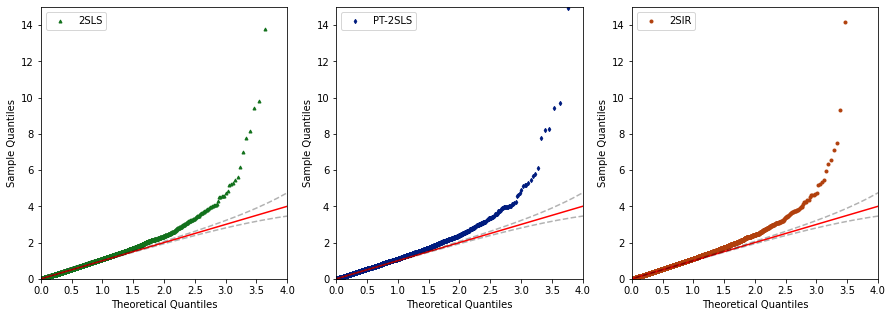

In [11]:
fig, axs = plt.subplots(1,3,figsize=(15, 5))
for i in range(3):
    sm.qqplot(-np.log10(df[df['method'] == methods[i]]['p-value'].values), dist=neg_log_uniform(), line="45", ax=axs[i])
    axs[i].set_xlim([0,4.0])
    axs[i].set_ylim([0,15])
    axs[i].get_lines()[0].set_markersize(3.0)
    axs[i].get_lines()[0].set_markeredgecolor(colors[i])
    axs[i].get_lines()[0].set_markerfacecolor(colors[i])
    axs[i].get_lines()[0].set_markerfacecoloralt(colors[i])

axs[0].get_lines()[0].set_marker('^')
axs[1].get_lines()[0].set_marker('d')
axs[2].get_lines()[0].set_marker('o')

axs[0].get_lines()[0].set(label='2SLS')
axs[1].get_lines()[0].set(label='PT-2SLS')
axs[2].get_lines()[0].set(label='2SIR')

for i in range(3):
    axs[i].plot(-np.log10(ep_points), -np.log10(low_bound), 'k--', alpha=0.3)
    axs[i].plot(-np.log10(ep_points), -np.log10(up_bound), 'k--', alpha=0.3)
    axs[i].legend()
plt.show()

## Bar-plot for significant genes

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
gene_set = list(set(df['gene']))
num_gen = len(gene_set)
level = 0.05 / num_gen

In [14]:
# take the gene with at least one siginificant p-value
min_p = df.groupby('gene')['p-value'].min()
gene_set = list(min_p[min_p < level].index)

In [15]:
df = df[df['gene'].isin(gene_set)]
df['log-p-value'] = - np.log10( df['p-value'] )
## we only print the results for comb-2SIR
df = df[df['method'] != '2SIR']

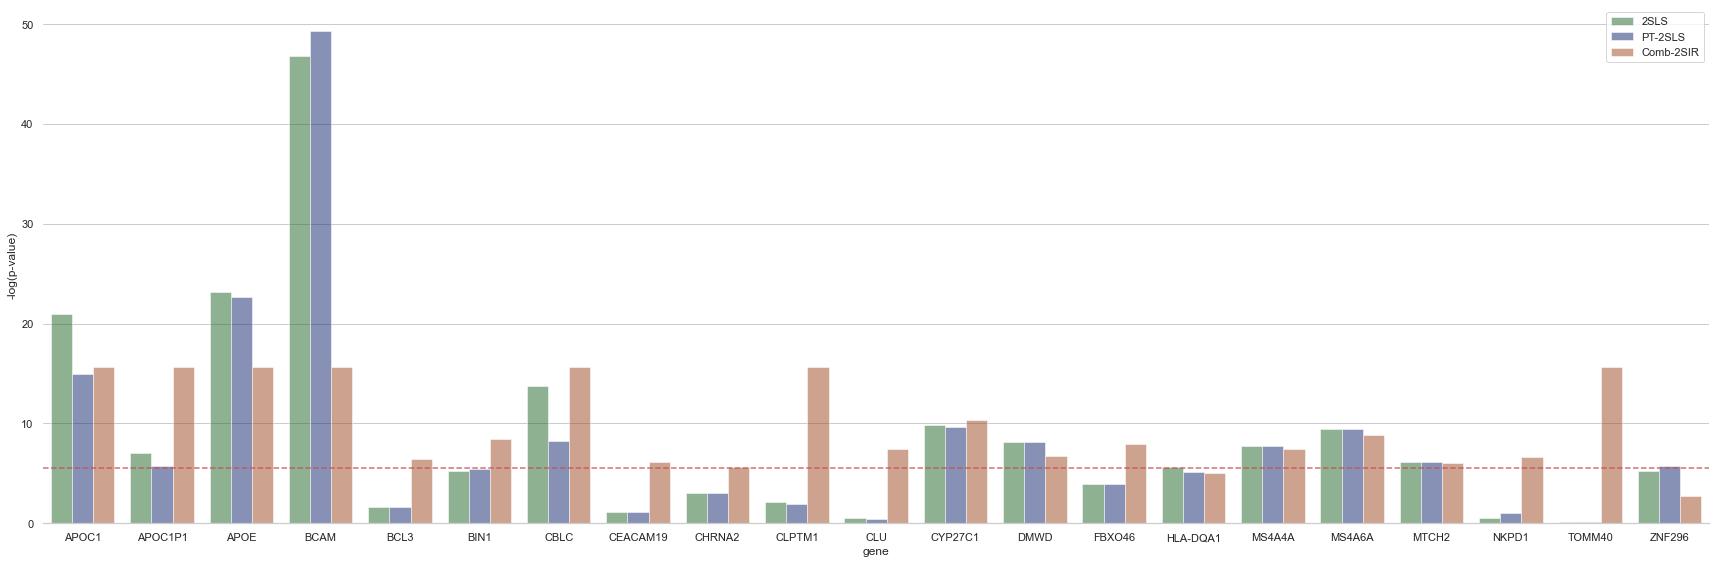

In [16]:
gene_set = set(df['gene'])
gene_set = list(gene_set)
gene_set.sort()
## plot for the final results
sns.set_theme(style="whitegrid")
# Draw a nested barplot by species and sex
plt.rcParams["figure.figsize"] = (16,6)

g = sns.catplot(
    data=df, kind="bar", order=gene_set,
    x="gene", y="log-p-value", hue="method",
    alpha=.5, height=8, legend=False, aspect=3,
    # palette='deep'
    # palette=sns.color_palette(['green', 'blue', 'orange'])
    palette = [sns.color_palette("dark")[2], sns.color_palette("dark")[0], sns.color_palette("dark")[1]]
)
plt.axhline(-np.log10(level), ls='--', color='r', alpha=.8)
g.despine(left=True)
g.set_axis_labels("gene", "-log(p-value)")
plt.legend(loc='upper right')
plt.show()